# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans
from pandas import DataFrame
from matplotlib.pyplot import *
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import socket
import data_exploration

myhost = socket.gethostname()

if myhost != "i24.lan":
    import sagemaker

%matplotlib inline

# UNCONSTRAINED DISPLAY
from IPython.core.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 55em; }</style>"))
np.set_printoptions(linewidth=400)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
InteractiveShell.ast_node_interactivity = "all"
FIG_WIDTH = 18
FIG_HEIGHT = 8
warnings.filterwarnings('ignore')

## Part 0: Get to Know the Data
- **Retrieve Data**
- **Handle Missing Row Data**
- **Handle Missing Column Data**
- **Encode Non-Numerical Features**
- **Impute Missing Data**
- **Handle Outliers**
- **Standardize - Normalize Data**


There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

<br/>

## Retrieve Data

In [2]:
# RETRIEVE DATA
# --- Local copies ---
genpop = pd.read_csv("Udacity_AZDIAS_052018.csv", index_col=[0])
kunden = pd.read_csv("Udacity_CUSTOMERS_052018.csv", index_col=[0])
mailed = pd.read_csv("Udacity_MAILOUT_052018_TRAIN.csv", index_col=[0])
totest = pd.read_csv("Udacity_MAILOUT_052018_TEST.csv", index_col=[0])

# --- AWS SageMaker S3 copies ---
#genpop = pd.read_csv('s3://{}/{}'.format(sagemaker.Session().default_bucket(), "arvato/Udacity_AZDIAS_052018.csv"), index_col=[0])
#kunden = pd.read_csv('s3://{}/{}'.format(sagemaker.Session().default_bucket(), "arvato/Udacity_CUSTOMERS_052018.csv"), index_col=[0])
#mailed = pd.read_csv('s3://{}/{}'.format(sagemaker.Session().default_bucket(), "arvato/Udacity_MAILOUT_052018_TRAIN.csv"), index_col=[0])    
#totest = pd.read_csv('s3://{}/{}'.format(sagemaker.Session().default_bucket(), "arvato/Udacity_MAILOUT_052018_TEST.csv"), index_col=[0])    
    
# Get an overview of the feature types
genpop.info()
print("--------------------------------------")
kunden.info()
print("--------------------------------------")
mailed.info()
print("--------------------------------------")
totest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 541.0+ MB
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.6+ MB
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.9+ MB


<br/><br/>

## Handle Missing Row Data

Ideally we'd like to have clean relevant data with nothing missing. In reality, however, data collection methodologies are plagued with defects that result in incomplete, erroneus, or even irrelevant entries. We'll try and make the best use of the data given to us, and extract information without contaminating it with our processing steps.

- **Drop Rows:** The code cell below produces a histogram of the percentage of data missing down the rows of the general population and customer datasets. It also graphs this percentage of data missing against the percentage of rows with that much or more data missing, a kind of deterioration in row data quality. Surprisingly, the histograms appear multimodal for both datasets, and the deterioration exhibits multiple jumps, with a significant jump at around 68% of missing row data for both. This translates to about 10% of rows in the general population being barren, and correspondingly about 20% of the rows from the customer dataset. This seems to indicate that two or more separate data collection efforts have been used and mixed to produce our data. It may be the result of separate survey questionnaires, different data collection agencies, or some other similar reason. Mixed data presents us with two problems; first, letting go of 20% of the customer rows would waste a large portion of the information. Second, if indeed a different data gathering approach had been used, perhaps a more recent, or one focused on a refined subset of more relevant survey questions (features), then this 20% could potentially be the most meaningful piece of the entire dataset. As far as the general population, 10% hollow rows do not pose that much of a problem, as it is the customer data that this project is focused on.

For the sake of expediency, we'll drop the mostly empty rows from the datasets, i.e., 10% of general population rows and 20% of customer rows missing 60% or more of their entries. This, in my opinion, is preferable to filling the data by imputing values for columns exhibiting a mixture of statistics, and then conducting an analysis on what appears to be mixed datasets that perhaps have incompatible distributions across the features.

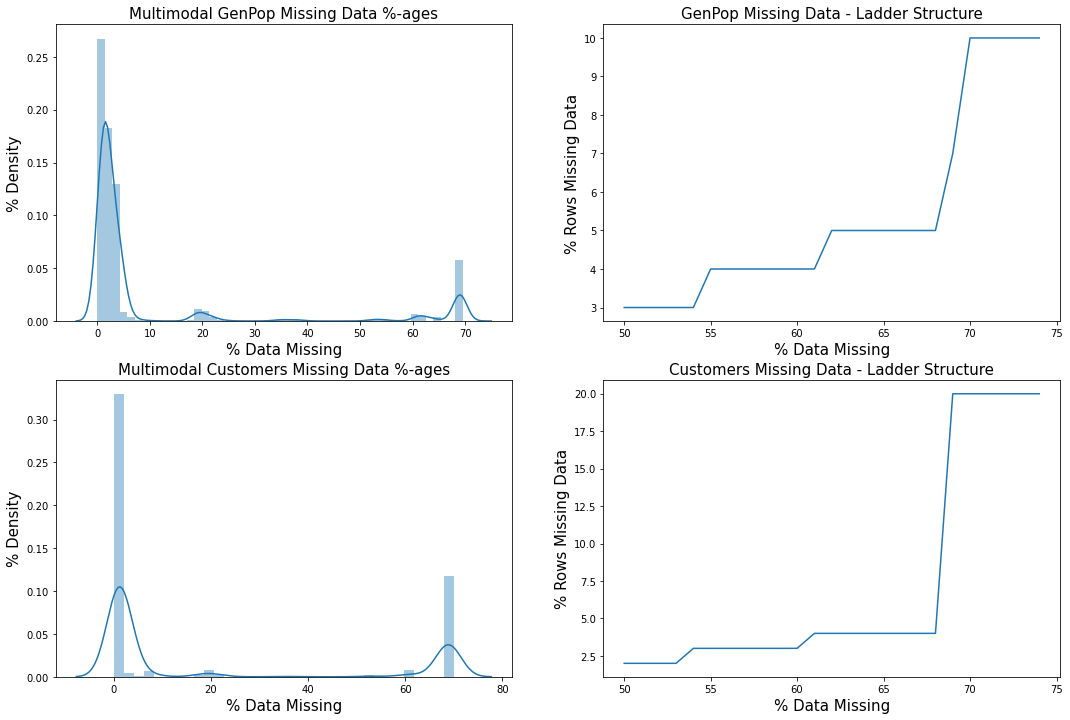

General Population % data missing: 10%
Customer % data missing: 20%


In [3]:
gh = genpop.isnull().sum(axis=1).apply(lambda x:100*round(x/genpop.shape[1],2))
kh = kunden.isnull().sum(axis=1).apply(lambda x:100*round(x/kunden.shape[1],2))
gx, gy = data_exploration.empty_rows(genpop)
kx, ky = data_exploration.empty_rows(kunden)

# Show histograms and cumulative deterioration in row %-age data missing
print("")
f = plt.figure(figsize=(FIG_WIDTH, 3*FIG_HEIGHT/2))
ax1 = f.add_subplot(221)
_ = ax1.set_title("Multimodal GenPop Missing Data %-ages", fontsize=15)
_ = ax1.set_xlabel('% Data Missing', fontsize=15)
_ = ax1.set_ylabel('% Density', fontsize=15)
_ = sns.distplot(gh)
ax2 = f.add_subplot(222)
_ = ax2.set_title('GenPop Missing Data - Ladder Structure', fontsize=15)
_ = plt.plot(gx, gy)
_ = plt.xlabel("% Data Missing", fontsize=15)
_ = plt.ylabel("% Rows Missing Data", fontsize=15)

ax3 = f.add_subplot(223)
_ = ax3.set_title("Multimodal Customers Missing Data %-ages", fontsize=15)
_ = ax3.set_xlabel('% Data Missing', fontsize=15)
_ = ax3.set_ylabel('% Density', fontsize=15)
_ = sns.distplot(kh)
ax4 = f.add_subplot(224)
_ = ax4.set_title("Customers Missing Data - Ladder Structure", fontsize=15)
_ = plt.plot(kx, ky)
_ = plt.xlabel("% Data Missing", fontsize=15)
_ = plt.ylabel("% Rows Missing Data", fontsize=15)
_ = plt.show()
print("General Population % data missing: {:2}%".format(round(100*genpop.isnull().sum().sum()/genpop.size)))
print("Customer % data missing: {:2}%".format(round(100*kunden.isnull().sum().sum()/kunden.size)))

In [4]:
# Eliminate rows with more than 60% of their entries missing.
genpop = genpop.dropna(axis=0, thresh=int(.6*genpop.shape[1] + 1))
kunden = kunden.dropna(axis=0, thresh=int(.6*kunden.shape[1] + 1))
print("General Population % data missing: {:2}%".format(round(100*genpop.isnull().sum().sum()/genpop.size)))
print("Customer % data missing: {:2}%".format(round(100*kunden.isnull().sum().sum()/kunden.size)))

General Population % data missing:  3%
Customer % data missing:  2%


<br/>

## Handle Missing Column Data
- **Drop Columns:** Dropping columns loses not only the information in the non-empty rows, but also the potential relation of those values with neighboring features. Dropping features is something best done later when we perform Principal Component Analysis; there the features are traded-off against retained variance, and hence, such choices are statistically justifiable. We'll restric dropping of features only to those that are clearly irrelevant such as **_`LNR`_**, or those features that are missing so much data as to render them useless for analysis. Our function **`dropoff(df, cutoff=.25)`** will eliminate columns missing data in excess of a `cutoff` value at `25%`. This arbitrary level is based on inspecting the percentages of column missing data in our datasets. The code cell below shows these percentages; notice the large jump in missing feature data starting at 25% for both datasets; also notice that very few columns exceed this cutoff level, making the 25% a benign choice for data integrity.
- **Irrelevant Columns:** In `EINGEFUEGT_AM`, we have a date-time feature whose description is missing from the ancillary EXCEL spreadsheets, but going by the name, it seems to indicate the very instant that this individual row was added to the dataset. This is a good candidate to drop, as such information pertaining to when exactly the data was collected has little to tell us. We'll also take this opportunity to drop the irrelevant ID column `LNR`, as it adds no information to the analysis.
- **Extraneous Columns:** The customer dataset contains three excess columns `CUSTOMER_GROUP`, `ONLINE_PURCHASE`, and `PRODUCT_GROUP`, which need to be dropped as they are particular to the customer dataset, but not to the general population.

In [5]:
# Check column-wise percentages of missing data.
print("----- General Population - Missing Data High Offenders ------")
genpop.isnull().mean().sort_values(ascending=False).head(10)
print("---------- Customers - Missing Data High Offenders ----------")
kunden.isnull().mean().sort_values(ascending=False).head(10)

----- General Population - Missing Data High Offenders ------


ALTER_KIND4                   0.998524
ALTER_KIND3                   0.992421
ALTER_KIND2                   0.963897
ALTER_KIND1                   0.900998
EXTSEL992                     0.708533
KK_KUNDENTYP                  0.626127
ALTERSKATEGORIE_FEIN          0.230452
D19_KONSUMTYP                 0.224728
D19_LOTTO                     0.224728
D19_BANKEN_ONLINE_QUOTE_12    0.224728
dtype: float64

---------- Customers - Missing Data High Offenders ----------


ALTER_KIND4       0.998346
ALTER_KIND3       0.991220
ALTER_KIND2       0.964994
ALTER_KIND1       0.919227
KK_KUNDENTYP      0.450589
EXTSEL992         0.264613
HH_DELTA_FLAG     0.049259
W_KEIT_KIND_HH    0.049259
KBA05_ZUL3        0.037100
KBA05_HERST5      0.037100
dtype: float64

In [6]:
# Drop columns with excess (>25%) missing data
print("----- General Population ------")
drop_genpop = data_exploration.dropoff(genpop)
genpop.drop(drop_genpop, axis=1, inplace=True)
print("Dropped Columns => {}".format(drop_genpop))
print("Percent of data still missing: {:>3}%".format(round(100*genpop.isnull().sum().sum()/genpop.size)))
print("---------- Customers ----------")
drop_kunden = data_exploration.dropoff(kunden)
kunden.drop(drop_kunden, axis=1, inplace=True)
print("Dropped Columns => {}".format(drop_kunden))
print("Percent of data still missing: {:>3}%".format(round(100*kunden.isnull().sum().sum()/kunden.size)))

----- General Population ------
Dropped Columns => ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
Percent of data still missing:   2%
---------- Customers ----------
Dropped Columns => ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
Percent of data still missing:   1%


In [7]:
# Drop columns with no analytical value
genpop.drop(['LNR', 'EINGEFUEGT_AM'], axis=1, inplace=True)
kunden.drop(['LNR', 'EINGEFUEGT_AM', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)

<br/>

## Encode Non-Numerical Features

In [8]:
# Establish categorical columns to encode
print("----- General Population - Types & Obj cols. ------")
genpop.dtypes.value_counts()
genpop.describe(include=['object'])
print("---------- Customers - Types & Obj cols. ----------")
kunden.dtypes.value_counts()
kunden.describe(include=['object'])

----- General Population - Types & Obj cols. ------


float64    261
int64       92
object       5
dtype: int64

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
count,787812,787812,787812,613982,791957
unique,45,19,43,35,2
top,6B,8,51,D19_UNBEKANNT,W
freq,56423,77816,77428,189817,624482


---------- Customers - Types & Obj cols. ----------


float64    261
int64       92
object       5
dtype: int64

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
count,140631,140631,140631,139832,140889
unique,45,19,43,35,2
top,2D,2,14,D19_UNBEKANNT,W
freq,11182,17528,14663,31015,129625


We have five non-numerical features in the general population and customers datasets that need encoding, and possibly processing. Guidance from the EXCEL spreadsheet reveals the nature of these columns; they are a mixture of nominal and ordinal categories. We'll encode the categorical labels as numbers, so the models can work with them.<br/>
Let's look at these features one at a time, first the nominal, and then the ordinal:
- **`CAMEO_DEU_2015 - Nominal`:** The ancillary EXCEL spreadsheet shows 44 clearly nominal ('Cottage Chick", 'Coffee Rider', 'Socking Away', and the like) categories with an extra "XX" slot as a catch-all default bin for unknowns.
- **`D19_LETZTER_KAUF_BRANCHE - Nominal`:** The name, _LETZTER_KAUF_BRANCHE_ appears to indicate the kind of article that was bought last, ranging in diversity from shoes, to books, to cosmetics, etc. This column contains other column names for its entries. The fact that any data point in this column corresponds to, or is related to an entry in another feature makes it suspect for multicollinearity and its effects on modeling.
- **`OST_WEST_KZ - Nominal (Binary)`:** A simple binary category for West and East German individuals.
- **`CAMEO_DEUG_2015 - Ordinal`:** A catch-all default bin "X" is present in this data; additionally, we have what appears to be phantom duplicate slots; there are rows in slot "1", as well as "1.0", similarly for "2" and "2.0", "3", and "3.0", and so on up to "9", and "9.0". Half of the slots are of string type, and the other half numerical. These entries need to be collated to a numerical category that disambiguates them. It is also worth mentioning that this feature is explained in the  spreadsheet as representing rough wealth status descending from "1" indicating "upper class", down to 9 for "urban working class"; hence, this feature's slots, except for the "X", have intrinsic meaning (order). Thus, the encoding will be limited to replacing "X" with a new slot "10", rather than re-encoding the entire column and thereby losing the original data ordinal information of the non-X bins.
- **`CAMEO_INTL_2015 - Ordinal`:** A catch-all default bin "XX" needs renaming as the last integer in the resulting numerical feature; additionally, we need to disambiguate phantom double categories by collating.

In the code cell below, we use the functions **`encode_nominal(df, col)`**, and **`encode_ordinal(df, col, catchall)`** to carry out the above mentoned encoding steps.

In [9]:
# Perform the actual encoding for both datasets, ensuring that codes for both correspond
print("----- General Population - Encoding of non-numerical features ------")
data_exploration.encode_nominal(genpop, 'CAMEO_DEU_2015')
data_exploration.encode_nominal(genpop, 'D19_LETZTER_KAUF_BRANCHE')
data_exploration.encode_nominal(genpop, 'OST_WEST_KZ')
data_exploration.encode_ordinal(genpop, 'CAMEO_DEUG_2015', "X")
data_exploration.encode_ordinal(genpop, 'CAMEO_INTL_2015', "XX")
print("---------- Customers - Encoding of non-numerical features ----------")
data_exploration.encode_nominal(kunden, 'CAMEO_DEU_2015')
data_exploration.encode_nominal(kunden, 'D19_LETZTER_KAUF_BRANCHE')
data_exploration.encode_nominal(kunden, 'OST_WEST_KZ')
data_exploration.encode_ordinal(kunden, 'CAMEO_DEUG_2015', "X")
data_exploration.encode_ordinal(kunden, 'CAMEO_INTL_2015', "XX")

----- General Population - Encoding of non-numerical features ------
[CAMEO_DEU_2015                ](Unencoded) : ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E' '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C' 'XX']
   (  Encoded) : [35. 15.  5. 25. 37. 13.  8.  0.  4. 42. 20. 36. 30. 21. 43. 40.  1. 12. nan 17. 14. 11. 18. 31. 39. 27. 28.  7. 32. 41. 33. 22.  3. 38. 26. 24. 19. 16.  9.  6. 34. 10. 29. 23.  2. 44.]
Mapping ==>> {0: '1A', 1: '1B', 2: '1C', 3: '1D', 4: '1E', 5: '2A', 6: '2B', 7: '2C', 8: '2D', 9: '3A', 10: '3B', 11: '3C', 12: '3D', 13: '4A', 14: '4B', 15: '4C', 16: '4D', 17: '4E', 18: '5A', 19: '5B', 20: '5C', 21: '5D', 22: '5E', 23: '5F', 24: '6A', 25: '6B', 26: '6C', 27: '6D', 28: '6E', 29: '6F', 30: '7A', 31: '7B', 32: '7C', 33: '7D', 34: '7E', 35: '8A', 36: '8B', 37: '8C', 38: '8D', 39: '9A', 40: '9B', 41: '9C', 42: '9D', 43: '9E', 44: 'XX

<br/><br/>

## Impute Missing Values
There is plenty of literature on the subject of imputation, as well as tools available. One method known as **_`Univariate Imputation`_** consists of replacing missing values of a feature, using some function of its non-missing values without taking into account the relations that may exist across features. Such imputation may introduce biases if too much data is imputed and to the extent the features are concentrated in different regions down the rows. We'll restrict ourselves to this type of imputation, ensuring that the amount of imputed data is low, or at least that the imputation does not affect the distribution of data in the feature, i.e., the central tendency - concentration - and the dispersion.

The **_`SimpleImputer`_** from `sklearn.impute` can be used for univariate imputation. The `strategy` parameter in the `Simple Imputer` can be configured to perform imputation using the `mean`, `median`, `most_frequent` or a `constant` value. We will use a uni-variate algorithm of our own implementation, designed to improve on the idea of using _"the most frequent value"_. The technique of imputing categorical features with the most frequent value - the largest bin with the most hits, the "mode", is tantamount to hiding dirt under the biggest carpet available, where it will least get noticed. The approach is sensible to the extent that missing entries represent a small percentage of the overall feature, say 5% or so (not much dirt to hide). But as the amount of missing data rises, this method begins to exaggerate the concentration of values into the modal bin. Our improvement over mode imputation is a technique that utilizes the data in all the slots of the feature with their corresponding frequencies to guide the imputation of the missing entries. This is akin to hiding dirt under all available carpets, more dirt under the biggest carpet, and correspondingly less dirt under smaller sized carpets. Our code for this technique is seen in the function **`impute(df, min_bins=3, max_bins=50, max_miss=15)`** below. This function examines each feature, and imputes based on whether or not the data is categorical, as well as the percentage of missing data not exceeding some arbitrary threshold, say 15%. For features missing data between 15% and 25%, we'll perform the same technique, but only after a visual inspection of the impact it would have, as judged optically on a case by case basis. 

The function **`see_impute(df)`**, allows us to visualize _before_ and _after_ pictures showing the effect of the technique. The _'before'_ picture shows the missing data as an arbitrary category of our creation, a fake slot with value *`-1`*, shown as a red bar side-by-side with the proper data. Next to it, the _'after'_ picture depicts the "would-be" effect of imputing with the technique. This may not be the ideal solution to the missing data problem. But in the absence of information as to how this data was collected, i.e., not knowing the nature of the `missingness` in the data, whether it is _`Missing Completely At Random (MCAR), Missing At Random (MAR),`_ or _`Missing Not At Random (MNAR)`_, our solution will have to do. As long as we are dealing with large enough datasets that capture the true distribution of the data, this methodology is useful. But we have to remember that we are potentially contaminating the data by the subtle perturbation to inter-feature collinearity resulting from univariate imputation, as well as imputing too much data in some features.

In [10]:
data_exploration.impute(genpop)

ALTERSKATEGORIE_FEIN         Found 26 slots, NOT IMPUTING 23%
ANZ_HH_TITEL                 Found 21 slots, imputing  0% with [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 7.0, 9.0, 13.0, 12.0, 11.0, 14.0, 10.0, 17.0, 20.0, 15.0, 18.0, 16.0, 23.0] and p=[0.97, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ARBEIT                       Found  6 slots, imputing  1% with [4.0, 3.0, 2.0, 1.0, 5.0, 9.0] and p=[0.39, 0.32, 0.17, 0.07, 0.04, 0.0]
BALLRAUM                     Found  7 slots, imputing  0% with [6.0, 1.0, 2.0, 7.0, 3.0, 4.0, 5.0] and p=[0.32, 0.19, 0.13, 0.12, 0.09, 0.08, 0.07]
CAMEO_DEU_2015               Found 45 slots, imputing  1% with [25.0, 35.0, 15.0, 8.0, 11.0, 30.0, 12.0, 36.0, 13.0, 37.0, 42.0, 40.0, 41.0, 31.0, 39.0, 7.0, 38.0, 28.0, 6.0, 21.0, 26.0, 5.0, 18.0, 3.0, 0.0, 19.0, 9.0, 20.0, 32.0, 14.0, 16.0, 10.0, 24.0, 43.0, 27.0, 29.0, 33.0, 17.0, 4.0, 34.0, 2.0, 23.0, 1.0, 22.0, 44.0] and p=[0.07, 0.07, 0.06, 0.04, 0.04,

KBA05_KW3                    Found  6 slots, imputing  4% with [1.0, 0.0, 2.0, 3.0, 4.0, 9.0] and p=[0.31, 0.27, 0.21, 0.11, 0.08, 0.02]
KBA05_MAXAH                  Found  6 slots, imputing  4% with [3.0, 5.0, 2.0, 4.0, 1.0, 9.0] and p=[0.28, 0.26, 0.25, 0.13, 0.07, 0.02]
KBA05_MAXBJ                  Found  5 slots, imputing  4% with [1.0, 4.0, 2.0, 3.0, 9.0] and p=[0.34, 0.25, 0.24, 0.15, 0.02]
KBA05_MAXHERST               Found  6 slots, imputing  4% with [2.0, 3.0, 4.0, 1.0, 5.0, 9.0] and p=[0.36, 0.28, 0.15, 0.11, 0.09, 0.02]
KBA05_MAXSEG                 Found  5 slots, imputing  4% with [2.0, 1.0, 3.0, 4.0, 9.0] and p=[0.39, 0.27, 0.23, 0.09, 0.02]
KBA05_MAXVORB                Found  4 slots, imputing  4% with [2.0, 3.0, 1.0, 9.0] and p=[0.43, 0.32, 0.24, 0.02]
KBA05_MOD1                   Found  6 slots, imputing  4% with [0.0, 2.0, 1.0, 3.0, 4.0, 9.0] and p=[0.38, 0.24, 0.19, 0.12, 0.06, 0.02]
KBA05_MOD2                   Found  6 slots, imputing  4% with [3.0, 2.0, 4.0, 1.0, 5

KBA13_GBZ                    Found  5 slots, imputing  1% with [3.0, 4.0, 5.0, 2.0, 1.0] and p=[0.36, 0.23, 0.21, 0.14, 0.05]
KBA13_HALTER_20              Found  5 slots, imputing  1% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.43, 0.24, 0.19, 0.08, 0.06]
KBA13_HALTER_25              Found  5 slots, imputing  1% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.43, 0.21, 0.18, 0.09, 0.08]
KBA13_HALTER_30              Found  5 slots, imputing  1% with [3.0, 2.0, 4.0, 5.0, 1.0] and p=[0.41, 0.2, 0.19, 0.12, 0.08]
KBA13_HALTER_35              Found  5 slots, imputing  1% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.39, 0.2, 0.19, 0.13, 0.08]
KBA13_HALTER_40              Found  5 slots, imputing  1% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.4, 0.2, 0.19, 0.12, 0.08]
KBA13_HALTER_45              Found  5 slots, imputing  1% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.4, 0.2, 0.2, 0.1, 0.09]
KBA13_HALTER_50              Found  5 slots, imputing  1% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.41, 0.23, 0.17, 0.11, 0.07]


KBA13_SEG_SPORTWAGEN         Found  6 slots, imputing  1% with [3.0, 2.0, 1.0, 4.0, 5.0, 0.0] and p=[0.34, 0.19, 0.14, 0.12, 0.11, 0.11]
KBA13_SEG_UTILITIES          Found  5 slots, imputing  1% with [3.0, 2.0, 4.0, 5.0, 1.0] and p=[0.44, 0.21, 0.2, 0.08, 0.07]
KBA13_SEG_VAN                Found  5 slots, imputing  1% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.43, 0.21, 0.2, 0.09, 0.07]
KBA13_SEG_WOHNMOBILE         Found  6 slots, imputing  1% with [3.0, 2.0, 1.0, 4.0, 0.0, 5.0] and p=[0.34, 0.21, 0.12, 0.11, 0.11, 0.1]
KBA13_SITZE_4                Found  5 slots, imputing  1% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.42, 0.23, 0.16, 0.12, 0.07]
KBA13_SITZE_5                Found  5 slots, imputing  1% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.42, 0.23, 0.16, 0.12, 0.07]
KBA13_SITZE_6                Found  5 slots, imputing  1% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.43, 0.21, 0.19, 0.1, 0.07]
KBA13_TOYOTA                 Found  5 slots, imputing  1% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.44

In [11]:
data_exploration.impute(kunden)

ALTERSKATEGORIE_FEIN         Found 25 slots, imputing  4% with [10.0, 9.0, 11.0, 12.0, 8.0, 13.0, 0.0, 14.0, 15.0, 7.0, 16.0, 17.0, 6.0, 18.0, 19.0, 20.0, 5.0, 21.0, 24.0, 25.0, 22.0, 4.0, 23.0, 2.0, 3.0] and p=[0.14, 0.14, 0.1, 0.09, 0.08, 0.08, 0.08, 0.08, 0.06, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ANZ_HH_TITEL                 Found 20 slots, imputing  2% with [0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 13.0, 7.0, 5.0, 8.0, 9.0, 17.0, 11.0, 14.0, 20.0, 10.0, 23.0, 18.0, 15.0, 12.0] and p=[0.96, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ARBEIT                       Found  6 slots, imputing  0% with [3.0, 4.0, 2.0, 1.0, 5.0, 9.0] and p=[0.36, 0.27, 0.24, 0.12, 0.02, 0.0]
BALLRAUM                     Found  7 slots, imputing  0% with [6.0, 1.0, 2.0, 7.0, 3.0, 4.0, 5.0] and p=[0.34, 0.15, 0.14, 0.13, 0.09, 0.08, 0.07]
CAMEO_DEU_2015               Found 45 slots, imputing  0% with [8.0, 25.0, 15.0, 1

KBA05_KW1                    Found  6 slots, imputing  4% with [3.0, 2.0, 4.0, 1.0, 5.0, 9.0] and p=[0.39, 0.27, 0.17, 0.13, 0.04, 0.01]
KBA05_KW2                    Found  6 slots, imputing  4% with [3.0, 4.0, 2.0, 5.0, 1.0, 9.0] and p=[0.45, 0.22, 0.19, 0.08, 0.05, 0.01]
KBA05_KW3                    Found  6 slots, imputing  4% with [1.0, 2.0, 0.0, 3.0, 4.0, 9.0] and p=[0.32, 0.25, 0.15, 0.15, 0.13, 0.01]
KBA05_MAXAH                  Found  6 slots, imputing  4% with [5.0, 3.0, 2.0, 4.0, 1.0, 9.0] and p=[0.4, 0.25, 0.16, 0.16, 0.02, 0.01]
KBA05_MAXBJ                  Found  5 slots, imputing  4% with [4.0, 1.0, 2.0, 3.0, 9.0] and p=[0.32, 0.27, 0.22, 0.18, 0.01]
KBA05_MAXHERST               Found  6 slots, imputing  4% with [2.0, 3.0, 1.0, 4.0, 5.0, 9.0] and p=[0.42, 0.25, 0.15, 0.12, 0.05, 0.01]
KBA05_MAXSEG                 Found  5 slots, imputing  4% with [2.0, 1.0, 3.0, 4.0, 9.0] and p=[0.39, 0.25, 0.23, 0.12, 0.01]
KBA05_MAXVORB                Found  4 slots, imputing  4% with [

KBA13_HALTER_45              Found  5 slots, imputing  0% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.43, 0.22, 0.19, 0.09, 0.06]
KBA13_HALTER_50              Found  5 slots, imputing  0% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.42, 0.23, 0.18, 0.09, 0.07]
KBA13_HALTER_55              Found  5 slots, imputing  0% with [3.0, 2.0, 4.0, 5.0, 1.0] and p=[0.42, 0.22, 0.2, 0.08, 0.08]
KBA13_HALTER_60              Found  5 slots, imputing  0% with [3.0, 2.0, 4.0, 5.0, 1.0] and p=[0.43, 0.21, 0.2, 0.08, 0.08]
KBA13_HALTER_65              Found  5 slots, imputing  0% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.44, 0.27, 0.13, 0.13, 0.03]
KBA13_HALTER_66              Found  5 slots, imputing  0% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.41, 0.24, 0.17, 0.13, 0.05]
KBA13_HERST_ASIEN            Found  5 slots, imputing  0% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.45, 0.26, 0.15, 0.1, 0.04]
KBA13_HERST_AUDI_VW          Found  5 slots, imputing  0% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.46, 0.22, 0.19, 0.08, 0

KBA13_VORB_2                 Found  5 slots, imputing  0% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.47, 0.26, 0.16, 0.07, 0.04]
KBA13_VORB_3                 Found  6 slots, imputing  0% with [3.0, 2.0, 0.0, 1.0, 4.0, 5.0] and p=[0.31, 0.28, 0.23, 0.09, 0.07, 0.04]
KBA13_VW                     Found  5 slots, imputing  0% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.46, 0.2, 0.2, 0.07, 0.07]
KKK                          Found  5 slots, imputing  3% with [3.0, 2.0, 1.0, 4.0, 0.0] and p=[0.3, 0.29, 0.21, 0.16, 0.04]
KONSUMNAEHE                  Found  7 slots, imputing  0% with [3.0, 5.0, 4.0, 1.0, 2.0, 6.0, 7.0] and p=[0.24, 0.2, 0.19, 0.18, 0.17, 0.02, 0.0]
LP_FAMILIE_FEIN              Found 12 slots, imputing  2% with [1.0, 10.0, 2.0, 11.0, 0.0, 8.0, 7.0, 9.0, 5.0, 6.0, 4.0, 3.0] and p=[0.28, 0.24, 0.2, 0.15, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.0, 0.0]
LP_FAMILIE_GROB              Found  6 slots, imputing  2% with [5.0, 1.0, 2.0, 4.0, 0.0, 3.0] and p=[0.41, 0.28, 0.2, 0.06, 0.05, 0.01]
LP_L

In [12]:
print("Percent of General Population data still missing: {:2}%".format(round(100*genpop.isnull().sum().sum()/genpop.size)))
print("Percent of Customer data still missing: {:2}%".format(round(100*kunden.isnull().sum().sum()/kunden.size)))

Percent of General Population data still missing:  1%
Percent of Customer data still missing:  0%


- **`NOT IMPUTED:`**
Features with too much missing data, percentage-wise, are highlighted in red in the output of **`impute(df)`** above; these are categorical features missing more than 15%. By now, most categorical features in the general population data have been imputed, and what remains to impute in the dataset (~1%), numerical and categorical, can be visualized together.

The code cell below enables us to visually inspect the effect of our technique on the general population, without actually performing the imputation, for features missing more than 15%.

,ALTERSKATEGORIE_FEIN,D19_KONSUMTYP,D19_LETZTER_KAUF_BRANCHE,D19_BANKEN_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,D19_SOZIALES,D19_VERSI_ONLINE_QUOTE_12,D19_LOTTO,D19_TELKO_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_QUOTE_12,HH_DELTA_FLAG,KBA13_ANZAHL_PKW,KONSUMZELLE
1,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,963.0,1.0
2,17.0,9.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,712.0,0.0
3,13.0,9.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,596.0,0.0
4,14.0,1.0,24.0,10.0,10.0,0.0,0.0,0.0,0.0,10.0,0.0,435.0,0.0
5,10.0,4.0,11.0,0.0,0.0,4.0,0.0,0.0,0.0,10.0,0.0,1300.0,0.0


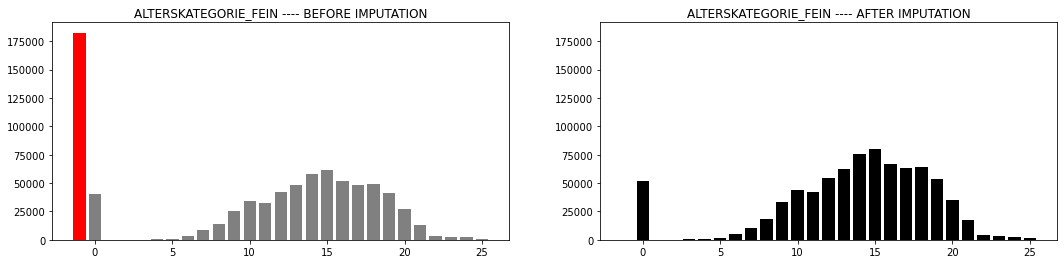

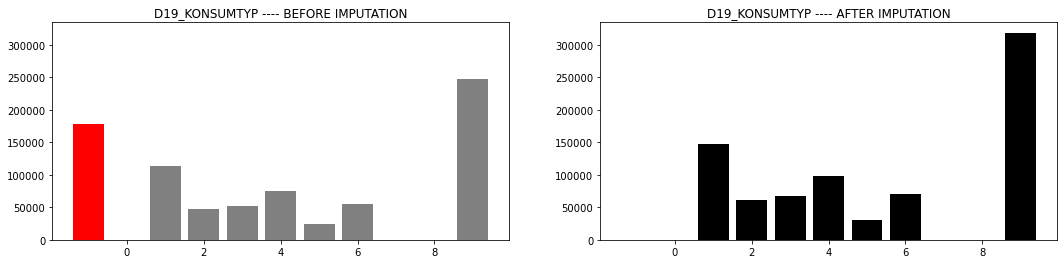

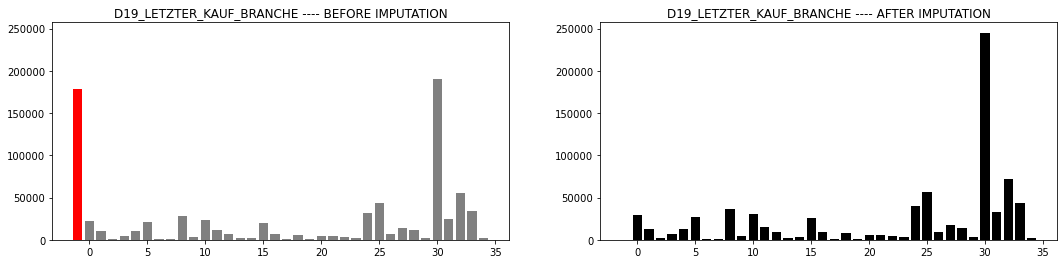

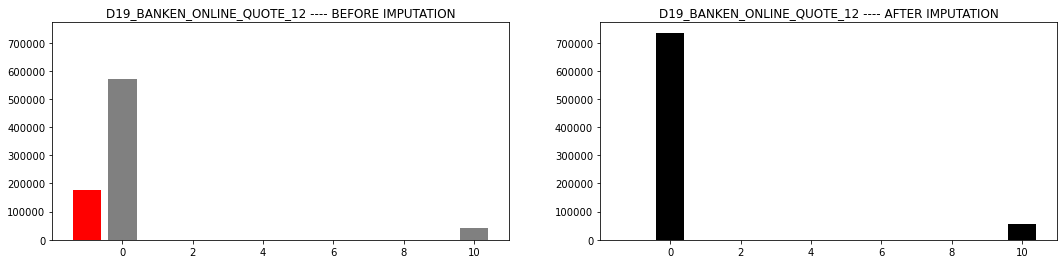

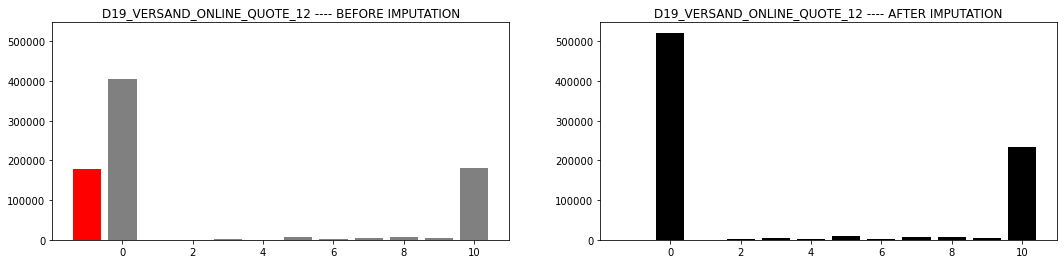

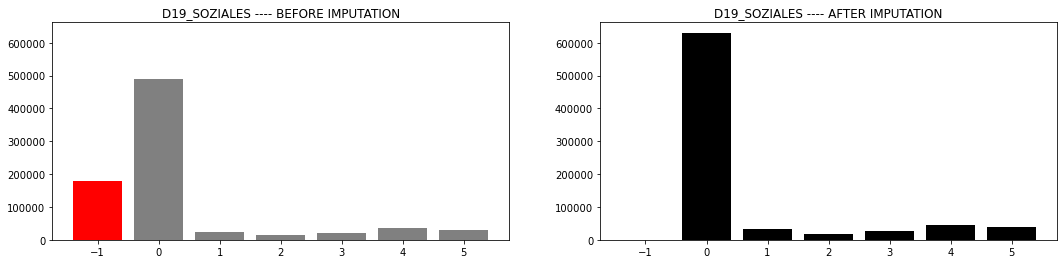

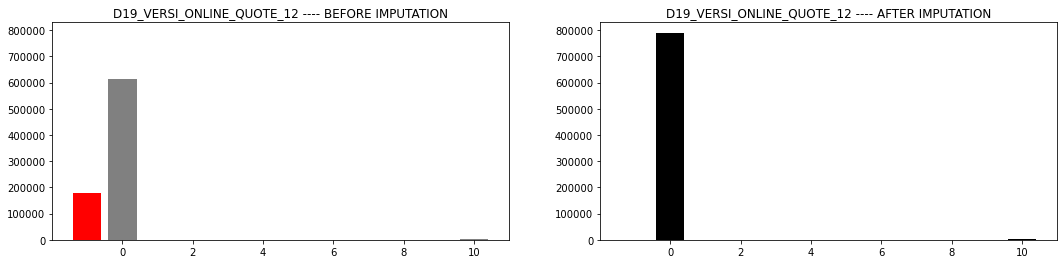

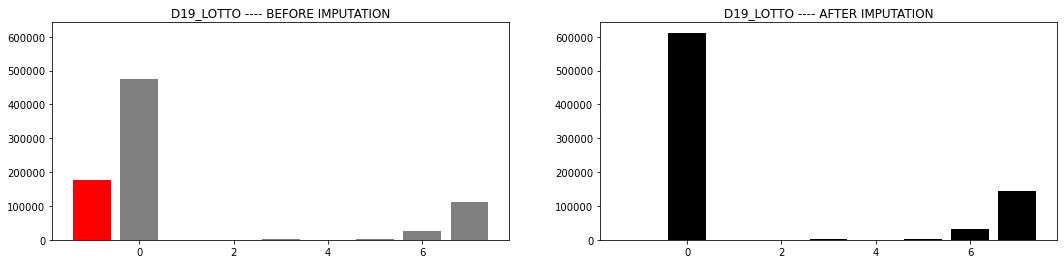

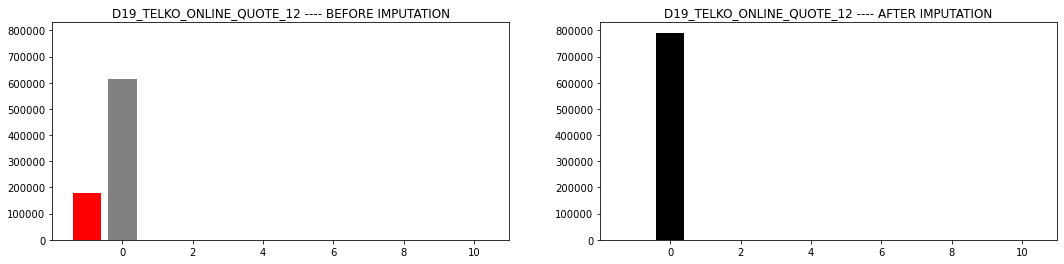

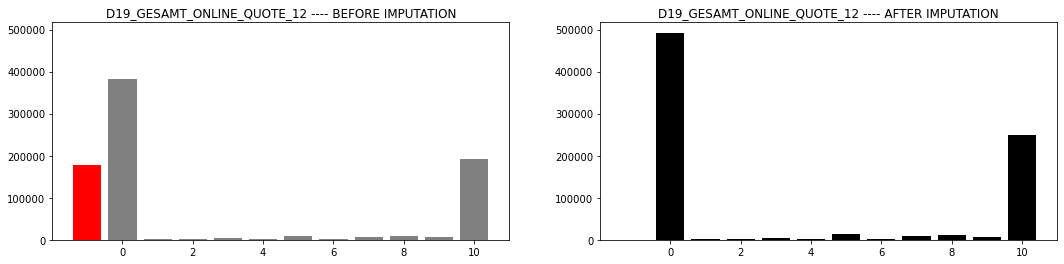

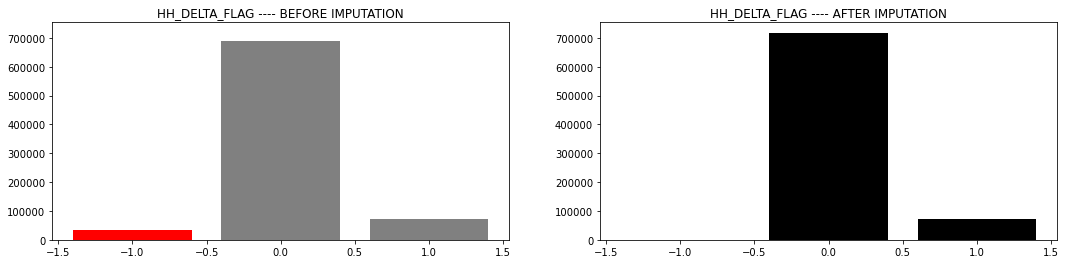

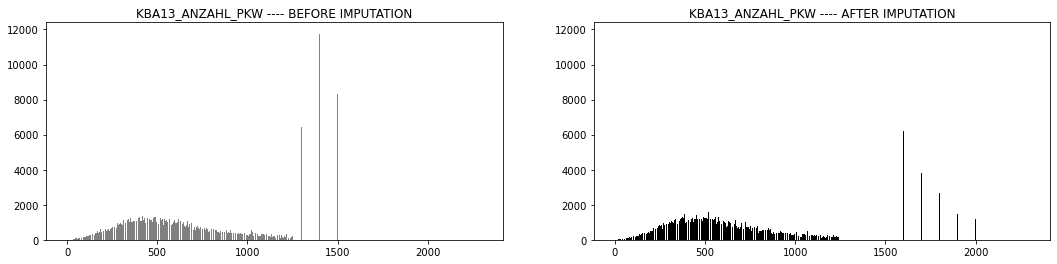

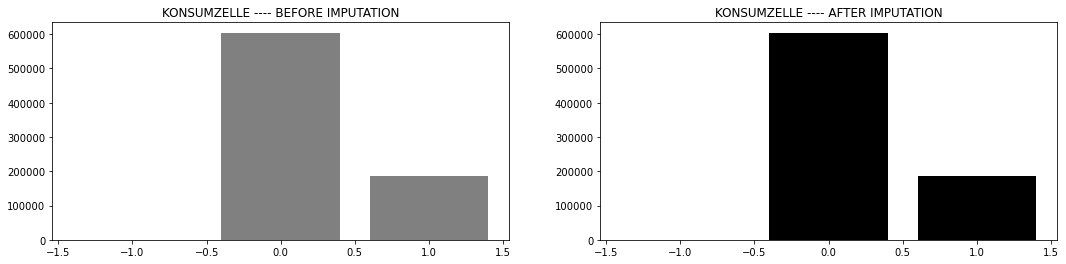

In [13]:
# Examine the rest of the missing data (General Poulation), and the impact our imputing technique would have
genpop_missing = genpop[genpop.isnull().mean().sort_values(ascending=False)[genpop.isnull().mean().sort_values(ascending=False) > 0].index[:]]
genpop_missing.head()
data_exploration.see_impute(genpop_missing)

,HH_DELTA_FLAG,KBA13_ANZAHL_PKW
0,0.0,1201.0
2,0.0,433.0
3,NaN,755.0
4,1.0,513.0
5,0.0,1167.0


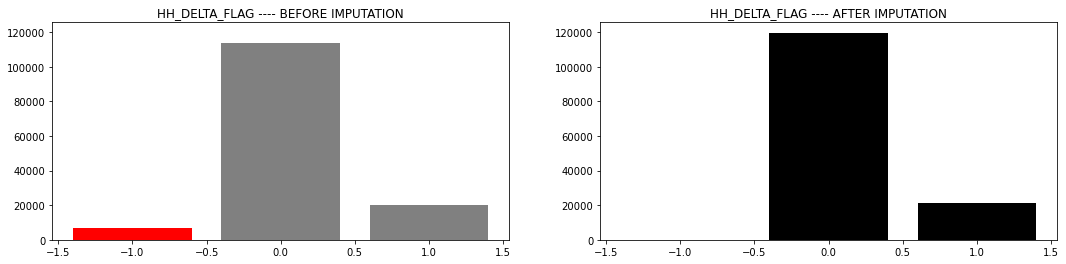

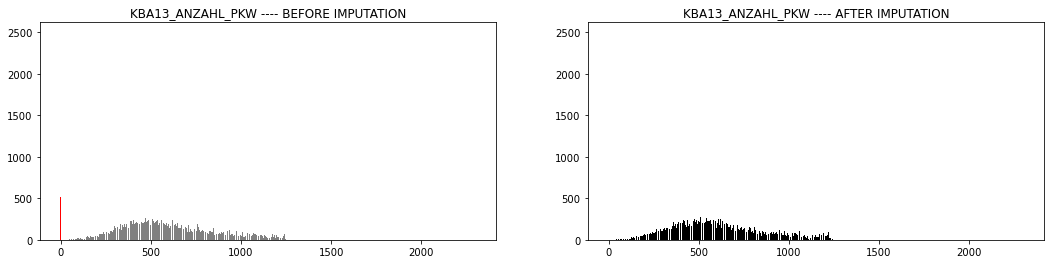

In [14]:
# Examine the rest of the missing data (Customer), and the impact our imputing technique would have
kunden_missing = kunden[kunden.isnull().mean().sort_values(ascending=False)[kunden.isnull().mean().sort_values(ascending=False) > 0].index[:]]
kunden_missing.head()
data_exploration.see_impute(kunden_missing)

With the exception of **`D19_VERSI_ONLINE_QUOTE_12, D19_TELKO_ONLINE_QUOTE_12`** in the general population dataset, and **`KBA13_ANZAHL_PKW`** in both datasets, all other columns appear amenable to our imputation technique. The amount of missing data, between 15% and 25% is significant, to be sure, but the data distribution appears, at least optically, to be unaffected by the methodology. We'll impute them with our algorithm.

In [15]:
# Impute the rest of the categorical features (both sets) whose distribution is not perturbed
for col in genpop[['ALTERSKATEGORIE_FEIN', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
                   'D19_SOZIALES', 'D19_LOTTO', 'D19_GESAMT_ONLINE_QUOTE_12', 'HH_DELTA_FLAG', 'KONSUMZELLE']]:
    data_exploration.impute_feature(genpop[col])
data_exploration.impute_feature(kunden['HH_DELTA_FLAG'])

- **`Drop Columns:`** Handle the two categorical features with missing data, namely `D19_VERSI_ONLINE_QUOTE_12`, and `D19_TELKO_ONLINE_QUOTE_12`. The code cell below shows the justification for dropping them.
    - `D19_VERSI_ONLINE_QUOTE_12:` 9 bins with one taking up 77% of all data, and `NaNs` the remaining 23%; this is a meaningless feature, a column to drop.
    - `D19_TELKO_ONLINE_QUOTE_12:` 5 bins, one taking 77%, and 23% `NaNs`, drop!

In [16]:
print("Number of bins: {}".format(genpop['D19_VERSI_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).count()))
genpop['D19_VERSI_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).head(2)
print("-----------------------------------------------")
print("Number of bins: {}".format(genpop['D19_TELKO_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).count()))
genpop['D19_TELKO_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).head(2)

Number of bins: 9


0.0    0.773259
NaN    0.224728
Name: D19_VERSI_ONLINE_QUOTE_12, dtype: float64

-----------------------------------------------
Number of bins: 5


0.0    0.774303
NaN    0.224728
Name: D19_TELKO_ONLINE_QUOTE_12, dtype: float64

In [17]:
# DROP One-Bin-takes-all categorical features D19_VERSI_ONLINE_QUOTE_12, and D19_TELKO_ONLINE_QUOTE_12
genpop.drop(['D19_VERSI_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12'], axis=1, inplace=True)
kunden.drop(['D19_VERSI_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12'], axis=1, inplace=True)

<br/>

The cell code below reveals the one feature that remains with missing data.
- **`KBA13_ANZAHL_PKW`:** The EXCEL spreadsheet describes it as German for **_"Number of cars in the Zip Code"_**, a numerical feature with over 1,200 different values concentrated in a range of integers that permits them to be considered categorical, albeit with many bins, at least for a thought experiment. It would be beneficial to visualize the effect of imputing with our technique vs. using mean imputation, in spite of the fact that the feature is numerical, and our technique applicable only to categorical features. Our function **`mean_or_not(col, xrange)`** permits this visualization comparing the two imputation strategies - see below.

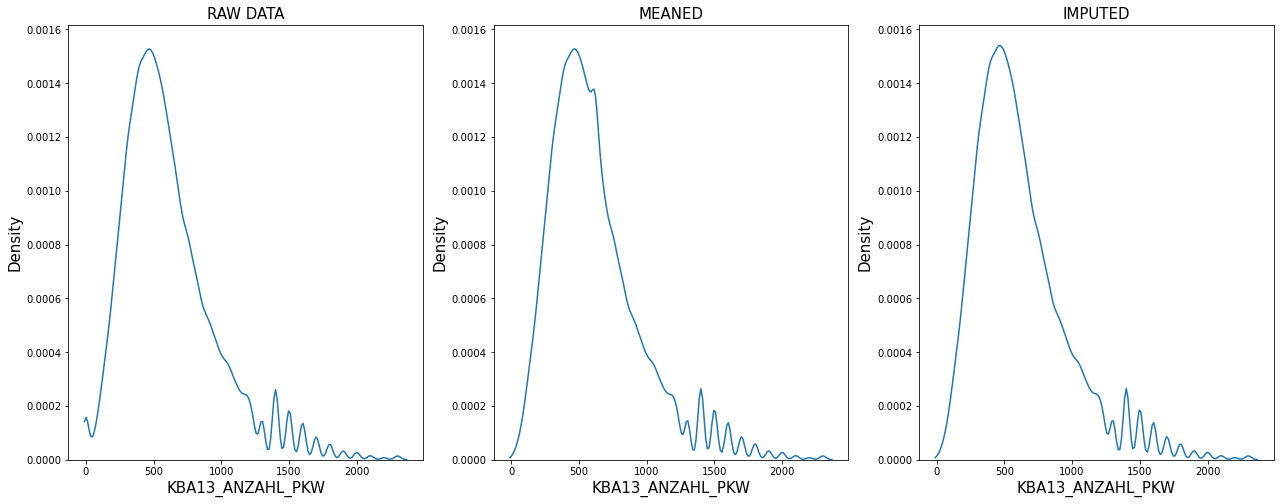

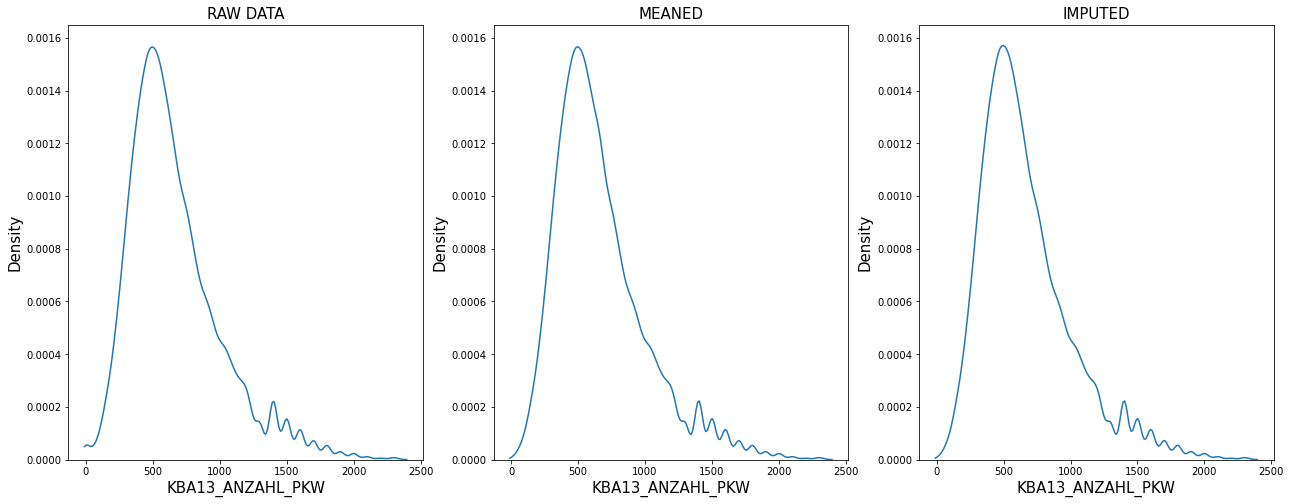

In [18]:
data_exploration.mean_or_not(genpop['KBA13_ANZAHL_PKW'], xrange=(-10,2500))
data_exploration.mean_or_not(kunden['KBA13_ANZAHL_PKW'], xrange=(-10,2500))

In the case of the general population, imputing `KBA13_ANZAHL_PKW` with the mean sticks a lump that appears as an outlier. On the customer dataset, the amount of data missing is too small to be visible. Our imputing technique appears to be superior, or at least arguably so, based on the above visualization. We'll proceed with our imputing technique on both for the sake of consistency.

In [19]:
data_exploration.impute_feature(genpop['KBA13_ANZAHL_PKW'])
data_exploration.impute_feature(kunden['KBA13_ANZAHL_PKW'])

In [20]:
# Establish that no data is missing in the dataset
genpop.columns[genpop.isnull().any()]
kunden.columns[kunden.isnull().any()]
print('\033[1m' + "Percent of data still missing: {:2}%".format(round(100*genpop.isnull().sum().sum()/genpop.size)))

Index([], dtype='object')

Index([], dtype='object')

Percent of data still missing:  0%


<br/>

## Handle Outliers
We can now inspect the numerical feature data for potential outliers. The code cell below lists the numerical features of each dataset in order to visualize their histograms and peruse for potential outliers.

In [21]:
print(" ---- General Population - Numerical Features ----")
data_exploration.numericals(genpop)
print(" ---- Customers - Numerical Features ----")
data_exploration.numericals(kunden)

 ---- General Population - Numerical Features ----
ANZ_HAUSHALTE_AKTIV            [ 292]
ANZ_STATISTISCHE_HAUSHALTE     [ 268]
GEBURTSJAHR                    [ 117]
KBA13_ANZAHL_PKW               [1261]
 ---- Customers - Numerical Features ----
ANZ_HAUSHALTE_AKTIV            [ 216]
ANZ_STATISTISCHE_HAUSHALTE     [ 214]
GEBURTSJAHR                    [ 113]
KBA13_ANZAHL_PKW               [1250]


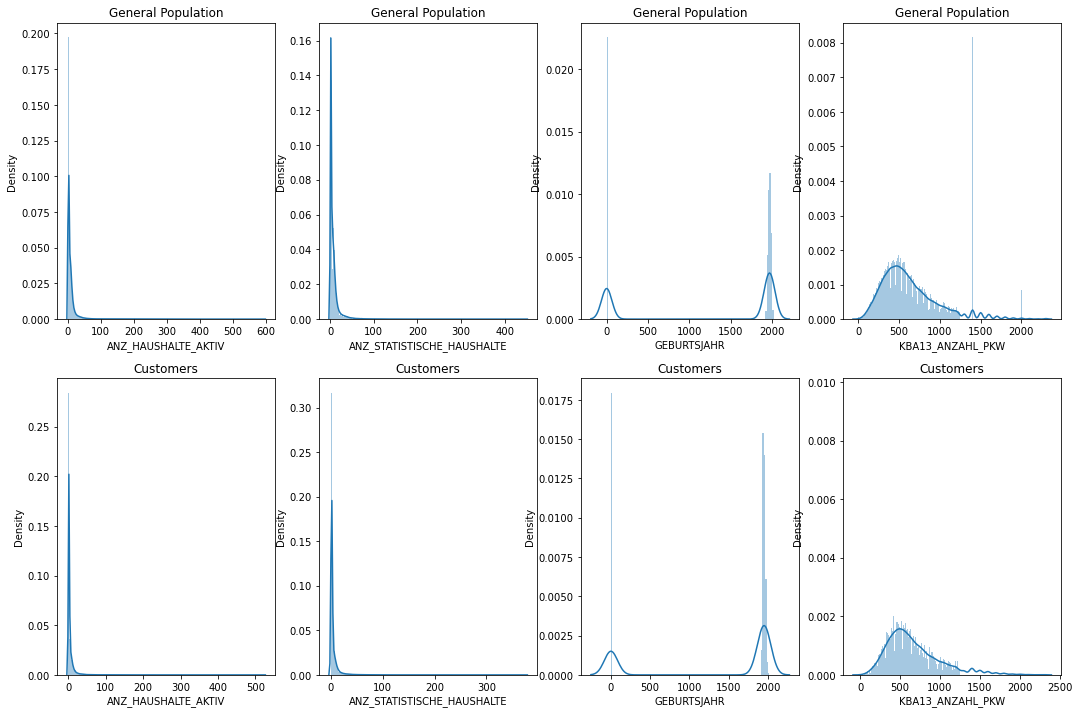

In [22]:
# Inspect distributions for outliers
f = plt.figure(figsize=(FIG_WIDTH, 3*FIG_HEIGHT/2))
ax1 = f.add_subplot(241)
_ = ax1.set_title("General Population")
_ = sns.distplot(genpop['ANZ_HAUSHALTE_AKTIV'], bins=292)
ax2 = f.add_subplot(242)
_ = ax2.set_title("General Population")
_ = sns.distplot(genpop['ANZ_STATISTISCHE_HAUSHALTE'], bins=268)
ax3 = f.add_subplot(243)
_ = ax3.set_title("General Population")
_ = sns.distplot(genpop['GEBURTSJAHR'], bins=117)
ax4 = f.add_subplot(244)
_ = ax4.set_title("General Population")
_ = sns.distplot(genpop['KBA13_ANZAHL_PKW'], bins=1261)
ax5 = f.add_subplot(245)
_ = ax5.set_title("Customers")
_ = sns.distplot(kunden['ANZ_HAUSHALTE_AKTIV'], bins=216)
ax6 = f.add_subplot(246)
_ = ax6.set_title("Customers")
_ = sns.distplot(kunden['ANZ_STATISTISCHE_HAUSHALTE'], bins=214)
ax7 = f.add_subplot(247)
_ = ax7.set_title("Customers")
_ = sns.distplot(kunden['GEBURTSJAHR'], bins=113)
ax8 = f.add_subplot(248)
_ = ax8.set_title("Customers")
_ = sns.distplot(kunden['KBA13_ANZAHL_PKW'], bins=1250)
_ = plt.show()

The feature **_`GEBURTSJAHR`_**, German for _Year Of Birth_, is clearly not bimodal, and much less with individuals being born in the year **_0_**. This appears to be a case where rather than leaving the entry blank, **_missing_**, the data collector instead, decided to assign it to the **_unknown_** slot. The temptation is there to impute these _unknowns_ as we did with missing data. There are two problems with such an approach; on the one hand, we must treat unknowns consistently, meaning that if we treat the unknowns of **_`GEBURTSJAHR`_** as imputable, we must also do so for the unknowns of the other features, at least for other numerical features. On the other hand, if the data was not collected because an individual was unwilling to respond to a survey question, then imputing will introduce the bias of treating a certain part of the population - those unwilling to reveal their age, as being representative of the entire dataset. We need to have a closer inspection of this feature, and draw conclusions as to what course to set regarding similar unknowns in the dataset.

The overwhelming majority of features are categorical, and contain a slot that catches unknown quantities. The data collection is inconsistent with the unknowns, sometimes assigning them to the _0_ slot, and sometimes to the highest numbered slot. There is a temptation to unify unknowns and missing data together for imputation. We avoided this mixing based on the assumption that assigning a data point to the unknown slots was a conscious decision, i.e., data was available, but someone decided that none of the other slots was appropriate, as opposed to the unavailability of any data for that point, i.e., missing.

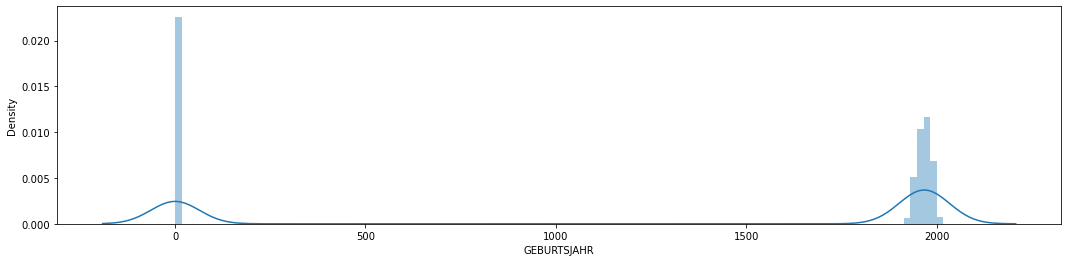

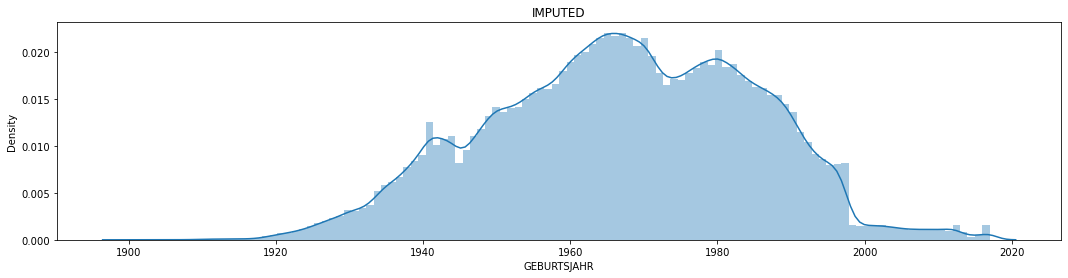

In [23]:
bins = genpop['GEBURTSJAHR'].value_counts().sort_index(ascending=False).count()
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(genpop['GEBURTSJAHR'], bins=bins)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
genpop.loc[(genpop['GEBURTSJAHR'] == 0 ), 'GEBURTSJAHR'] = np.nan
data_exploration.impute_feature(genpop['GEBURTSJAHR'])
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(genpop['GEBURTSJAHR'], bins=bins-1).set_title('IMPUTED')
_ = plt.show()

Upon closer inspection, the course to follow here is evident; imputing is the lesser of the two evils. We must remember the potential contamination of the data by extrapolating a sector of the population, possibly unwilling to reveal their age, as representing the entire population. We may get away with doing this one exceptional imputation case, being that it is indeed the only numerical feature exhibiting this problem.

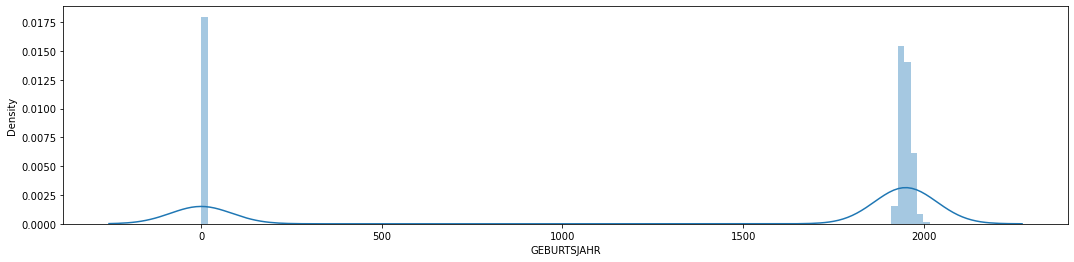

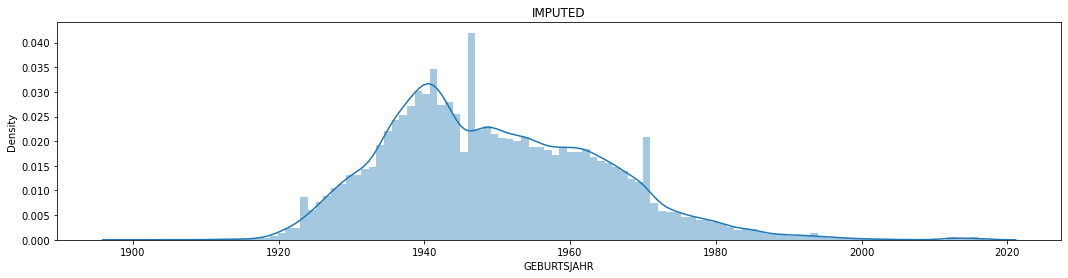

In [24]:
bins = kunden['GEBURTSJAHR'].value_counts().sort_index(ascending=False).count()
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(kunden['GEBURTSJAHR'], bins=bins)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
kunden.loc[(kunden['GEBURTSJAHR'] == 0 ), 'GEBURTSJAHR'] = np.nan
data_exploration.impute_feature(kunden['GEBURTSJAHR'])
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(kunden['GEBURTSJAHR'], bins=bins-1).set_title('IMPUTED')
_ = plt.show()

<br/>The feature **_`KBA13_ANZAHL_PKW`_**, has some outliers trailing the distribution. Entries below 1250 have granularity in units, but those beyond 1250 become coarse, with granularity in the hundreds, causing the entries to become outliers. Ideally we'd be spreading the spike values only around the right tail of the feature, using unit granularity as the rest of the feature data. We'll take the simpler approach of assigning these outliers to the other values in the feature by means of our imputation technique. 

In [25]:
genpop['KBA13_ANZAHL_PKW'].value_counts().sort_index(ascending=False).head(15)

2300.0      619
2200.0      308
2100.0      654
2000.0     1209
1900.0     1465
1800.0     2628
1700.0     3825
1600.0     6182
1500.0     8348
1400.0    11814
1300.0     6471
1250.0      231
1249.0      143
1247.0       76
1246.0      174
Name: KBA13_ANZAHL_PKW, dtype: int64

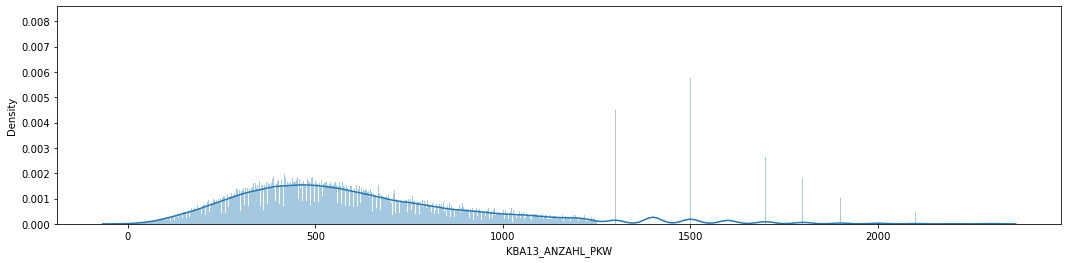

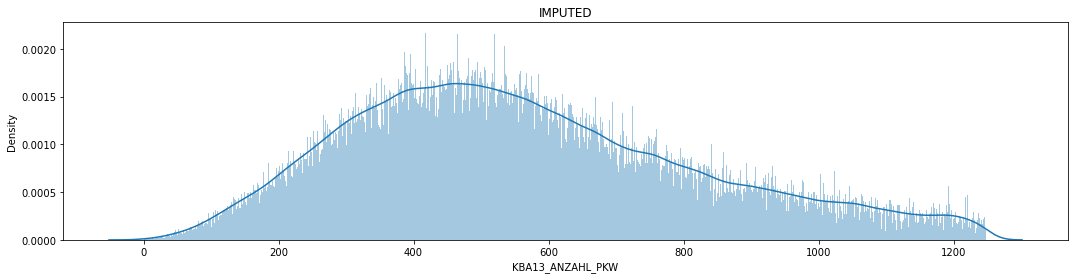

In [26]:
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(genpop['KBA13_ANZAHL_PKW'], bins=1261)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
genpop.loc[(genpop['KBA13_ANZAHL_PKW'] > 1250 ), 'KBA13_ANZAHL_PKW'] = np.nan
data_exploration.impute_feature(genpop['KBA13_ANZAHL_PKW'])

f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(genpop['KBA13_ANZAHL_PKW'], bins=1250).set_title('IMPUTED')
_ = plt.show()

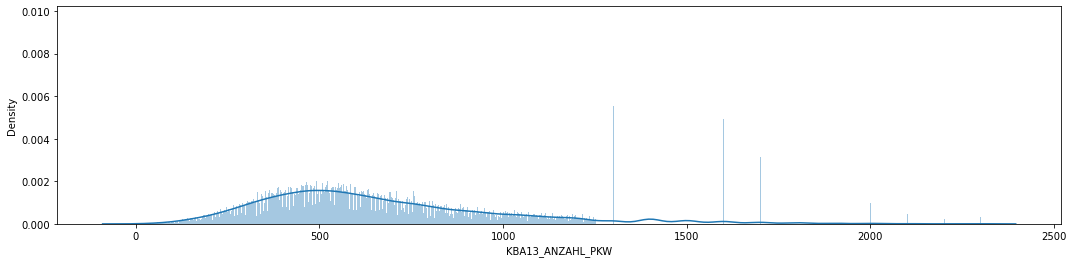

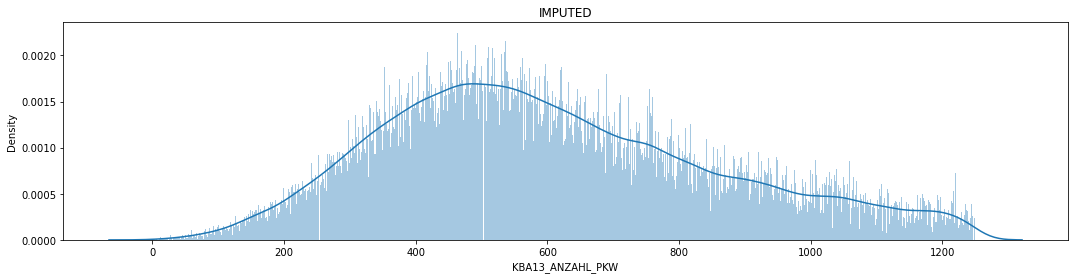

In [27]:
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(kunden['KBA13_ANZAHL_PKW'], bins=1261)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
kunden.loc[(kunden['KBA13_ANZAHL_PKW'] > 1250 ), 'KBA13_ANZAHL_PKW'] = np.nan
data_exploration.impute_feature(kunden['KBA13_ANZAHL_PKW'])

f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(kunden['KBA13_ANZAHL_PKW'], bins=1250).set_title('IMPUTED')
_ = plt.show()

<br/>

## Standardize - Normalize Data

One last processing step on the data is to standardize features by removing the mean and scaling to unit variance.
This process is necessary for the models we'll use later.

In [28]:
# Standardize, and keep numpy array as well as dataframe.
scaler = StandardScaler()
scaler = scaler.fit(genpop)
scaled_genpop = scaler.transform(genpop)
gp = DataFrame(scaled_genpop)

<br/><br/>
## Part 1: Customer Segmentation Report
- **Compare Datasets**
- **Principal Component Analysis**
- **K-Means Clustering**

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

<br/><br/>
## Compare Datasets
We'd like to gain some insight as to how the distribution of each individual feature is different across the two datasets. The code cells below show a function, **`compare_distros(feature)`** to compare distributions, and also a visualization of all features at once. We'll inspect the features from a big-picture, as well as a detailed perspective in order to build a list of those columns that appear to capture the bulk of what makes someone a customer.

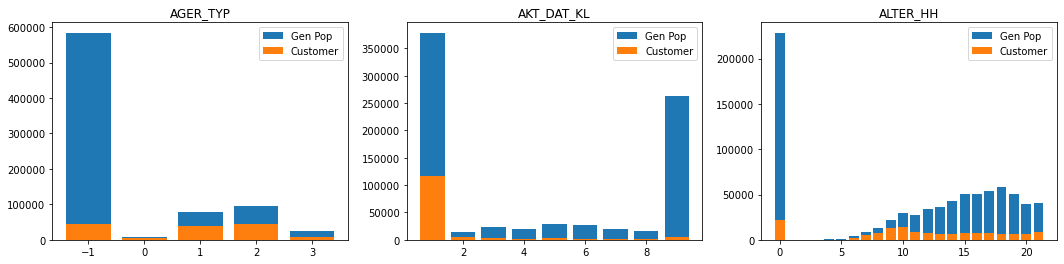

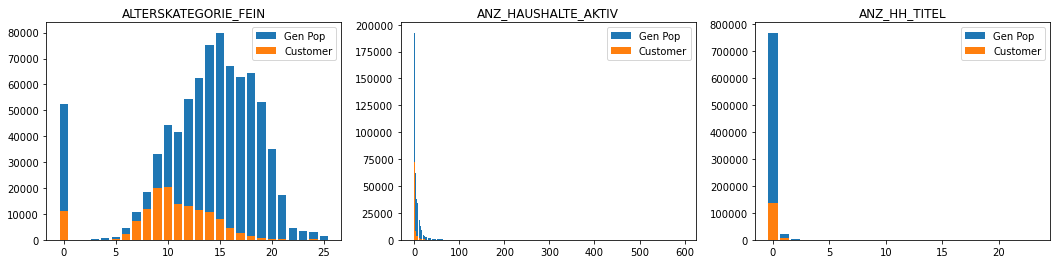

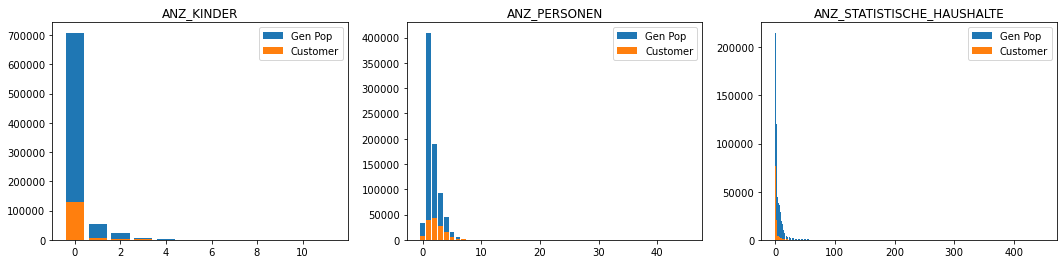

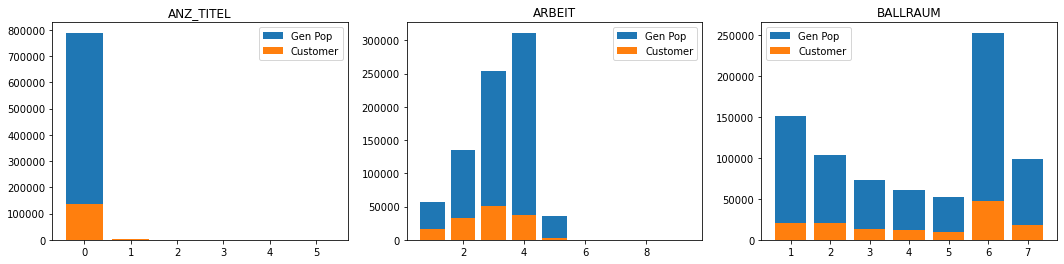

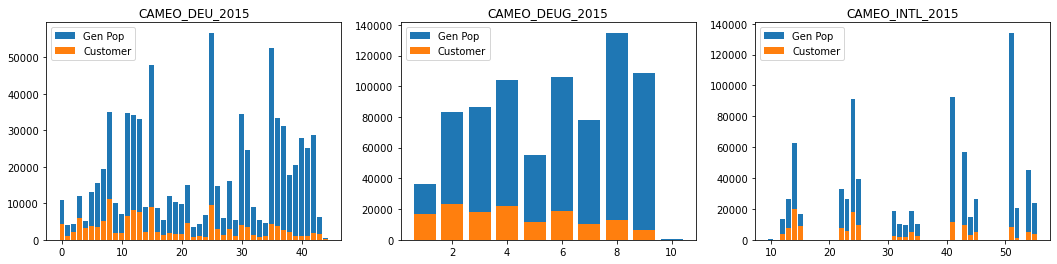

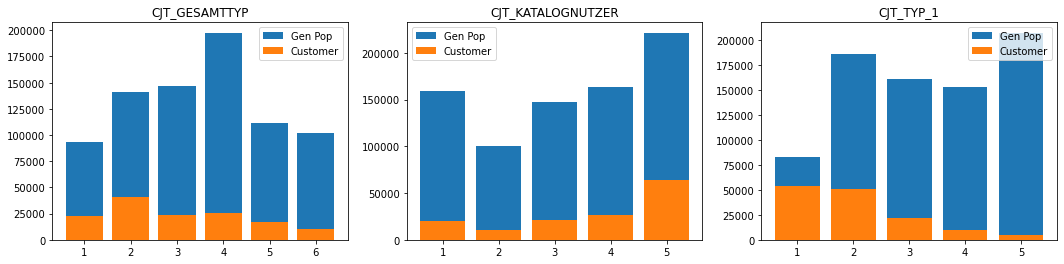

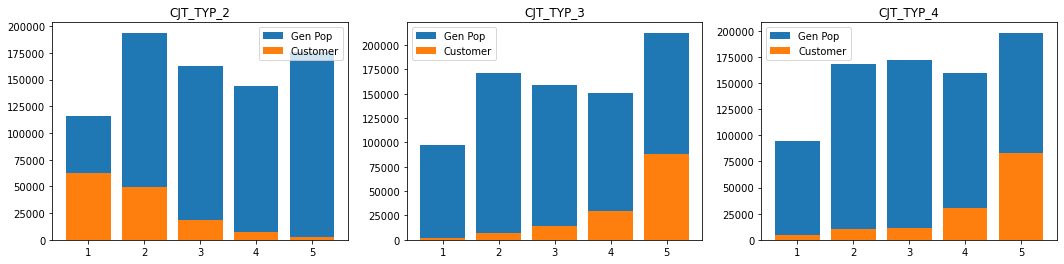

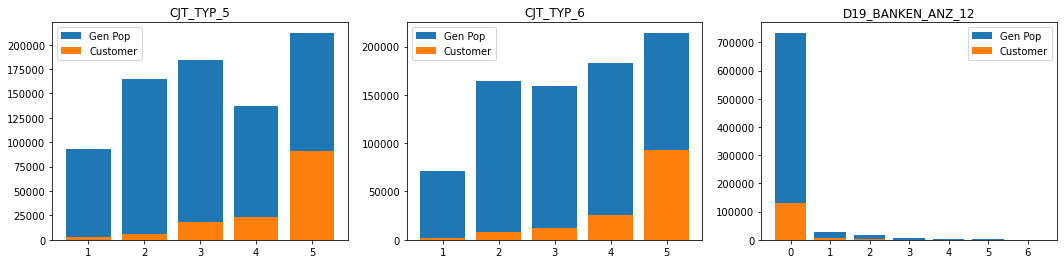

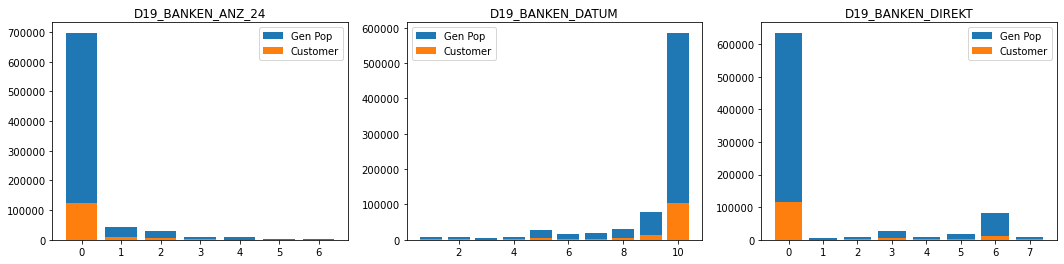

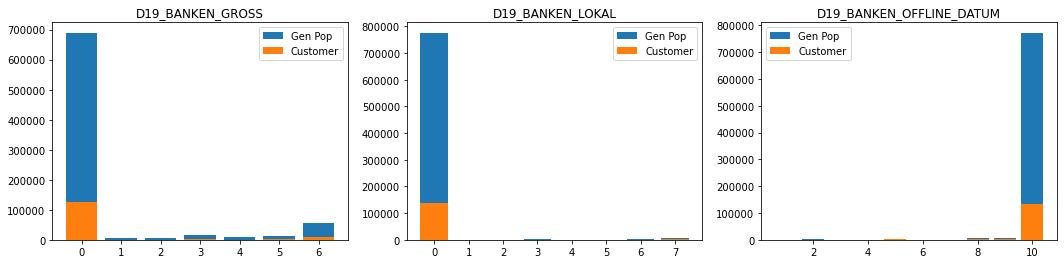

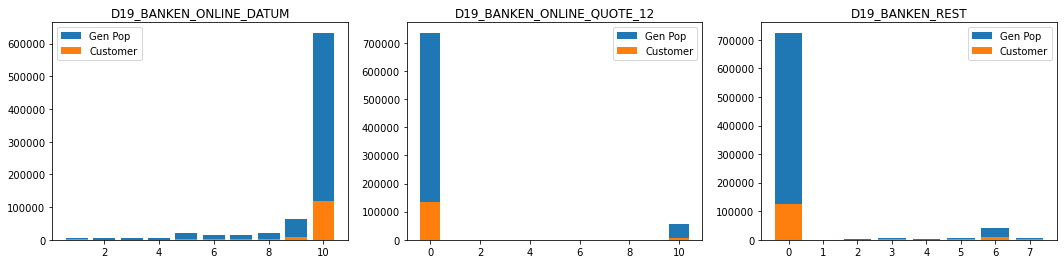

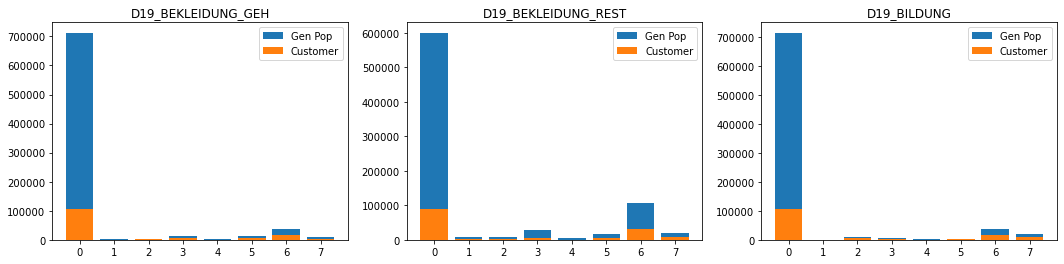

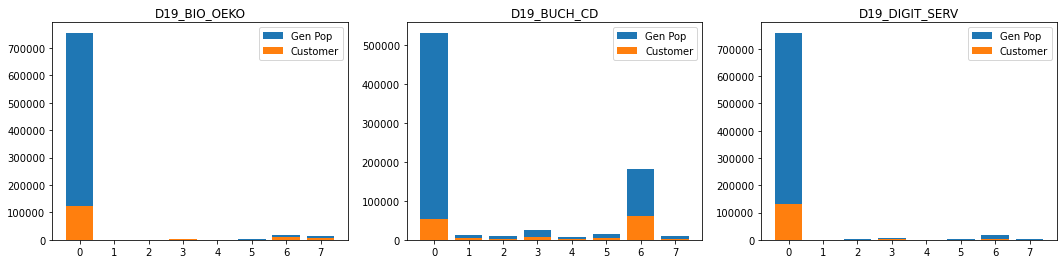

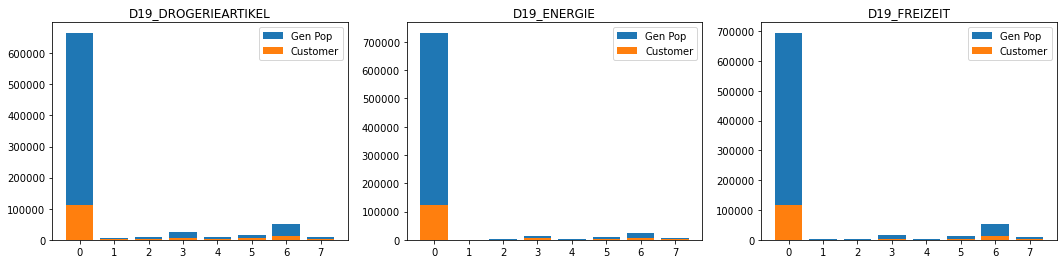

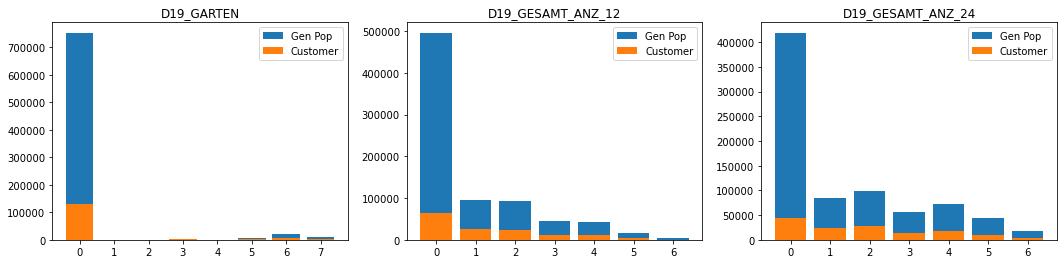

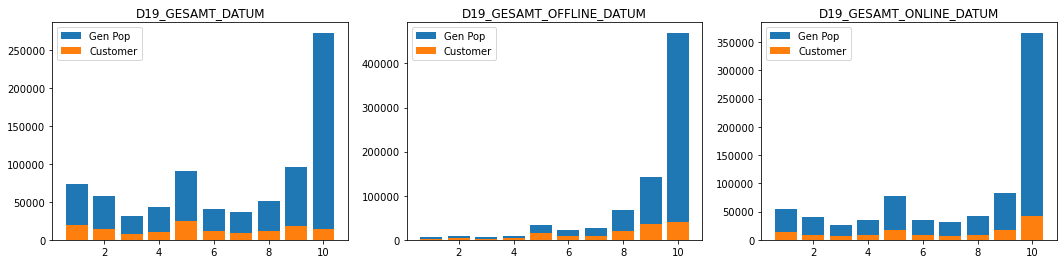

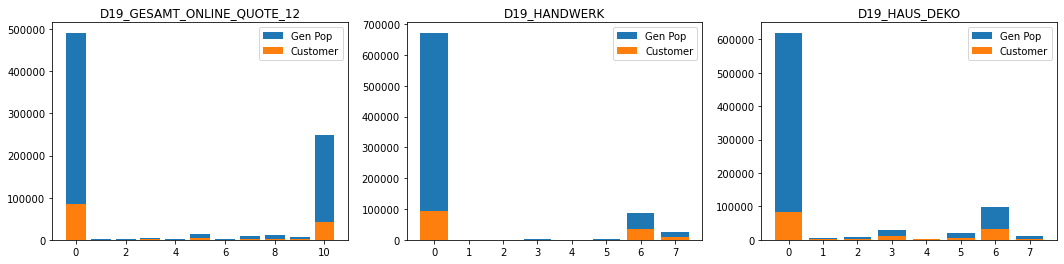

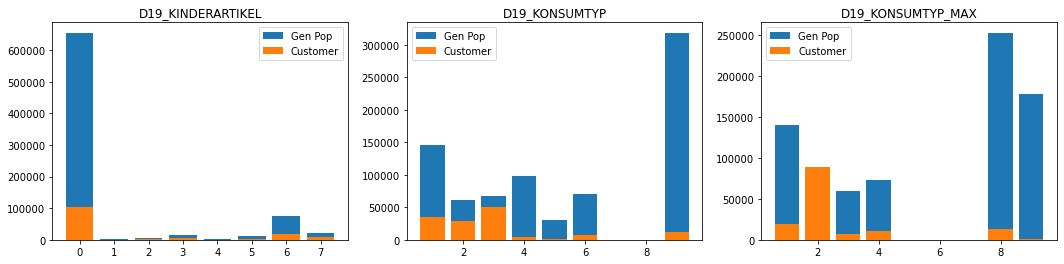

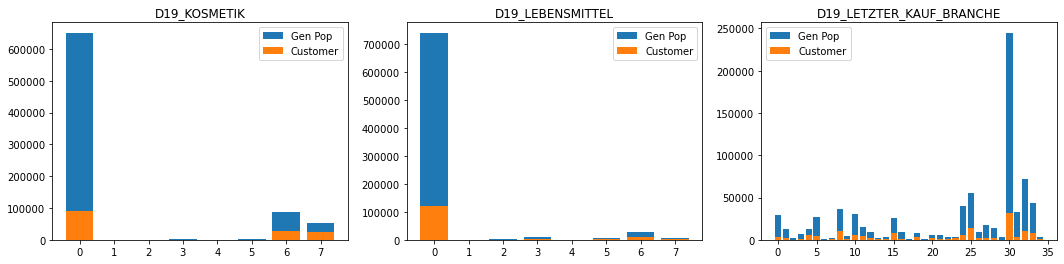

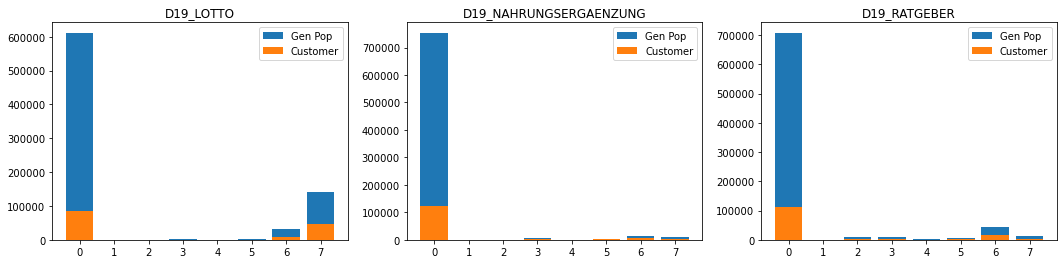

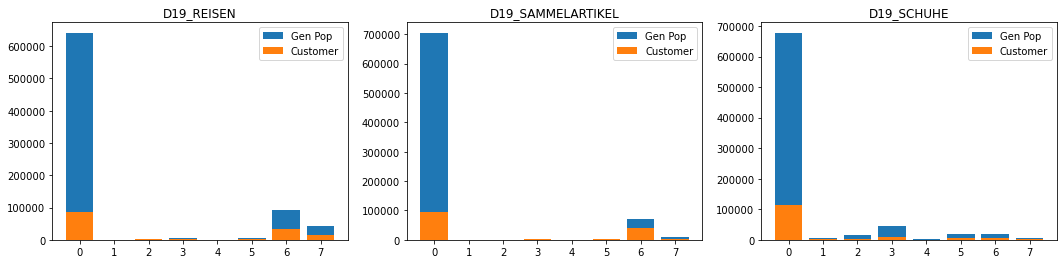

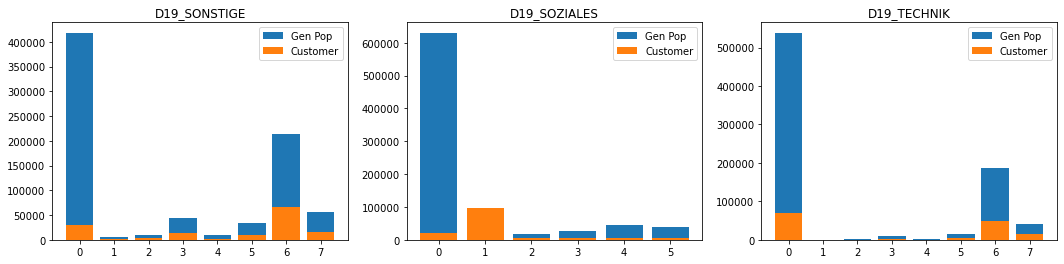

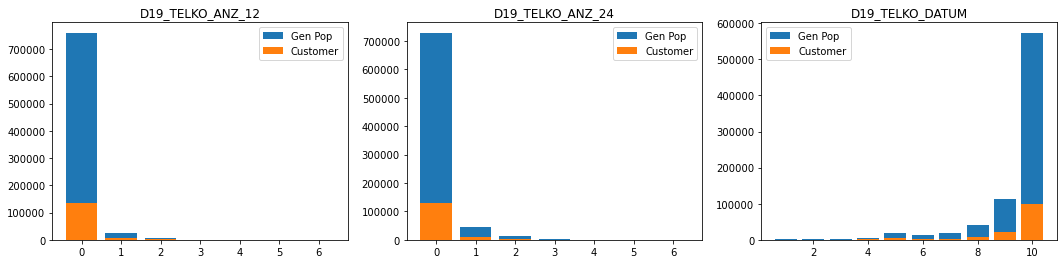

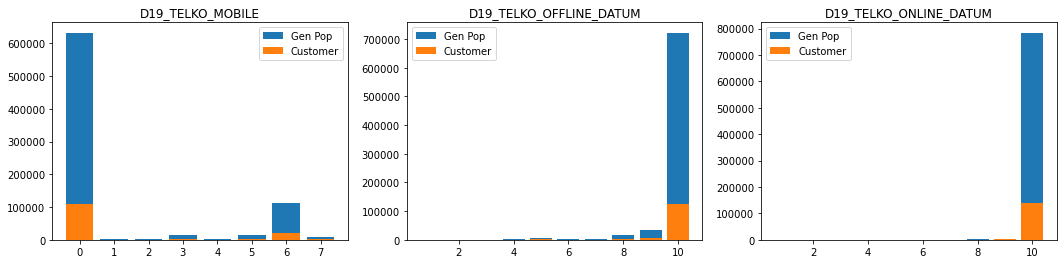

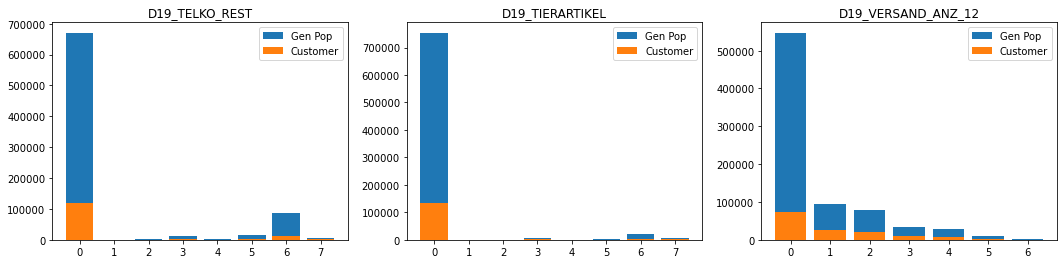

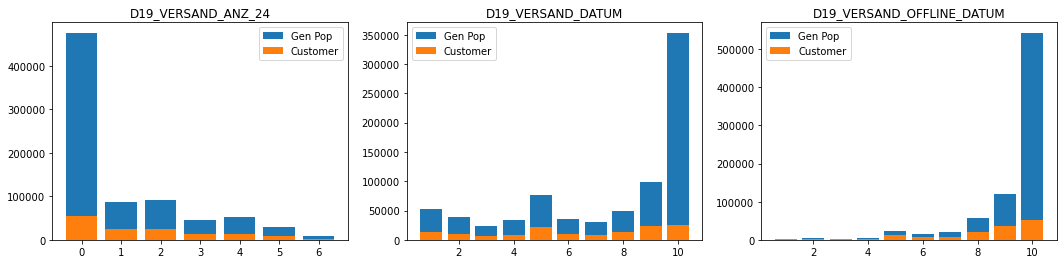

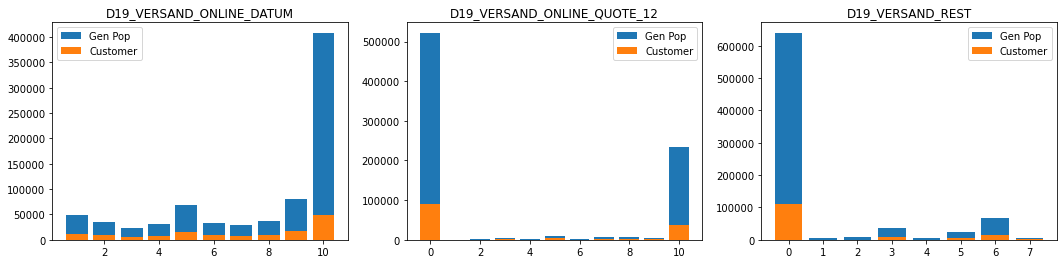

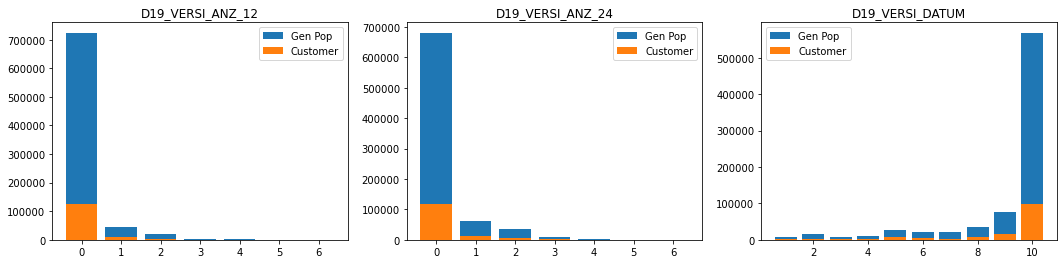

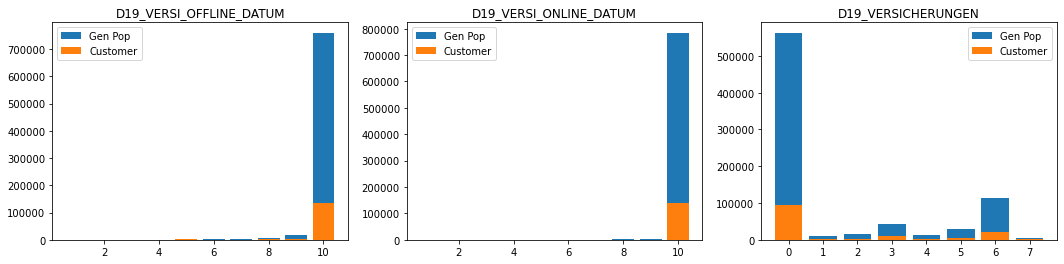

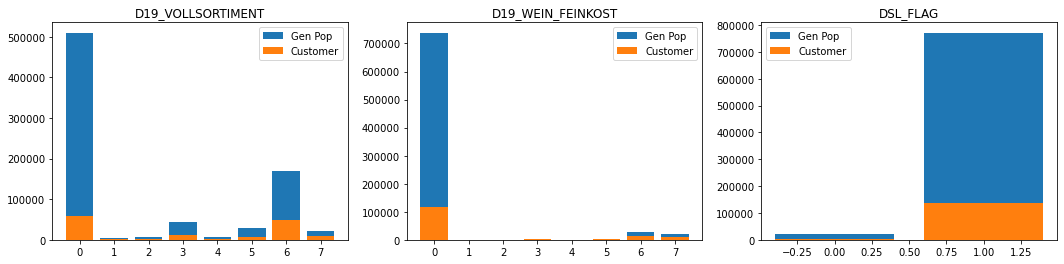

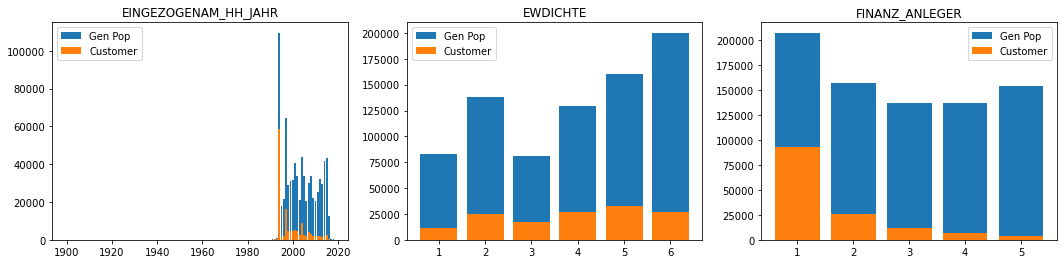

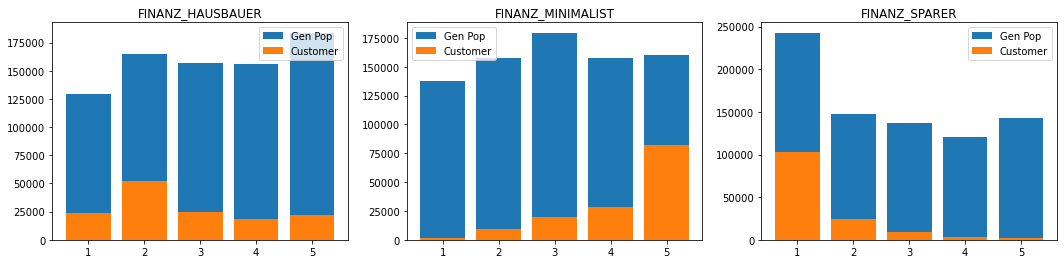

In [ ]:
# Observe all features of the General Population vs Customer datasets, all at once.
# Then pinpoint any marked differences using compare_distros() interactively int the code cell below.
def compare_distros(feature, relevant=False):
    '''Compare histograms a given feature from the General Population, as well as
       the Customer datasets. Do this both for the absolute data, and then the
       standardized form.
    Args:    feature (String): name of the feature in question
    Returns: None
    '''
    interesting = []
    #global interesting
    if relevant:
        if feature not in interesting:
            interesting.append(feature)
        print(interesting)
        print("Added " + feature)
    else:
        print(interesting)

    f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    _ = ax1.set_title(feature + " Absolute")
    _ = plt.hist(genpop[feature], label='Gen Pop')
    _ = plt.hist(kunden[feature], label='Customer')
    _ = plt.legend(loc='upper right')

genpop_list = list(genpop.columns)
for col in range(0, genpop.shape[1]-3, 3):
    f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
    ax1 = f.add_subplot(131)
    _ = ax1.set_title(genpop_list[col])
    _ = plt.bar(genpop[genpop_list[col]].value_counts().sort_index().index, genpop[genpop_list[col]].value_counts().sort_index().values, label='Gen Pop')
    _ = plt.bar(kunden[genpop_list[col]].value_counts().sort_index().index, kunden[genpop_list[col]].value_counts().sort_index().values, label='Customer')
    _ = ax1.legend()

    #_ = sns.distplot(genpop[genpop_list[col]])
    ax2 = f.add_subplot(132)
    _ = ax2.set_title(genpop_list[col+1])
    _ = plt.bar(genpop[genpop_list[col+1]].value_counts().sort_index().index, genpop[genpop_list[col+1]].value_counts().sort_index().values, label='Gen Pop')
    _ = plt.bar(kunden[genpop_list[col+1]].value_counts().sort_index().index, kunden[genpop_list[col+1]].value_counts().sort_index().values, label='Customer')
    _ = ax2.legend()

    ax3 = f.add_subplot(133)
    _ = ax3.set_title(genpop_list[col+2])
    _ = plt.bar(genpop[genpop_list[col+2]].value_counts().sort_index().index, genpop[genpop_list[col+2]].value_counts().sort_index().values, label='Gen Pop')
    _ = plt.bar(kunden[genpop_list[col+2]].value_counts().sort_index().index, kunden[genpop_list[col+2]].value_counts().sort_index().values, label='Customer')
    _ = ax3.legend()
    _ = plt.show()

In [30]:
# Play around with the column names to visualize the similarities, and differences.
_ = interact(compare_distros, feature=widgets.Dropdown(options=list(genpop.columns), description='Feature'), relevant=widgets.Checkbox(description='Add to List'))

interactive(children=(Dropdown(description='Feature', options=('AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKA…

The main differences after visualizing feature distributions occur for the following columns:`['ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_KONSUMTYP_MAX', 'D19_SOZIALES', 'EINGEZOGENAM_HH_JAHR', 'EWDICHTE', 'FINANZ_ANLEGER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZTYP', 'GEBURTSJAHR', 'GEMEINDETYP', 'HEALTH_TYP', 'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_AUTOQUOT', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'MOBI_RASTER', 'MOBI_REGIO', 'PRAEGENDE_JUGENDJAHRE', 'RT_KEIN_ANREIZ', 'RT_UEBERGROESSE', 'SEMIO_DOM', 'SEMIO_KRIT', 'SEMIO_SOZ', 'SEMIO_VERT', 'SHOPPER_TYP', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'ANREDE_KZ']`

What follows is a brief description of how the customer distribution of each of the features of interest distinguishes itself from the general population:
- **ALTER_HH, GEBURTSJAHR:** Whereas the general population is crowded by post-war individuals ( values 10 or higher in **ALTER_HH** ), the customers' distribution appears more uniform and slightly modal around value 10, indicating people born between 1925 and 1960 approximately. The same pattern is revealed by the **GEBURTSJAHR** (birth year).
- **ALTERSKATEGORIE_FEIN:** Customers appear more tightly packed around value 10.
- **CAMEO_DEU_2015:** Customers distributed uniformly while the general population has more representation by "Powershopping Families", "Coffee Riders", and "Multicultural".
- **CAMEO_DEUG_2015 & CAMEO_INTL_2015:** Customer distributions are more uniform across categories.
- **CJT_GESAMTTYP, CJT_TYP_1, and CJT_TYP_2:** Decreasing amount of customers in the higher values.
- **CJT_TYP_3, CJT_TYP_4, CJT_TYP_5, and CJT_TYP_6 :** Increasing amount of customers in the higher values.
- **D19_KONSUMTYP_MAX:** Most customers are of **_Versatile_** consumption type.
- **D19_SOZIALES:** Customers mostly of category value "1".
- **EINGEZOGENAM_HH_JAHR:** Most customers 'Eingezogen' i.e., moved in mostly in the 1990's, and decreasingly so with time.
- **EWDICHTE, GEMEINDETYP, HEALTH_TYP, HH_EINKOMMEN_SCORE:** Uniform across population densities, type of communities, health typology, income score.
- **FINANZ_ANLEGER, FINANZ_MINIMALIST, FINANZ_SPARER, FINANZTYP:** Very highly involved in saving and investing.
- **INNENSTADT:** Customers live mostly between 10 and 30 Km away from the city centre.
- **KBA05_AUTOQUOT:** Customers have a slightly higher share of cars per household.
- **LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB:** Customers come from varied income backgrounds, but are mostly advanced age individuals.
- **LP_STATUS_FEIN, LP_STATUS_GROB:** Other things being equal, customers tend to be classified as top earners.
- **MOBI_RASTER, MOBI_REGIO:** Customers' mobility is uniform or low inclined.
- **PRAEGENDE_JUGENDJAHRE:** Customers come mostly from the 50's and 60's dominating youth movements. 
- **RT_KEIN_ANREIZ, RT_UEBERGROESSE:** Customers' trends on these two features are opposite of the general population.
- **SEMIO_DOM, SEMIO_KRIT, SEMIO_SOZ, and SEMIO_VERT:** Customer personality affinity distributions are markedly different from the general population.
- **SHOPPER_TYP:** Uniformly distributed.
- **VK_DHT4A, VK_DISTANZ, and VK_ZG11:** Customer distributions markedly different from general population.
- **ANREDE_KZ:** Slightly higher proportion of males to females in the customers makeup.
<br/><br/>
<font color='blue'>The overall characterization of the differences in features' distributions of the customer and general population datasets shows customers to be older, sedentary, of versatile consumption type, heavily into saving or investing money, suburban, with multiple cars in household, mostly top earners of advanced age, and with a slightly heavier male presence. </font>

<br/><br/>
## Principal Component Analysis

We'd like to reduce the dimensionality of our data without sacrificing much of the information contained in it. With PCA we can map original data features onto a space of new features sorted by retained variance, i.e., the principal components. These principal components are linear combinations of the original features. But they are linearly independent and account for the largest variability in the data. Briefly, we want fewer new features, but the few good ones. The ones with the most variance!

We’ll use sklearn's IncrementalPCA class for linear dimensionality reduction. We'll first fit an IncrementalPCA object with the totality of the features to familiarize ourselves with the pattern in retained variance. We'll then examine the fraction of variance explained by each principal component, and plot the cumulative values using the function  **`show_pca(coeffs, given_PCA, Features=10)`** in the code cell below. This function allows us to visualize the feature weights of any of the PCA components to try and understand their meaning in terms of the original data features. The auxiliary function **`pca_features(given_PCA, Features=5)`** returns the same information as numbers.

In [31]:
def pca_features(given_PCA, Features=5):
    '''For a given PCA component, out of N_COMPONENTS=355, return the main features and weights.
    Args:    given_PCA(integer, range 0 to N_COMPONENTS=355): The PCA component to analyze
             Features(integer, default 5): Number of features to return, from largest to smallest
                                             in an absolute value sense.
    Returns: (DataFrame): List of Features and Weights with most impact on the given_PCA
    '''
    cols = genpop.columns.values
    ipca_df = DataFrame(ipca_explore.components_).iloc[given_PCA]
    komponent = DataFrame(list(zip(cols, ipca_df)), columns=['Original Data Feature', 'Weights'])
    komponent['Absolute']=komponent['Weights'].apply(lambda x: np.abs(x))
    return komponent.sort_values('Absolute', ascending=False).head(Features)
    
def show_pca(coeffs, given_PCA, Features=10):
    '''For a given PCA component, out of N_COMPONENTS=355, show its makeup in terms of feature weights,
    as well as the cumulative variance retained by all PCA components up to and including this one.
    The feature weights (positive or negative), are sorted by absolute value and displayed interactively.
    A second plot showing the cumulative variance retained vs. number of components is shown alongside.
    Args:    coeffs(DataFrame): Feature coefficients for each PCA component. 
             given_PCA(integer, range 0 to N_COMPONENTS=355): The PCA component to analyze
             Features(integer, default 10): Number of features to display, from largest to smallest
                                             in an absolute value sense.
    Returns: None
    '''
    
    show_features = pca_features(given_PCA, Features)
    f = plt.figure(figsize=(2*FIG_WIDTH/3, 2*FIG_HEIGHT))
    ax1 = f.add_subplot(211)
    ax1 = plt.suptitle("Use the sliders to change Component and Number of Features", fontsize=20)
    ax1 = sns.barplot(data=show_features, y='Original Data Feature', x='Weights', palette="Blues_d")
    ax1.set(xlabel=None)
    ax1.set(ylabel=None)
    _ = plt.ylabel('Original Data Features', fontsize=20)
    _ = plt.xlabel('Feature Weights in PCA Component', fontsize=20)
    ax1.set_title("PCA Component {} Makeup @ {}% Cumulative Retained Variance".\
                 format(given_PCA, round(100 * coeffs.explained_variance_ratio_.cumsum()[given_PCA]     ) ),\
                 fontsize=20)
    ax2 = f.add_subplot(212)
    _ = plt.title("Cumulative Retained Variance", fontsize=20)
    _ = plt.ylabel('Retained variance', fontsize=20)
    _ = plt.xlabel('PCA Components', fontsize=20)
    _ = plt.plot(np.cumsum(coeffs.explained_variance_ratio_))

In [32]:
# Apply PCA to the General Population data.
N_COMPONENTS=355 # Features - 1
ipca_explore = IncrementalPCA(n_components=N_COMPONENTS, batch_size=N_COMPONENTS)
_ = ipca_explore.fit_transform(scaled_genpop)

In [33]:
_ = interact(show_pca, coeffs=fixed(ipca_explore),
             given_PCA=widgets.IntSlider(min=0, max=N_COMPONENTS-1, step=1, value=10),
             Features=widgets.IntSlider(min=5, max=50, step=1, value=10))

interactive(children=(IntSlider(value=10, description='given_PCA', max=354), IntSlider(value=10, description='…

Playing with the slider in the code cell above, the PCA analysis reveals that we can retain 90% of the variance in the data, if we keep 175 'Component Space Features'. Hence, we can reduce dimensionality by about 50% at the cost of discarding just 10% of the uncorrelated information in the data, a reasonable trade-off.

The interactive sliders on the graph above can be used to produce a detailed view of the feature weights associated with a given PCA component. The weights, whether positive, negative, large, or small, can be used to interpret their meaning in feature space. Here is a breakdown of the top three PCA Components:

**`PCA_0`** Results from `pca_features(0, 5)`

| Feature         | Weight      | Interpretation |
|-----------------|-------------|:---------------|
| MOBI_REGIO      | <span style='color:green'>+13.2% </span> | very low mobility |
| KBA13_ANTG1     | <span style='color:green'>+12.9% </span> | high share of some type of ANTG1?? cars within the zip code |
| PLZ8_ANTG1      | <span style='color:green'>+12.8% </span> | very high share of 1-2 family houses in zip Code |
| KBA13_ANTG3     | <span style='color:red'>  -12.8% </span> | low share of some type of ANTG3?? cars in the zip code  |
| PLZ8_ANTG3      | <span style='color:red'>  -12.8% </span> | low share of 6-10 family houses in zip code |

**`PCA_1`**  Results from `pca_features(1, 5)`

| Feature         | Weight      | Interpretation |
|-----------------|-------------|:---------------|
| KBA05_SEG6      | <span style='color:green'>+17.9% </span> | some share of upper class cars (BMW 7er etc.) in the microcell |
| KBA05_KRSOBER   | <span style='color:green'>+16.4% </span> | above average share of upper class cars (referred to the county average) |
| KBA05_KRSVAN    | <span style='color:green'>+16.1% </span> | above average share of vans (referred to the county average) |
| KBA05_KRSZUL    | <span style='color:green'>+16.0% </span> | above average share of newbuilt cars (referred to the county average) |
| KBA05_ANHANG    | <span style='color:green'>+15.4% </span> | very many share of trailers in the microcell |

**`PCA_2`**  Results from `pca_features(2, 5)`

| Feature         | Weight      | Interpretation |
|-----------------|-------------|:---------------|
| CJT_TYP_2               | <span style='color:green'>+15.9% </span> | customer journey typology 2 ?? |
| PRAEGENDE_JUGENDJAHRE   | <span style='color:green'>+15.9% </span> | hard to interpret which slot in this categorical variable: dominating movement in the person's youth (avantgarde or mainstream) |
| ONLINE_AFFINITAET       | <span style='color:green'>+15.5% </span> | very high online affinity |
| CJT_TYP_1               | <span style='color:green'>+15.4% </span> | customer journey typology 1 ?? |
| FINANZ_SPARER           | <span style='color:green'>+15.1% </span> | very low financial typology: money saver |

We now re-fit an IncrementalPCA instance with only 175 components, and perform the transformation to a reduced dimensionality dataset, namely **`gp_PCA`**, as shown in the code cell below. The code cell also shows a portion of the PCA components in terms of the original features' weights, and also a portion of the transformed General Population dataset.

In [34]:
# Re-apply PCA, selecting for number of components to retain.
REDUCED_DIM = 175
ipca = IncrementalPCA(n_components=REDUCED_DIM, batch_size=REDUCED_DIM)

_ = ipca.fit(scaled_genpop)
gp_PCA = ipca.transform(scaled_genpop)

# List the PCA components
print("\n\nPCA Components {}".format(DataFrame(ipca.components_).shape))
PCA_components = DataFrame(ipca.components_, columns = genpop.columns.values)
PCA_components.index =  ['PCA_{}'.format(i) for i in range(len(ipca.components_))]
PCA_components.head()

# List the PCA transformed General Population dataset.
print("\n\nReduced Dimensionality General Population Dataset {}".format(DataFrame(gp_PCA).shape))
gp_PCA_df = DataFrame(gp_PCA)
gp_PCA_df.head()



PCA Components (175, 356)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,K



Reduced Dimensionality General Population Dataset (791957, 175)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174
0,-4.598389,-2.182335,2.921376,4.605819,5.504181,-0.771564,2.225279,-2.310891,1.172506,0.049666,2.332964,-1.758044,2.214359,3.691997,2.120194,0.147120,1.517999,-0.384936,1.154865,0.960298,0.455864,0.310750,0.460363,4.096043,1.033166,-0.724589,1.671194,-0.489861,-0.966425,-0.954109,-2.946724,-0.082352,1.080948,-0.466990,0.434862,0.225976,0.609050,-2.100848,2.378747,1.141521,-0.680520,-0.519989,0.407289,0.181155,1.612187,0.622504,-1.582186,-1.023228,-0.463330,0.645203,0.135949,-1.414277,1.530032,0.819434,-1.747150,0.442659,-0.265340,-0.383027,-0.264903,0.148162,-1.433547,0.241105,-1.790010,-1.650992,-0.883348,-0.214290,0.772071,-1.444497,9.593383,3.508618,-3.423105,-0.300419,-0.178930,-0.368780,-0.216492,0.230098,0.339966,0.763789,-0.423339,-0.610522,0.428575,0.681353,-0.311814,0.842345,1.200528,0.575493,-0.125514,-0.357427,-0.644124,-0.863515,1.065637,-1.534944,1.133627,1.932928,1.945666,-1.104460,0.691144,0.373472,-0.448669,-1.235281,-0.853897,0.366574,-0.114014,0.480158,0.155729,-1.082815,0.714848,-0.480358,-0.404159,-0.258162,0.148921,0.664842,-0.128220,0.215408,-0.458898,0.086795,0.965202,0.588860,0.741940,-0.132661,-0.119981,-0.475074,0.321566,0.122209,-0.882768,-0.337102,-0.469324,0.188360,0.643169,0.138439,-0.798513,-1.303392,-0.176470,-0.360837,2.212529,0.398269,-1.018554,-1.206101,0.300165,0.826019,-0.271938,-0.011980,0.459212,0.989487,-0.257683,0.236621,0.372859,1.146002,-0.242479,-0.269266,-0.095076,-0.602676,0.429826,0.252479,1.625655,0.886011,-1.400147,0.228713,-0.116606,0.961835,0.418730,1.912411,0.926325,0.559420,1.498985,-1.101822,-0.977157,-0.717867,-0.213589,1.206516,0.729439,0.008840,-0.237586,0.130406,0.434565
1,0.126645,-0.326166,-1.570658,3.797006,3.807972,-3.565509,3.825851,2.822060,-0.884121,-0.250247,0.336190,1.958490,0.976708,-2.682124,-0.755284,2.356473,-0.613057,1.867290,2.419900,0.098845,1.666792,-1.095318,-0.508311,-0.659621,-1.171773,0.700446,-1.131049,-0.870266,0.904944,-0.174481,0.695210,-0.606813,-2.631949,-0.909208,0.641499,0.227507,-0.060638,0.954285,0.889534,-0.919615,0.084170,-2.956461,-0.321457,-0.177952,-1.872699,0.873794,-0.442445,-0.327608,-0.916600,0.190640,-0.495627,-0.034979,0.598585,0.308951,-0.576022,0.414962,0.300790,-0.649448,-0.632463,1.934771,1.763269,0.213635,0.175080,-1.098830,0.343527,0.224097,-0.434616,-0.135705,-0.615412,0.148629,-0.640747,0.981039,-0.533945,-0.000632,-0.312475,1.166920,-0.260168,-0.508789,1.665746,1.071541,0.492919,-0.916748,-0.711124,-0.441614,-0.359983,0.079455,0.365749,0.059851,1.288232,0.601541,-0.633164,-0.966482,-0.597217,0.180645,0.128120,0.108840,-0.037192,0.141405,0.598560,-0.260693,-0.771652,0.072814,-0.188891,0.251184,-0.797123,0.038772,-1.210553,0.456682,0.539203,0.722104,-0.411834,-0.076412,-0.228395,-0.279349,0.651353,0.253559,0.535482,-1.262060,-0.287919,-0.181731,-0.555911,-0.339215,-0.370530,-0.334889,0.708431,-1.289079,0.020720,-0.904329,-1.128396,1.931172,2.210924,-0.273177,0.377058,-0.024722,0.488483,0.602993,1.646050,0.752044,0.203114,0.355222,-0.867996,-0.644341,-0.297443,-0.206500,0.108637,-0.090461,0.562506,-1.020726,0.243292,0.448455,0.344862,0.037433,0.261365,0.422721,-0.064031,0.619308,0.712386,0.476756,-0.724216,0.395224,-0.259716,-0.270526,-0.930649,0.687025,1.072660,-0.685359,0.502467,1.333001,0.219715,0.757349,-0.038527,-0.318580,0.444475,-0.729419,-0.031756
2,3.618514,2.189880,-6.505708,1.213434,2.621361,0.661588,0.969566,-1.824516,-3.286562,0.

<br/><br/>
## K-Means Clustering

We now reduce the complexity of our analysis by applying clustering to the PCA transformed General Population dataset. The function **`centroid_inertias(df, kmax=20)`** in the code cell below, loops through different numbers of clusters to observe the effect on the average centroid distance. We'd like to choose a value of **`k`** such that this distance is low, but not so low that we end up with too thinly populated clusters. If we select a good value for **`k`**, points in a cluster would be close to each other, the average centroid distance would be low, and we'd have enough points in each cluster to achieve effective segmentation of the data.

k=2, k=4, k=6, k=8, k=10, k=12, k=14, k=16, k=18, 


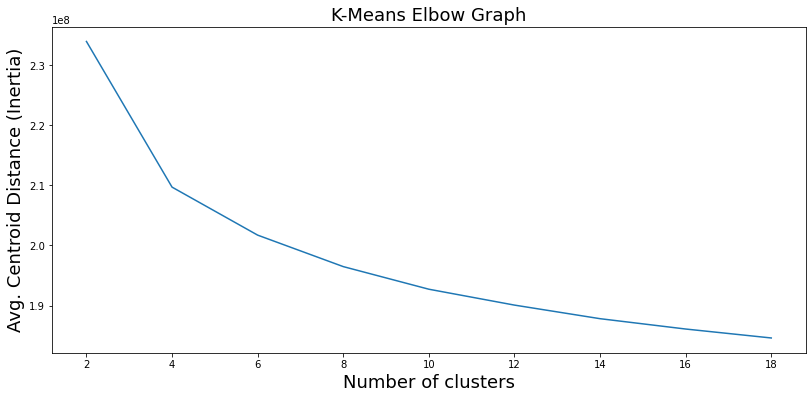

In [35]:
RANDOM_STATE = 403
def centroid_inertias(df, kmax=20):
    '''Iterate several cluster densities to examine the resulting reduction in average
    centroid distance.
    Args:    df (DataFrame): General Population, Customers, or Mailout datasets.
             kmax(Integer): Maximum number of clusters to try.
    Returns: None
    '''
    inertias = []
    for k in range(2, kmax, 2):
        print('k={}, '.format(k), end='')
        clusters = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        clusters.fit(df)
        inertias.append(clusters.inertia_)
    return inertias

inert = centroid_inertias(gp_PCA_df, kmax=20)
print("")
f = plt.figure(figsize=(FIG_WIDTH*.75, FIG_HEIGHT*.75))
x_range = [k for k in range(2, 20, 2)]
_ = plt.xticks(x_range)
_ = plt.plot(x_range, inert)
_ = plt.title('K-Means Elbow Graph', fontsize=18)
_ = plt.xlabel('Number of clusters', fontsize=18)
_ = plt.ylabel('Avg. Centroid Distance (Inertia)', fontsize=18)
_ = plt.show()

The graph above shows the average cluster centroid distance plotted against the number of clusters attempted. There is no clear elbow, but the rate at which the average centroid distance decreases is much less sharp beyond, say, **`k = 10`**. Further reduction with higher **`k`** is only marginally better. 

The code cell below performs K-Means clustering on the General Population with 10 clusters. This code cell also carries out all the prior transformation steps on the Customer dataset that were performed on the General Population. The actual Clusters are also shown in terms of Principal Components.

In order to make meaningful comparisons, we take into account the different sizes of the datasets (GenPop=791957 vs. Customers=140889). The histograms below show the absolute and relative number of points per cluster in each dataset. Additionally, the bottom two graphs depict the main clusters for each of the datasets sorted by their density of points.

KMeans Clusters (10, 175)


,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27,PCA_28,PCA_29,PCA_30,PCA_31,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50,PCA_51,PCA_52,PCA_53,PCA_54,PCA_55,PCA_56,PCA_57,PCA_58,PCA_59,PCA_60,PCA_61,PCA_62,PCA_63,PCA_64,PCA_65,PCA_66,PCA_67,PCA_68,PCA_69,PCA_70,PCA_71,PCA_72,PCA_73,PCA_74,PCA_75,PCA_76,PCA_77,PCA_78,PCA_79,PCA_80,PCA_81,PCA_82,PCA_83,PCA_84,PCA_85,PCA_86,PCA_87,PCA_88,PCA_89,PCA_90,PCA_91,PCA_92,PCA_93,PCA_94,PCA_95,PCA_96,PCA_97,PCA_98,PCA_99,PCA_100,PCA_101,PCA_102,PCA_103,PCA_104,PCA_105,PCA_106,PCA_107,PCA_108,PCA_109,PCA_110,PCA_111,PCA_112,PCA_113,PCA_114,PCA_115,PCA_116,PCA_117,PCA_118,PCA_119,PCA_120,PCA_121,PCA_122,PCA_123,PCA_124,PCA_125,PCA_126,PCA_127,PCA_128,PCA_129,PCA_130,PCA_131,PCA_132,PCA_133,PCA_134,PCA_135,PCA_136,PCA_137,PCA_138,PCA_139,PCA_140,PCA_141,PCA_142,PCA_143,PCA_144,PCA_145,PCA_146,PCA_147,PCA_148,PCA_149,PCA_150,PCA_151,PCA_152,PCA_153,PCA_154,PCA_155,PCA_156,PCA_157,PCA_158,PCA_159,PCA_160,PCA_161,PCA_162,PCA_163,PCA_164,PCA_165,PCA_166,PCA_167,PCA_168,PCA_169,PCA_170,PCA_171,PCA_172,PCA_173,PCA_174
Cluster_0,7.739853,0.492747,3.063299,0.044745,-1.207390,0.541216,0.041947,-0.236067,0.192750,0.191449,0.181011,0.251556,0.184419,0.033956,-0.161984,0.011292,0.020401,-0.048664,-0.095317,-0.108903,-0.077506,0.003932,-0.121148,0.021116,-0.081168,-0.007727,0.217800,0.105974,0.077649,0.014316,-0.124745,0.378897,-0.078980,-0.215286,-0.195392,0.180841,0.057134,-0.107237,-0.072547,0.033845,0.095411,-0.047175,0.028720,0.011447,0.026407,0.039828,0.010856,0.021732,0.040399,-0.008715,-0.028793,-0.036602,0.051472,0.028605,-0.016496,-0.105042,0.036072,-0.024983,0.035675,-0.015886,0.053142,-0.019423,0.038565,0.015632,-0.056069,0.065940,-0.044810,-0.042413,-0.009642,-0.026747,-0.024400,-0.030788,0.000514,0.030127,-0.035796,0.019563,0.001661,0.012975,-0.012558,-0.004043,0.008487,-0.010149,-0.023982,0.017450,0.009351,0.038722,0.014797,-0.004281,0.023368,-0.016647,-0.005628,0.066345,-0.001296,0.005024,-0.011607,-0.048999,0.014243,0.012788,0.002255,-0.031714,0.036561,-0.013398,-0.018905,-0.010561,-0.001338,-0.002172,-0.008864,0.020878,0.014595,0.021327,0.026491,-0.006339,-0.007192,-0.016251,0.006214,0.023655,-0.026426,0.015927,-0.030606,-0.035485,0.018728,0.004565,-0.017739,0.006705,0.000653,-0.016909,0.009649,-0.001586,0.009998,0.001517,-0.004668,-0.000762,0.007596,0.005531,0.005757,0.008646,0.011500,0.035133,-0.023901,-0.000960,0.001499,0.037518,-0.008937,-0.004259,0.003100,-0.006391,-0.009157,-0.010872,-0.020072,0.014299,0.011932,0.016332,-0.003309,0.009256,0.007027,0.008064,0.011919,-0.028951,-0.015910,0.026940,0.021649,-0.013097,0.009600,-0.014523,0.001301,0.003058,0.029288,-0.023567,-0.006827,-0.025451,-0.022704,0.030797,0.015891,0.019120,0.020966
Cluster_1,-7.363683,-2.810882,2.393313,1.622369,0.053393,0.654501,-0.582189,-1.380173,0.196098,1.337646,-0.328749,0.326582,0.018073,-0.151326,-0.120894,0.232990,0.019212,-0.096457,-0.248682,-0.205324,0.090344,0.015085,-0.100707,-0.201106,0.154962,0.048911,0.207754,-0.023931,0.159741,0.001460,-0.032425,0.232132,0.058175,0.056773,-0.056328,-0.051465,-0.049534,-0.064063,0.087118,-0.043081,-0.138291,0.020437,-0.066451,0.029762,0.112732,-0.038649,-0.063407,-0.047625,0.053500,-0.031495,-0.167821,-0.058724,-0.061108,0.050536,-0.073281,0.050981,0.013298,0.033157,0.014209,0.048254,0.007526,0.041247,0.028138,0.049088,0.095275,0.010382,-0.100739,0.034350,-0.002727,-0.023133,-0.036568,-0.050164,-0.001345,0.011190,0.022346,0.042525,0.017257,0.059623,0.004721,0.074070,0.081087,0.009229,0.016170,-0.029621,-0.030302,0.023766,-0.029782,0.054706,0.005412,0.004819,0.010717,0.047289,0.101088,0.007457,-0.074717,0.000363,0.003148,0.009216,0.058490,0.019814,-0.031620,-0.015375,-0.071535,0.021448,-0.006356,-0.002555,-0.010447,-0.024471,0.009172,0.034560,

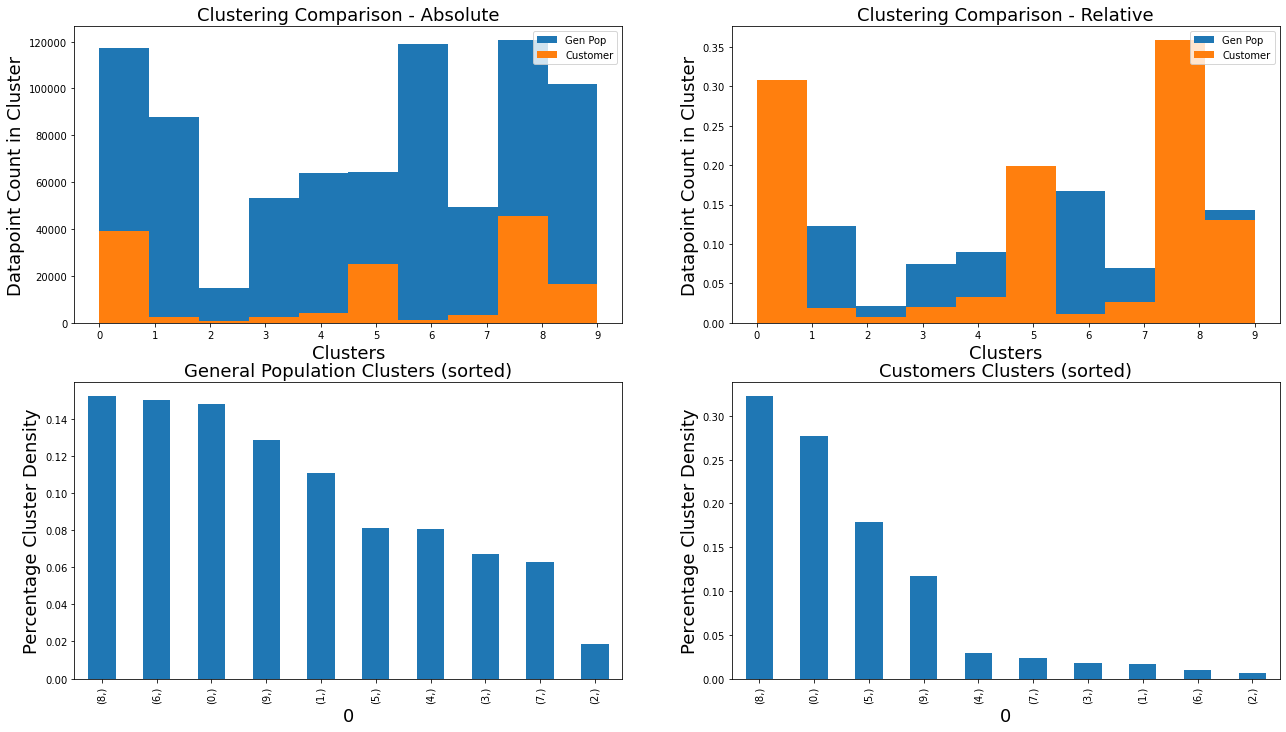

In [36]:
# Perform Clustering of the General Population
NUMBER_OF_CLUSTERS = 10
kmeans = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=RANDOM_STATE)
clusters = kmeans.fit(gp_PCA_df)
gp_clusters = clusters.predict(gp_PCA_df)

# Repeat all steps with the Customer Dataset
scaled_kunden = scaler.transform(kunden)   # Scale the data
kd_PCA = ipca.transform(scaled_kunden)     # Reduce Dimensionality
kd_clusters = clusters.predict(kd_PCA)     # Clustering

# Show the KMeans Clusters Centroid Locations in PCA component space.
print("KMeans Clusters {}".format(DataFrame(kmeans.cluster_centers_).shape))
KM_PCA = DataFrame(kmeans.cluster_centers_)
KM_PCA.index =  ['Cluster_{}'.format(i) for i in range(len(kmeans.cluster_centers_))]
KM_PCA.columns =  ['PCA_{}'.format(i) for i in range(len(ipca.components_))]
KM_PCA

# Visualize the clustering of both datasets with data point counts (absolute & relative)
# as well as cluster densities
f = plt.figure(figsize=(1.2*FIG_WIDTH, 3*FIG_HEIGHT/2))
ax1 = f.add_subplot(221)
_ = plt.title("Clustering Comparison - Absolute", fontsize=18)
_ = plt.hist(gp_clusters, label='Gen Pop', bins=NUMBER_OF_CLUSTERS)
_ = plt.hist(kd_clusters, label='Customer', bins=NUMBER_OF_CLUSTERS)
_ = plt.legend(loc='upper right')
_ = plt.xlabel('Clusters', fontsize=18)
_ = plt.xticks(range(NUMBER_OF_CLUSTERS))
_ = plt.ylabel('Datapoint Count in Cluster', fontsize=18)
ax2 = f.add_subplot(222)
_ = plt.title("Clustering Comparison - Relative", fontsize=18)
_ = plt.hist(gp_clusters, label='Gen Pop', bins=10, density=True)
_ = plt.hist(kd_clusters, label='Customer', bins=10, density=True)
_ = plt.legend(loc='upper right')
_ = plt.xlabel('Clusters', fontsize=18)
_ = plt.xticks(range(NUMBER_OF_CLUSTERS))
_ = plt.ylabel('Datapoint Count in Cluster', fontsize=18)
ax3 = f.add_subplot(223)
_ = plt.title("General Population Clusters (sorted)", fontsize=18)
_ = plt.xlabel('Clusters Sorted', fontsize=18)
_ = plt.ylabel('Percentage Cluster Density', fontsize=18)
_ = (DataFrame(gp_clusters).value_counts()/gp_clusters.shape[0]).plot(kind='bar')
ax4 = f.add_subplot(224)
_ = plt.title("Customers Clusters (sorted)", fontsize=18)
_ = plt.xlabel('Clusters Sorted', fontsize=18)
_ = plt.ylabel('Percentage Cluster Density', fontsize=18)
_ = (DataFrame(kd_clusters).value_counts()/kd_clusters.shape[0]).plot(kind='bar')

To understand what distinguishes a customer from the general population, we should look into the difference in the clusters' data point densities across the datasets. Some clusters exhibit overrepresentation with customers, indicating PCA components with features that best capture what it means to be a customer. Other clusters are underrepresented in the customer dataset, pointing to PCA components with features uncharacteristic of true customers. The function **`cluster_PCA_features(cluster, cutoff=5)`** in the code cell below, displays the most important features making up the PCA components with the most impact on a given cluster. We'll use this function to dissect the clusters and examine the meaning of over and underrepresentation in terms of the original dataset features.

In [37]:
def cluster_PCA_features(cluster, cutoff=5):
    '''Produce the main features linked with the top PCA Components associated with a Cluster.
    Args:    cluster(Integer): Cluster ID.
             cutoff(Integer): Number of features per PCA Component to retrieve.
    Returns: None
    '''
    centroids = KM_PCA.iloc[cluster]
    main_PCAs = centroids.argsort()[::-1][:cutoff]
    print('KM_PCA[\'Cluster_{}\'] Components :  ------------ Features ------------'.format(cluster))
    for comp in main_PCAs:
        pcalist = []
        print('                         PCA_{:<2}: '.format(comp), end='')
        features = DataFrame(list(zip(genpop.columns.values, DataFrame(ipca_explore.components_).iloc[comp])),\
                        columns=['Feature', 'Weights'])
        features['Absolute']=features['Weights'].apply(lambda x: np.abs(x))
        features = features.sort_values('Absolute', ascending=False).head(cutoff)
        for feature in features['Feature']:
            pcalist.append(feature)
        print(pcalist)

# Show how the clusters affect the General Population vs the Customer datasets,
# displaying the degree of over and under representation by customers in the clusters.
# Also, display the features linked with the main PCA components of each cluster.
gp_percents = 100*round(DataFrame(gp_clusters).value_counts()/gp_clusters.shape[0],4)
kd_percents = 100*round(DataFrame(kd_clusters).value_counts()/kd_clusters.shape[0],4)

# Quick display of the difference in cluster densities across datasets.
# There are three(3) clusters with customer overreresentation, the rest
# are underrepresented.
print("Cluster, Delta")
(kd_percents - gp_percents).sort_values(ascending=False)

# Get the clusters with overrepresentation with Customers (3)
surplus_rep = (kd_percents - gp_percents).sort_values(ascending=False)[:3]

# Get the main clusters underrepresenting the Customers (Examine top 4)
deficit_rep = (kd_percents - gp_percents).sort_values(ascending=False)[::-1][:4]

print('\033[92m' + "")
for i in range(len(surplus_rep)):
    indice = int(str(surplus_rep.index[i])[1:2])
    print("Cluster_{} overrepresents the Customer data by {}%".format( indice, round(surplus_rep.values[i],2) ))
    cluster_PCA_features(indice, 5)
print('\033[91m' + "")
for i in range(len(deficit_rep)):
    indice = int(str(deficit_rep.index[i])[1:2])
    print("Cluster_{} underrepresents the Customer data by {}%".format( indice, round(deficit_rep.values[i],2) ))
    cluster_PCA_features(indice, 5)

Cluster, Delta


8    17.03
0    12.86
5     9.81
9    -1.09
2    -1.21
7    -3.90
3    -4.89
4    -5.15
1    -9.43
6   -14.04
dtype: float64


Cluster_8 overrepresents the Customer data by 17.03%
KM_PCA['Cluster_8'] Components :  ------------ Features ------------
                         PCA_0 : ['MOBI_REGIO', 'KBA13_ANTG1', 'PLZ8_ANTG1', 'KBA13_ANTG3', 'PLZ8_ANTG3']
                         PCA_1 : ['KBA05_SEG6', 'KBA05_KRSOBER', 'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_ANHANG']
                         PCA_5 : ['KBA13_KW_0_60', 'KBA13_KW_61_120', 'KBA13_KMH_210', 'KBA13_BJ_2000', 'OST_WEST_KZ']
                         PCA_4 : ['FINANZ_ANLEGER', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'CJT_TYP_1', 'RT_KEIN_ANREIZ']
                         PCA_8 : ['KBA13_KMH_140_210', 'KBA13_CCM_1401_2500', 'KBA13_KW_30', 'KBA13_KRSZUL_NEU', 'KBA13_KMH_0_140']
Cluster_0 overrepresents the Customer data by 12.86%
KM_PCA['Cluster_0'] Components :  ------------ Features ------------
                         PCA_0 : ['MOBI_REGIO', 'KBA13_ANTG1', 'PLZ8_ANTG1', 'KBA13_ANTG3', 'PLZ8_ANTG3']
                         PCA_2 : ['CJT_TYP_2', 'PRAEGE

We can make use of our prior function **`compare_distros(feature)`** to deep dive into each of the features that resonate with customers to get a clear understanding of what the clusters are telling us as far as the distinction of customers against the general population. This is the same exercise that we performed in our prior step when we compared the datasets. But this time around, we are letting the data speak through its natural groupings, rather than our optical intuition through visualizations of histograms. Some of the components are both in the overrepresented as well as the underrepresented clusters. The overrepresented cluster components are `PCA_{0, 1, 2, 3, 4, 5, 7, 8, 9, 31}`, and the underrepresented components are `PCA_{2, 3, 4, 6, 7, 9, 10, 11, 13, 15, 19, 23}`. Strictly overrepresented components are `PCA_{0, 1, 8, 31}`, with those underrepresented being `PCA_{6, 10, 11, 13, 15, 19, 23}`.

We'll first look at the features that are overrepresented in the Customers dataset. These are from components `PCA_{0, 1, 8, 31}`. The features as explained in the ancillary EXCEL spreadsheet with discernible differences between general population and customers are listed here:
- **<span style='color:green'>MOBI_REGIO:</span>** As for moving patterns, the customers tend to be low in mobility.
- **<span style='color:green'>KBA13_ANTG1, KBA13_ANTG3:</span>** Unexplained features apparently related to the number of car owners in the zip code. This is rather uniform for the customers, as opposed to trending lower for the general population.
- **<span style='color:green'>LP_LEBENSPHASE_GROB:</span>** Customers tend to be single high income earners.
- **<span style='color:green'>LP_LEBENSPHASE_FEIN:</span>** Customers tend to be top earners of advanced or retirement age.
- **<span style='color:green'>EINGEZOGENAM_HH_JAHR:</span>** Customers tend to be characterized by having moved into their residence in the early 90's as opposed to the general population which shows a move from the late 90s onwards.
- **<span style='color:green'>FINANZ_HAUSBAUER:</span>** Customers show financial topology highly focused on the house. This tends to be low for the general population.


Conversely, the features that are underrepresented in the Customers' dataset are from components `PCA_{6, 10, 11, 13, 15, 19, 23}`. The features as explained in the ancillary EXCEL spreadsheet with discernible differences between general population and customers are listed here: 
- **<span style='color:red'>ANREDE_KZ, SEMIO_KAEM, SEMIO_VERT, SEMIO_DOM:</span>** Customers tend to be male, feisty, not dreamy and rather dominant.
- **<span style='color:red'>LP_FAMILIE_GROB:</span>** Non-Customers tend to be single.
- **<span style='color:red'>LP_LEBENSPHASE_FEIN:</span>** Customers tend to be top earners of advanced or retirement age.
- **<span style='color:red'>LP_LEBENSPHASE_GROB:</span>** Non-Customers tend to be single low income earners.

Other features which appear in both over- and underrepresented components, and which have noticeable differences between general population and customers are listed here:
- **MOBI_REGIO:** As for moving patterns, the customers tend to be low in mobility.
- **FINANZ_ANLEGER:** Customers are characterized by having a very high financial typology as investors.
- **FINANZ_SPARER:** Customers are characterized by having a very high financial typology as savers.
- **PRAEGENDE_JUGENDJAHRE:** Customers tend to be characterized by the '50ies - milk bar / Individualisation (Avantgarde, East and West-Germans)' dominating movement in their youth.
- **EINGEZOGENAM_HH_JAHR:** Customers tend to be characterized by having moved into their residence in the early 90's as opposed to the general population which shows a move from the late 90s onwards.
- **FINANZ_HAUSBAUER:** Customers show financial topology highly focused on the house. This tends to be low for the general population.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

<br/>

To proceed with the supervised learning, and in order to build a prediction model, the first order of business is to take the Mailout Data (Train and Test pieces) through the same preprocessing steps that we utilized with the General Population, as well as with the Customer datasets. These steps are briefly summarized here:
- **Retrieve Data:** We already took care of this step at the top of the notebook.
- **Handle Missing Row Data:** No rows will be eliminated in order to be able to get a proper submission into `kaggle`. The excessive amount of data missing from rows cannot be handled as was done for the general population and customer datasets. This is because the `kaggle` competition expects the exact number of rows extant in the original file, namely 42,833 rows, to be reported. Instead, we'll rely entirely on the column-wise data imputing methodology to fill in the extraordinary amount of rather empty rows. The fact that we do this for both the training as well as the test pieces makes this procedure somewhat justifiable. But in my opinion, such poor quality data records are more likely to hurt, rather than help the true aim of this project.
- **Handle Missing Column Data**
- **Encode Non-Numerical Features**
- **Impute Missing Data:** This step will now handle a massive amount of missing data due to our inability to drop offending rows with absurd amounts of missing data.
- **Handle Outliers**

After the Data Exploration and Preprocessing steps above, we can attempt to find a model to predict how likely it is for an individual to respond positively to a marketing campaign. We'll do this in two steps; first we'll explore several classifiers, and then we'll optimize one by tuning its parameters. As an extra step, we'll explore the idea of mixing some of the unsupervised learning techniques with the supervised learning models, particularly the PCA dimensionality reduction. We'll discuss the pros and cons and examine the effects.
- **Model Selection**
- **Hyperparameter Tuning**
- **PCA Before Classification**

## Handle Missing Column Data

In [38]:
print("---------- Mailout Train - Missing Data High Offenders ----------")
mailed.isnull().mean().sort_values(ascending=False).head(10)

print("---------- Mailout Test - Missing Data High Offenders ----------")
totest.isnull().mean().sort_values(ascending=False).head(10)

---------- Mailout Train - Missing Data High Offenders ----------


ALTER_KIND4        0.999046
ALTER_KIND3        0.995950
ALTER_KIND2        0.982403
ALTER_KIND1        0.953727
KK_KUNDENTYP       0.589265
EXTSEL992          0.371212
W_KEIT_KIND_HH     0.225269
HH_DELTA_FLAG      0.225269
KBA05_KRSOBER      0.201294
KBA05_KRSHERST3    0.201294
dtype: float64

---------- Mailout Test - Missing Data High Offenders ----------


ALTER_KIND4       0.999089
ALTER_KIND3       0.995307
ALTER_KIND2       0.982210
ALTER_KIND1       0.953004
KK_KUNDENTYP      0.584479
EXTSEL992         0.369085
HH_DELTA_FLAG     0.224570
W_KEIT_KIND_HH    0.224570
KBA05_HERST4      0.199309
KBA05_FRAU        0.199309
dtype: float64

In [39]:
# Drop columns with excess (>40%) missing data
warnings.filterwarnings('ignore')
print("----- Mailout Train Data ------")
drop_mailed = data_exploration.dropoff(mailed, .4)
mailed.drop(drop_mailed, axis=1, inplace=True)
print("Dropped Columns => {}".format(drop_mailed))
print("Percent of data still missing: {:>3}%".format(round(100*mailed.isnull().sum().sum()/mailed.size)))


print("----- Mailout Test Data ------")
drop_totest = data_exploration.dropoff(totest, .4)
totest.drop(drop_totest, axis=1, inplace=True)
print("Dropped Columns => {}".format(drop_totest))
print("Percent of data still missing: {:>3}%".format(round(100*totest.isnull().sum().sum()/totest.size)))

----- Mailout Train Data ------
Dropped Columns => ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KK_KUNDENTYP']
Percent of data still missing:  13%
----- Mailout Test Data ------
Dropped Columns => ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KK_KUNDENTYP']
Percent of data still missing:  13%


In [40]:
# Drop columns with no analytical value
mailed.drop(['LNR', 'EINGEFUEGT_AM'], axis=1, inplace=True)

# Save the LNR column for kaggle submission
tt_LNR = totest["LNR"]
totest.drop(['LNR', 'EINGEFUEGT_AM'], axis=1, inplace=True)

## Encode Non-Numerical Features

In [41]:
# Establish categorical columns to encode
print("----- Mailout Train Data - Types & Obj cols. ------")
mailed.dtypes.value_counts()
mailed.describe(include=['object'])

# Establish categorical columns to encode
print("----- Mailout Test Data - Types & Obj cols. ------")
totest.dtypes.value_counts()
totest.describe(include=['object'])

----- Mailout Train Data - Types & Obj cols. ------


float64    262
int64       93
object       5
dtype: int64

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
count,35074,35074.0,35074.0,35378,35185
unique,45,19.0,43.0,35,2
top,6B,6.0,24.0,D19_UNBEKANNT,W
freq,2452,3884.0,3024.0,10276,26752


----- Mailout Test Data - Types & Obj cols. ------


float64    262
int64       92
object       5
dtype: int64

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
count,35093,35093.0,35093.0,35307,35206
unique,45,19.0,43.0,35,2
top,6B,6.0,24.0,D19_UNBEKANNT,W
freq,2497,3588.0,2796.0,10115,26773


In [42]:
# Perform encoding for the Mailout Train dataset
print("----- Mailout Train Data - Encoding of non-numerical features ------")
data_exploration.encode_nominal(mailed, 'CAMEO_DEU_2015')
data_exploration.encode_nominal(mailed, 'D19_LETZTER_KAUF_BRANCHE')
data_exploration.encode_nominal(mailed, 'OST_WEST_KZ')
data_exploration.encode_ordinal(mailed, 'CAMEO_DEUG_2015', "X")
data_exploration.encode_ordinal(mailed, 'CAMEO_INTL_2015', "XX")

# Perform encoding for the Mailout Test dataset
print("----- Mailout Test Data - Encoding of non-numerical features ------")
data_exploration.encode_nominal(totest, 'CAMEO_DEU_2015')
data_exploration.encode_nominal(totest, 'D19_LETZTER_KAUF_BRANCHE')
data_exploration.encode_nominal(totest, 'OST_WEST_KZ')
data_exploration.encode_ordinal(totest, 'CAMEO_DEUG_2015', "X")
data_exploration.encode_ordinal(totest, 'CAMEO_INTL_2015', "XX")

----- Mailout Train Data - Encoding of non-numerical features ------
[CAMEO_DEU_2015                ](Unencoded) : ['5D' '5B' '2D' '7B' '4C' '5C' nan '3D' '5A' '2C' '4A' '6B' '1A' '8D' '4B' '7A' '4E' '3A' '7C' '9D' '8A' '5E' '8B' '3C' '6E' '4D' '2B' '3B' '7E' '2A' '6C' '1C' '6D' '7D' '1D' '8C' '9A' '9B' '9C' '9E' '6F' '1E' '6A' '5F' '1B' 'XX']
   (  Encoded) : [21. 19.  8. 31. 15. 20. nan 12. 18.  7. 13. 25.  0. 38. 14. 30. 17.  9. 32. 42. 35. 22. 36. 11. 28. 16.  6. 10. 34.  5. 26.  2. 27. 33.  3. 37. 39. 40. 41. 43. 29.  4. 24. 23.  1. 44.]
Mapping ==>> {0: '1A', 1: '1B', 2: '1C', 3: '1D', 4: '1E', 5: '2A', 6: '2B', 7: '2C', 8: '2D', 9: '3A', 10: '3B', 11: '3C', 12: '3D', 13: '4A', 14: '4B', 15: '4C', 16: '4D', 17: '4E', 18: '5A', 19: '5B', 20: '5C', 21: '5D', 22: '5E', 23: '5F', 24: '6A', 25: '6B', 26: '6C', 27: '6D', 28: '6E', 29: '6F', 30: '7A', 31: '7B', 32: '7C', 33: '7D', 34: '7E', 35: '8A', 36: '8B', 37: '8C', 38: '8D', 39: '9A', 40: '9B', 41: '9C', 42: '9D', 43: '9E', 44: 'XX

## Impute Missing Data

In [43]:
data_exploration.impute(mailed, max_miss=50)
data_exploration.impute(totest, max_miss=50)

AKT_DAT_KL                   Found  9 slots, imputing 16% with [1.0, 9.0, 2.0, 5.0, 3.0, 6.0, 4.0, 7.0, 8.0] and p=[0.89, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
ALTER_HH                     Found 20 slots, imputing 16% with [0.0, 9.0, 10.0, 8.0, 11.0, 12.0, 7.0, 13.0, 15.0, 14.0, 21.0, 16.0, 19.0, 17.0, 20.0, 18.0, 6.0, 5.0, 4.0, 3.0] and p=[0.17, 0.11, 0.1, 0.08, 0.06, 0.06, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.02, 0.0, 0.0, 0.0]
ALTERSKATEGORIE_FEIN         Found 25 slots, imputing 19% with [9.0, 10.0, 0.0, 8.0, 12.0, 11.0, 13.0, 14.0, 7.0, 15.0, 16.0, 6.0, 17.0, 18.0, 19.0, 20.0, 5.0, 21.0, 4.0, 24.0, 25.0, 3.0, 23.0, 22.0, 2.0] and p=[0.14, 0.13, 0.1, 0.1, 0.09, 0.09, 0.08, 0.06, 0.06, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ANZ_HH_TITEL                 Found 15 slots, imputing 19% with [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0, 8.0, 7.0, 13.0, 17.0, 14.0, 20.0, 12.0] and p=[0.96, 0.03, 0.0, 0.0, 0.0, 0.

KBA05_DIESEL                 Found  6 slots, imputing 20% with [2.0, 3.0, 1.0, 4.0, 0.0, 9.0] and p=[0.4, 0.22, 0.22, 0.08, 0.07, 0.01]
KBA05_FRAU                   Found  6 slots, imputing 20% with [3.0, 2.0, 4.0, 5.0, 1.0, 9.0] and p=[0.42, 0.21, 0.2, 0.08, 0.08, 0.01]
KBA05_GBZ                    Found  5 slots, imputing 20% with [4.0, 5.0, 3.0, 2.0, 1.0] and p=[0.26, 0.25, 0.24, 0.14, 0.11]
KBA05_HERST1                 Found  7 slots, imputing 20% with [2.0, 3.0, 1.0, 4.0, 5.0, 0.0, 9.0] and p=[0.3, 0.24, 0.16, 0.12, 0.09, 0.08, 0.01]
KBA05_HERST2                 Found  6 slots, imputing 20% with [3.0, 2.0, 4.0, 5.0, 1.0, 9.0] and p=[0.42, 0.22, 0.21, 0.08, 0.06, 0.01]
KBA05_HERST3                 Found  7 slots, imputing 20% with [3.0, 2.0, 4.0, 1.0, 5.0, 0.0, 9.0] and p=[0.41, 0.22, 0.18, 0.09, 0.07, 0.02, 0.01]
KBA05_HERST4                 Found  7 slots, imputing 20% with [3.0, 2.0, 4.0, 1.0, 5.0, 0.0, 9.0] and p=[0.35, 0.23, 0.18, 0.11, 0.09, 0.03, 0.01]
KBA05_HERST5          

KBA13_BJ_2008                Found  6 slots, imputing 19% with [3.0, 2.0, 0.0, 4.0, 5.0, 1.0] and p=[0.36, 0.19, 0.16, 0.12, 0.1, 0.06]
KBA13_BJ_2009                Found  6 slots, imputing 19% with [3.0, 2.0, 1.0, 4.0, 0.0, 5.0] and p=[0.37, 0.15, 0.14, 0.12, 0.12, 0.11]
KBA13_BMW                    Found  5 slots, imputing 19% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.42, 0.24, 0.17, 0.11, 0.05]
KBA13_CCM_0_1400             Found  6 slots, imputing 19% with [3.0, 2.0, 0.0, 4.0, 1.0, 5.0] and p=[0.33, 0.24, 0.19, 0.09, 0.09, 0.06]
KBA13_CCM_1000               Found  6 slots, imputing 19% with [3.0, 2.0, 1.0, 0.0, 4.0, 5.0] and p=[0.36, 0.17, 0.17, 0.13, 0.09, 0.08]
KBA13_CCM_1200               Found  6 slots, imputing 19% with [3.0, 2.0, 0.0, 4.0, 1.0, 5.0] and p=[0.34, 0.21, 0.19, 0.1, 0.09, 0.07]
KBA13_CCM_1400               Found  5 slots, imputing 19% with [3.0, 2.0, 4.0, 5.0, 1.0] and p=[0.46, 0.22, 0.2, 0.06, 0.06]
KBA13_CCM_1401_2500          Found  5 slots, imputing 19% with [3.

KBA13_OPEL                   Found  5 slots, imputing 19% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.41, 0.23, 0.18, 0.1, 0.08]
KBA13_PEUGEOT                Found  5 slots, imputing 19% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.43, 0.22, 0.19, 0.09, 0.07]
KBA13_RENAULT                Found  5 slots, imputing 19% with [3.0, 2.0, 4.0, 5.0, 1.0] and p=[0.41, 0.21, 0.2, 0.1, 0.08]
KBA13_SEG_GELAENDEWAGEN      Found  5 slots, imputing 19% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.44, 0.21, 0.2, 0.08, 0.08]
KBA13_SEG_GROSSRAUMVANS      Found  5 slots, imputing 19% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.42, 0.22, 0.19, 0.1, 0.07]
KBA13_SEG_KLEINST            Found  5 slots, imputing 19% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.43, 0.22, 0.19, 0.09, 0.07]
KBA13_SEG_KLEINWAGEN         Found  5 slots, imputing 19% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.43, 0.22, 0.19, 0.09, 0.07]
KBA13_SEG_KOMPAKTKLASSE      Found  5 slots, imputing 19% with [3.0, 2.0, 4.0, 5.0, 1.0] and p=[0.44, 0.22, 0.18, 0.08, 0.0

BALLRAUM                     Found  7 slots, imputing 18% with [6.0, 1.0, 7.0, 2.0, 3.0, 4.0, 5.0] and p=[0.34, 0.18, 0.14, 0.12, 0.08, 0.07, 0.07]
CAMEO_DEU_2015               Found 45 slots, imputing 18% with [25.0, 15.0, 12.0, 8.0, 13.0, 35.0, 11.0, 37.0, 30.0, 7.0, 28.0, 38.0, 36.0, 6.0, 31.0, 3.0, 21.0, 26.0, 0.0, 42.0, 5.0, 40.0, 19.0, 14.0, 20.0, 18.0, 16.0, 41.0, 39.0, 34.0, 29.0, 43.0, 27.0, 10.0, 4.0, 17.0, 32.0, 2.0, 9.0, 1.0, 24.0, 23.0, 33.0, 22.0, 44.0] and p=[0.07, 0.06, 0.06, 0.06, 0.05, 0.05, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0]
CAMEO_DEUG_2015              Found 10 slots, imputing 18% with [6.0, 4.0, 8.0, 2.0, 3.0, 7.0, 5.0, 9.0, 1.0, 10.0] and p=[0.15, 0.15, 0.15, 0.13, 0.12, 0.09, 0.07, 0.07, 0.07, 0.0]
CAMEO_INTL_2015              Found 22 slots, imputing 18% with [24.0, 1

KBA05_KW3                    Found  6 slots, imputing 20% with [1.0, 0.0, 2.0, 3.0, 4.0, 9.0] and p=[0.34, 0.23, 0.22, 0.12, 0.08, 0.01]
KBA05_MAXAH                  Found  6 slots, imputing 20% with [5.0, 3.0, 2.0, 4.0, 1.0, 9.0] and p=[0.35, 0.27, 0.18, 0.15, 0.04, 0.01]
KBA05_MAXBJ                  Found  5 slots, imputing 20% with [1.0, 4.0, 2.0, 3.0, 9.0] and p=[0.3, 0.27, 0.25, 0.16, 0.01]
KBA05_MAXHERST               Found  6 slots, imputing 20% with [2.0, 3.0, 4.0, 1.0, 5.0, 9.0] and p=[0.38, 0.26, 0.15, 0.11, 0.08, 0.01]
KBA05_MAXSEG                 Found  5 slots, imputing 20% with [2.0, 1.0, 3.0, 4.0, 9.0] and p=[0.42, 0.25, 0.23, 0.09, 0.01]
KBA05_MAXVORB                Found  4 slots, imputing 20% with [2.0, 1.0, 3.0, 9.0] and p=[0.47, 0.28, 0.24, 0.01]
KBA05_MOD1                   Found  6 slots, imputing 20% with [0.0, 2.0, 1.0, 3.0, 4.0, 9.0] and p=[0.34, 0.25, 0.21, 0.12, 0.06, 0.01]
KBA05_MOD2                   Found  6 slots, imputing 20% with [3.0, 4.0, 2.0, 1.0, 5.

KBA13_KRSAQUOT               Found  6 slots, imputing 18% with [3.0, 4.0, 2.0, 1.0, 5.0, 0.0] and p=[0.42, 0.21, 0.2, 0.09, 0.09, 0.0]
KBA13_KRSHERST_AUDI_VW       Found  6 slots, imputing 18% with [3.0, 4.0, 2.0, 1.0, 5.0, 0.0] and p=[0.43, 0.21, 0.2, 0.08, 0.08, 0.0]
KBA13_KRSHERST_BMW_BENZ      Found  6 slots, imputing 18% with [3.0, 4.0, 2.0, 5.0, 1.0, 0.0] and p=[0.43, 0.22, 0.19, 0.11, 0.06, 0.0]
KBA13_KRSHERST_FORD_OPEL     Found  6 slots, imputing 18% with [3.0, 2.0, 4.0, 1.0, 5.0, 0.0] and p=[0.42, 0.21, 0.2, 0.09, 0.08, 0.0]
KBA13_KRSSEG_KLEIN           Found  4 slots, imputing 18% with [2.0, 1.0, 3.0, 0.0] and p=[0.92, 0.05, 0.04, 0.0]
KBA13_KRSSEG_OBER            Found  4 slots, imputing 18% with [2.0, 1.0, 3.0, 0.0] and p=[0.66, 0.18, 0.16, 0.0]
KBA13_KRSSEG_VAN             Found  4 slots, imputing 18% with [2.0, 1.0, 3.0, 0.0] and p=[0.63, 0.2, 0.17, 0.0]
KBA13_KRSZUL_NEU             Found  4 slots, imputing 18% with [2.0, 1.0, 3.0, 0.0] and p=[0.49, 0.26, 0.22, 0.03]
KBA

MOBI_REGIO                   Found  6 slots, imputing 20% with [5.0, 4.0, 3.0, 1.0, 2.0, 6.0] and p=[0.27, 0.24, 0.18, 0.16, 0.15, 0.0]
ONLINE_AFFINITAET            Found  6 slots, imputing  1% with [2.0, 4.0, 1.0, 3.0, 5.0, 0.0] and p=[0.34, 0.2, 0.16, 0.15, 0.1, 0.05]
ORTSGR_KLS9                  Found 10 slots, imputing 18% with [5.0, 4.0, 9.0, 3.0, 7.0, 2.0, 6.0, 8.0, 1.0, 0.0] and p=[0.18, 0.15, 0.13, 0.13, 0.1, 0.1, 0.08, 0.08, 0.05, 0.0]
PLZ8_ANTG1                   Found  5 slots, imputing 19% with [2.0, 3.0, 1.0, 4.0, 0.0] and p=[0.34, 0.32, 0.2, 0.14, 0.01]
PLZ8_ANTG2                   Found  5 slots, imputing 19% with [3.0, 2.0, 4.0, 1.0, 0.0] and p=[0.39, 0.3, 0.21, 0.08, 0.01]
PLZ8_ANTG3                   Found  4 slots, imputing 19% with [1.0, 2.0, 0.0, 3.0] and p=[0.33, 0.31, 0.19, 0.17]
PLZ8_ANTG4                   Found  3 slots, imputing 19% with [0.0, 1.0, 2.0] and p=[0.52, 0.35, 0.13]
PLZ8_BAUMAX                  Found  5 slots, imputing 19% with [1.0, 5.0, 2.0, 4.0

In [44]:
print("Percent of Mailout Train Data data still missing: {:2}%".format(round(100*mailed.isnull().sum().sum()/mailed.size)))
print("Percent of Mailout Test Data data still missing: {:2}%".format(round(100*totest.isnull().sum().sum()/totest.size)))

Percent of Mailout Train Data data still missing:  1%
Percent of Mailout Test Data data still missing:  1%


,EXTSEL992,HH_DELTA_FLAG,KBA13_ANZAHL_PKW,DSL_FLAG,OST_WEST_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE,KONSUMZELLE,UNGLEICHENN_FLAG,SOHO_KZ
0,47.0,0.0,390.0,1.0,1.0,15.0,13.0,1.0,0.0,0.0
1,56.0,0.0,586.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,36.0,NaN,297.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,41.0,0.0,373.0,1.0,1.0,4.0,4.0,0.0,0.0,0.0
4,55.0,0.0,285.0,1.0,1.0,53.0,44.0,0.0,0.0,0.0


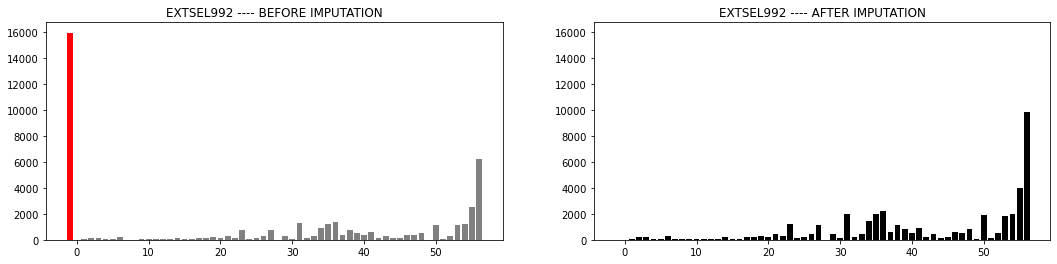

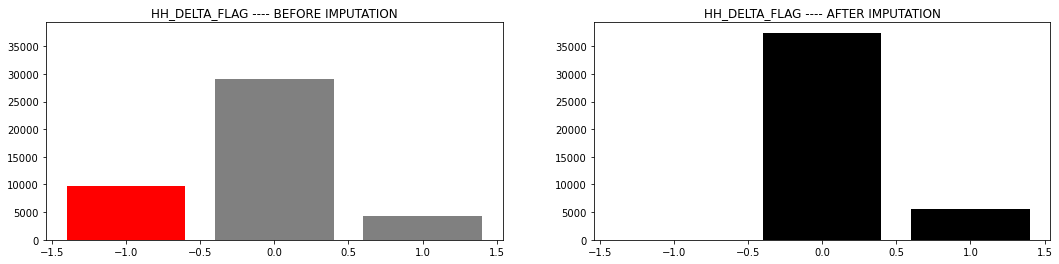

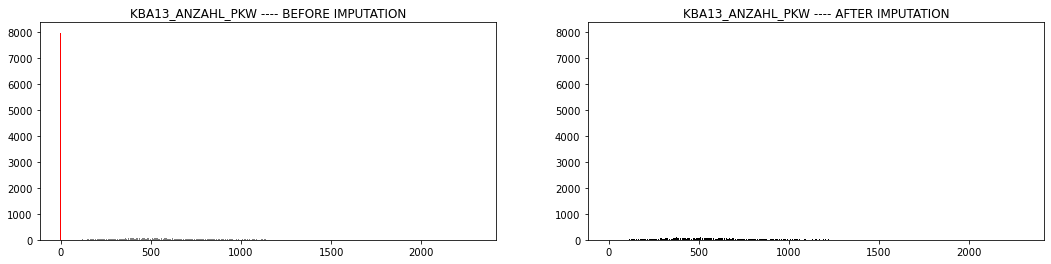

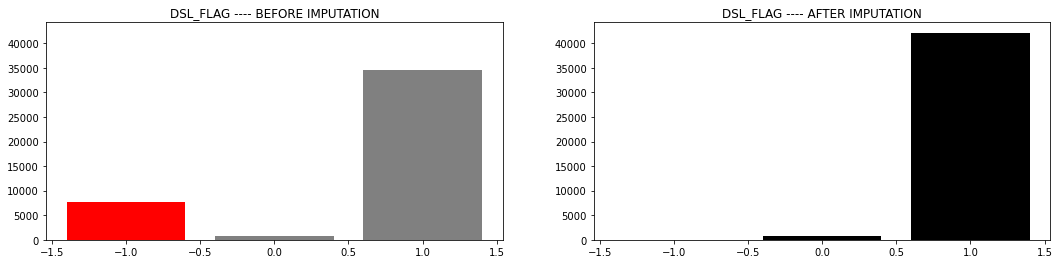

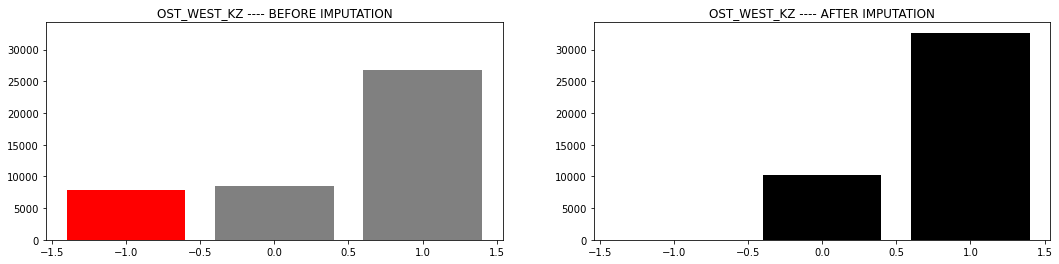

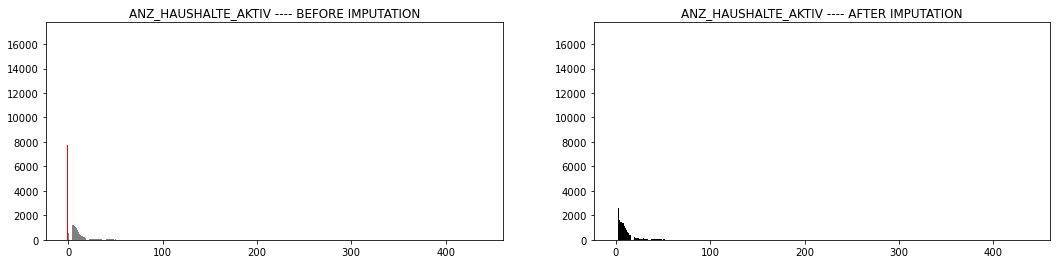

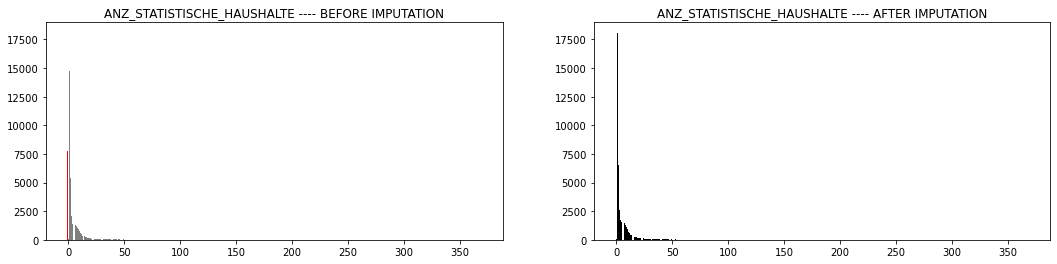

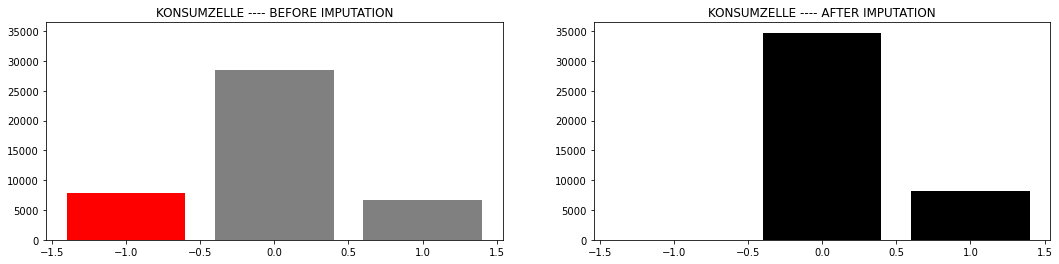

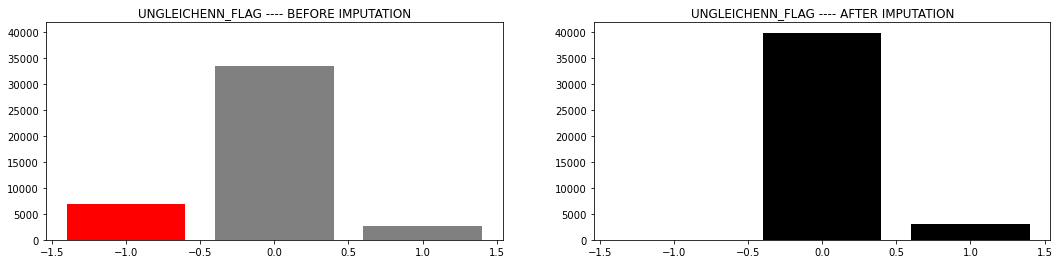

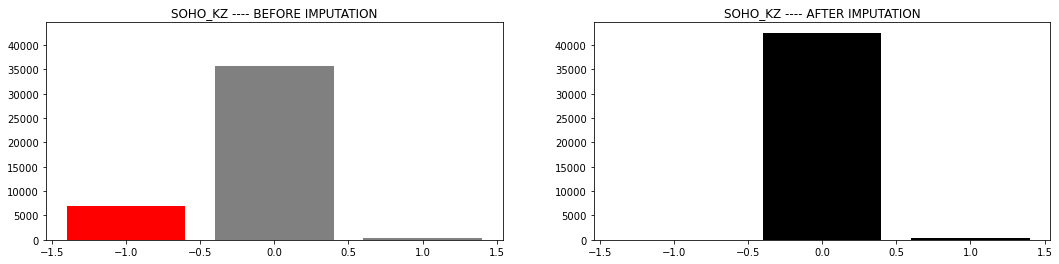

,EXTSEL992,HH_DELTA_FLAG,KBA13_ANZAHL_PKW,DSL_FLAG,ANZ_STATISTISCHE_HAUSHALTE,KONSUMZELLE,OST_WEST_KZ,ANZ_HAUSHALTE_AKTIV,UNGLEICHENN_FLAG,SOHO_KZ
0,34.0,0.0,412.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0
1,47.0,0.0,935.0,1.0,21.0,0.0,1.0,20.0,0.0,0.0
2,35.0,1.0,693.0,1.0,2.0,1.0,1.0,2.0,1.0,0.0
3,31.0,NaN,326.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,36.0,1.0,134.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


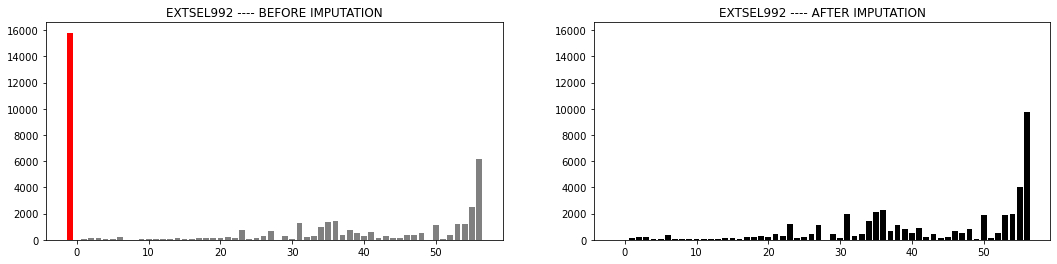

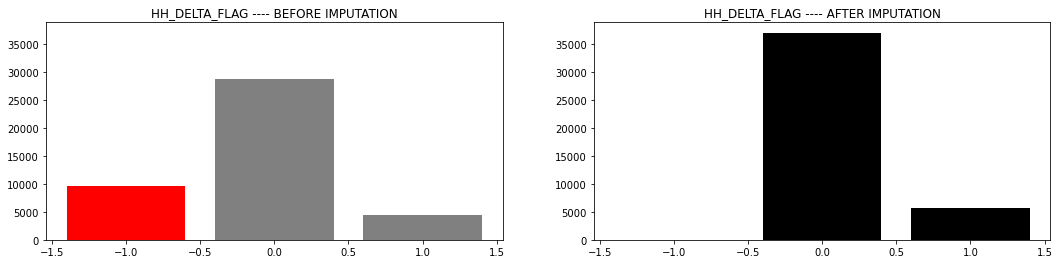

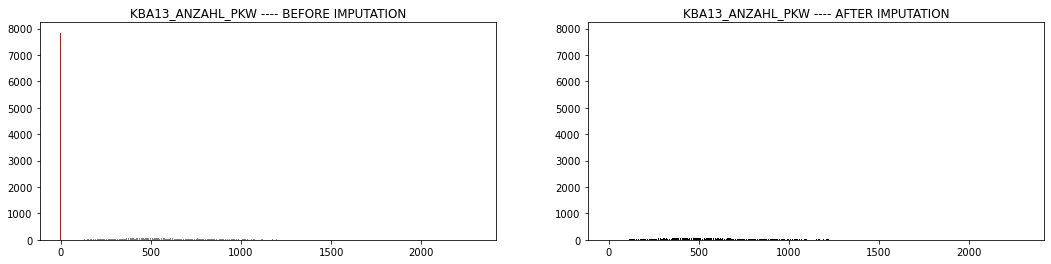

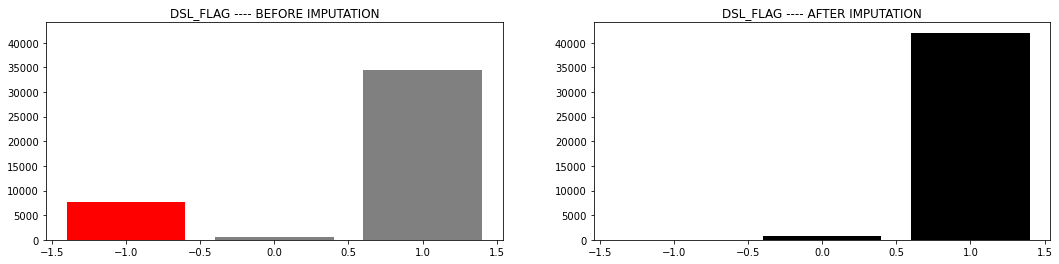

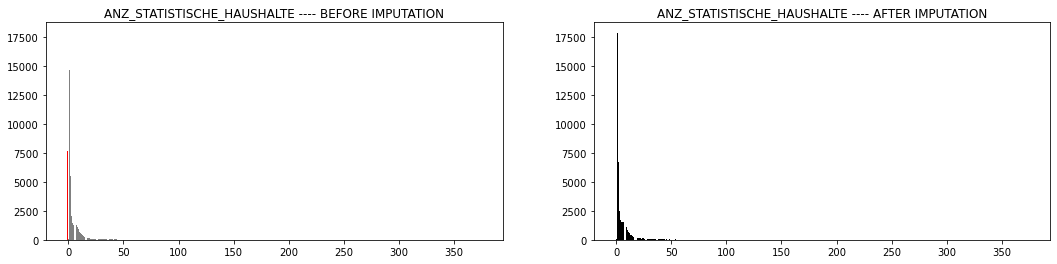

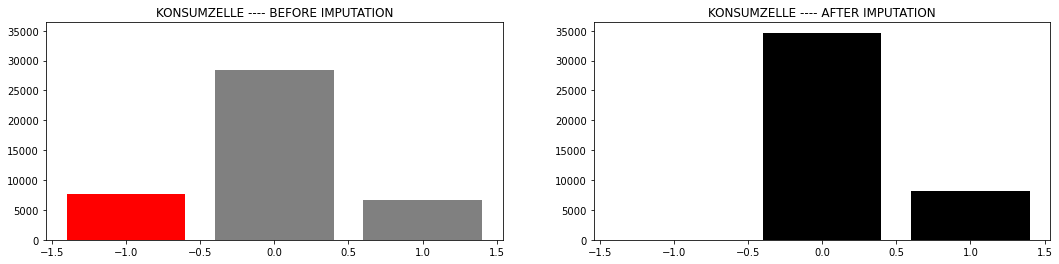

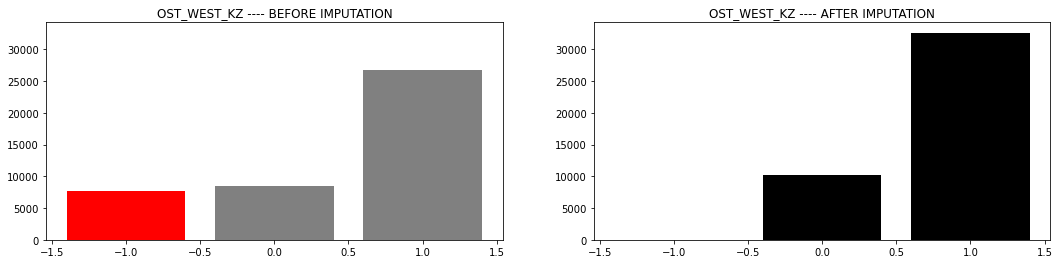

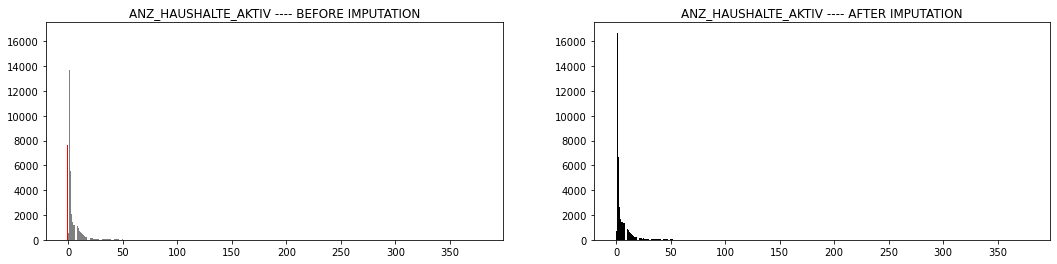

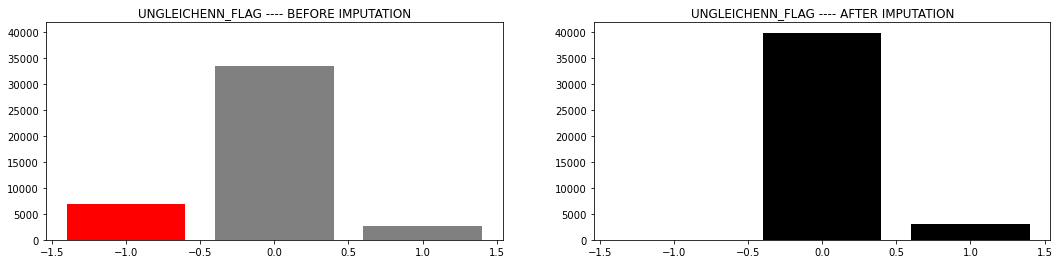

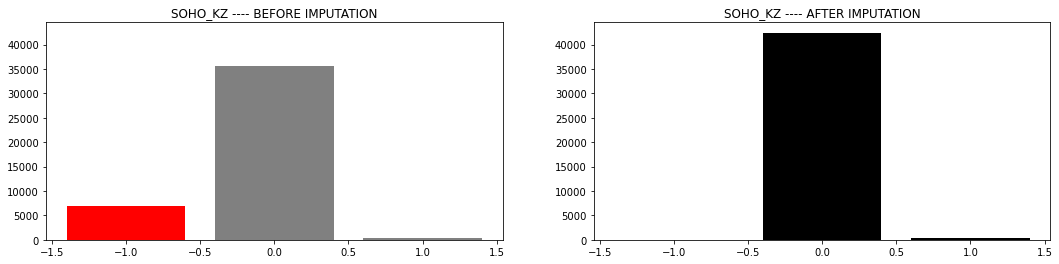

In [45]:
# Examine the rest of the missing data (Mailout Train Data), and the impact our imputing technique would have
mailed_missing = mailed[mailed.isnull().mean().sort_values(ascending=False)[mailed.isnull().mean().sort_values(ascending=False) > 0].index[:]]
mailed_missing.head()
data_exploration.see_impute(mailed_missing)

# Examine the rest of the missing data (Mailout Test Data), and the impact our imputing technique would have
totest_missing = totest[totest.isnull().mean().sort_values(ascending=False)[totest.isnull().mean().sort_values(ascending=False) > 0].index[:]]
totest_missing.head()
data_exploration.see_impute(totest_missing)

In [46]:
data_exploration.impute_feature(mailed['EXTSEL992'])
data_exploration.impute_feature(mailed['HH_DELTA_FLAG'])
data_exploration.impute_feature(mailed['KBA13_ANZAHL_PKW'])
data_exploration.impute_feature(mailed['DSL_FLAG'])
data_exploration.impute_feature(mailed['OST_WEST_KZ'])
data_exploration.impute_feature(mailed['ANZ_HAUSHALTE_AKTIV'])
data_exploration.impute_feature(mailed['ANZ_STATISTISCHE_HAUSHALTE'])
data_exploration.impute_feature(mailed['KONSUMZELLE'])
data_exploration.impute_feature(mailed['UNGLEICHENN_FLAG'])
data_exploration.impute_feature(mailed['SOHO_KZ'])

data_exploration.impute_feature(totest['EXTSEL992'])
data_exploration.impute_feature(totest['HH_DELTA_FLAG'])
data_exploration.impute_feature(totest['KBA13_ANZAHL_PKW'])
data_exploration.impute_feature(totest['DSL_FLAG'])
data_exploration.impute_feature(totest['OST_WEST_KZ'])
data_exploration.impute_feature(totest['ANZ_HAUSHALTE_AKTIV'])
data_exploration.impute_feature(totest['ANZ_STATISTISCHE_HAUSHALTE'])
data_exploration.impute_feature(totest['KONSUMZELLE'])
data_exploration.impute_feature(totest['UNGLEICHENN_FLAG'])
data_exploration.impute_feature(totest['SOHO_KZ'])

In [47]:
print("--- Mailout Train Data other non informative columns ---")
print("Number of bins: {}".format(mailed['D19_VERSI_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).count()))
mailed['D19_VERSI_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True)
print("-----------------------------------------------")
print("Number of bins: {}".format(mailed['D19_TELKO_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).count()))
mailed['D19_TELKO_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True)

print("--- Mailout Test Data other non informative columns ---")
print("Number of bins: {}".format(totest['D19_VERSI_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).count()))
totest['D19_VERSI_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True)
print("-----------------------------------------------")
print("Number of bins: {}".format(totest['D19_TELKO_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).count()))
totest['D19_TELKO_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True)

--- Mailout Train Data other non informative columns ---
Number of bins: 4


0.0     0.998440
10.0    0.001373
5.0     0.000163
3.0     0.000023
Name: D19_VERSI_ONLINE_QUOTE_12, dtype: float64

-----------------------------------------------
Number of bins: 3


0.0     0.998906
10.0    0.000978
5.0     0.000116
Name: D19_TELKO_ONLINE_QUOTE_12, dtype: float64

--- Mailout Test Data other non informative columns ---
Number of bins: 3


0.0     0.998693
10.0    0.001214
5.0     0.000093
Name: D19_VERSI_ONLINE_QUOTE_12, dtype: float64

-----------------------------------------------
Number of bins: 3


0.0     0.998786
10.0    0.001167
5.0     0.000047
Name: D19_TELKO_ONLINE_QUOTE_12, dtype: float64

In [48]:
mailed.drop(['D19_VERSI_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12'], axis=1, inplace=True)
totest.drop(['D19_VERSI_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12'], axis=1, inplace=True)

In [49]:
# Establish that no data is missing in the datasets
mailed.columns[mailed.isnull().any()]
print('\033[1m' + "Percent of Train data still missing: {:2}%".format(round(100*mailed.isnull().sum().sum()/mailed.size)))

totest.columns[totest.isnull().any()]
print('\033[1m' + "Percent of Test data still missing: {:2}%".format(round(100*totest.isnull().sum().sum()/totest.size)))

Index([], dtype='object')

Percent of Train data still missing:  0%


Index([], dtype='object')

Percent of Test data still missing:  0%


## Handle Outliers

In [50]:
print(" ---- Mailout Train Data - Numerical Features ----")
data_exploration.numericals(mailed)
print("")
print(" ---- Mailout Test Data - Numerical Features ----")
data_exploration.numericals(totest)

 ---- Mailout Train Data - Numerical Features ----
ANZ_HAUSHALTE_AKTIV            [ 175]
ANZ_STATISTISCHE_HAUSHALTE     [ 173]
EXTSEL992                      [  56]
GEBURTSJAHR                    [ 108]
KBA13_ANZAHL_PKW               [1230]

 ---- Mailout Test Data - Numerical Features ----
ANZ_HAUSHALTE_AKTIV            [ 178]
ANZ_STATISTISCHE_HAUSHALTE     [ 173]
EXTSEL992                      [  56]
GEBURTSJAHR                    [ 106]
KBA13_ANZAHL_PKW               [1231]


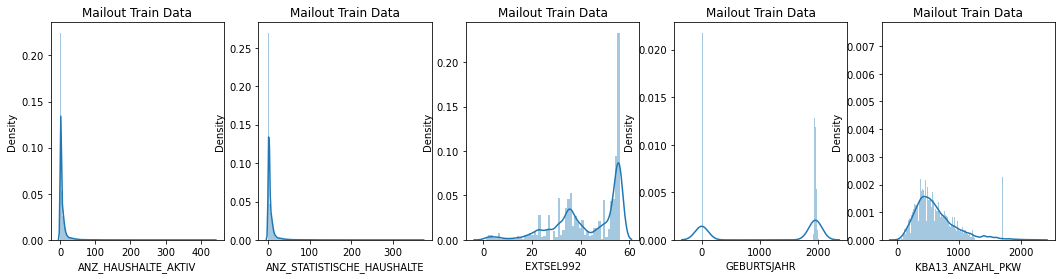

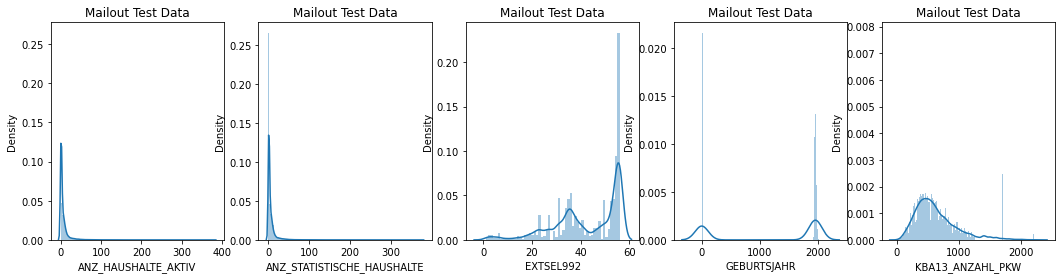

In [51]:
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
ax1 = f.add_subplot(151)
_ = ax1.set_title("Mailout Train Data")
_ = sns.distplot(mailed['ANZ_HAUSHALTE_AKTIV'], bins=175)
ax2 = f.add_subplot(152)
_ = ax2.set_title("Mailout Train Data")
_ = sns.distplot(mailed['ANZ_STATISTISCHE_HAUSHALTE'], bins=173)
ax3 = f.add_subplot(153)
_ = ax3.set_title("Mailout Train Data")
_ = sns.distplot(mailed['EXTSEL992'], bins=56)
ax4 = f.add_subplot(154)
_ = ax4.set_title("Mailout Train Data")
_ = sns.distplot(mailed['GEBURTSJAHR'], bins=108)
ax5 = f.add_subplot(155)
_ = ax5.set_title("Mailout Train Data")
_ = sns.distplot(mailed['KBA13_ANZAHL_PKW'], bins=1230)
_ = plt.show()


f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
ax1 = f.add_subplot(151)
_ = ax1.set_title("Mailout Test Data")
_ = sns.distplot(totest['ANZ_HAUSHALTE_AKTIV'], bins=178)
ax2 = f.add_subplot(152)
_ = ax2.set_title("Mailout Test Data")
_ = sns.distplot(totest['ANZ_STATISTISCHE_HAUSHALTE'], bins=173)
ax3 = f.add_subplot(153)
_ = ax3.set_title("Mailout Test Data")
_ = sns.distplot(mailed['EXTSEL992'], bins=56)
ax4 = f.add_subplot(154)
_ = ax4.set_title("Mailout Test Data")
_ = sns.distplot(totest['GEBURTSJAHR'], bins=106)
ax5 = f.add_subplot(155)
_ = ax5.set_title("Mailout Test Data")
_ = sns.distplot(totest['KBA13_ANZAHL_PKW'], bins=1231)
_ = plt.show()

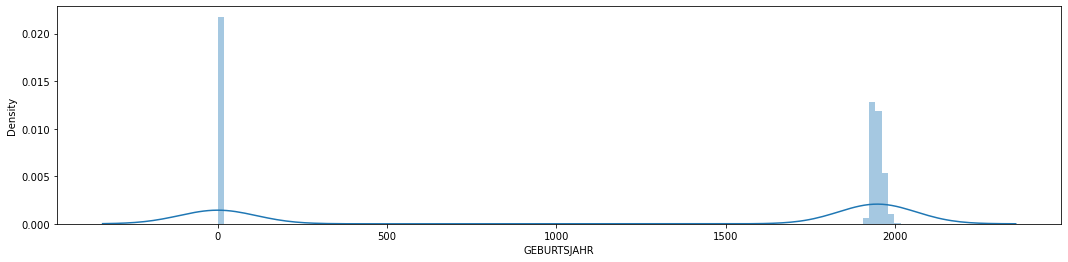

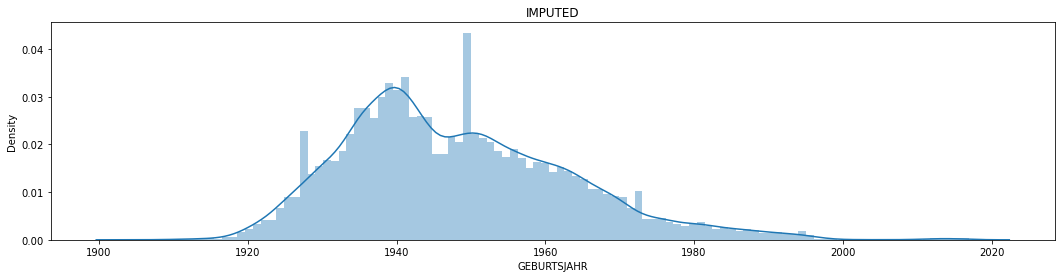

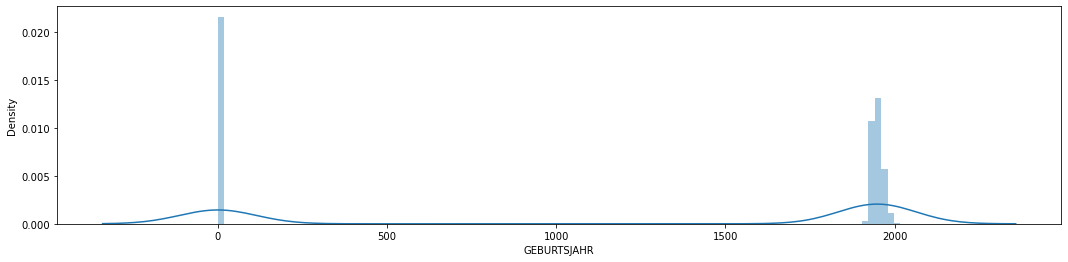

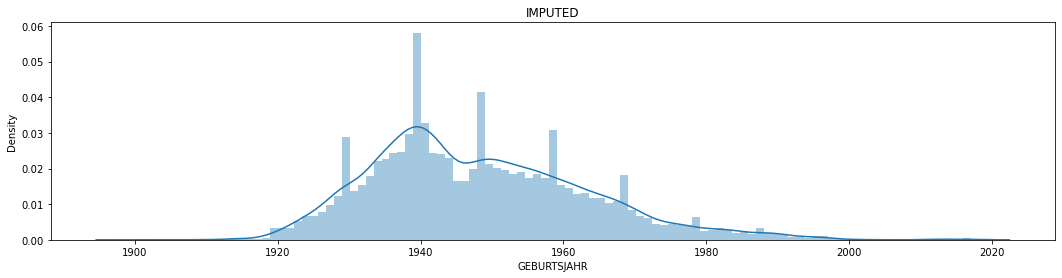

In [52]:
bins = mailed['GEBURTSJAHR'].value_counts().sort_index(ascending=False).count()
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(mailed['GEBURTSJAHR'], bins=bins)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
mailed.loc[(mailed['GEBURTSJAHR'] == 0 ), 'GEBURTSJAHR'] = np.nan
data_exploration.impute_feature(mailed['GEBURTSJAHR'])
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(mailed['GEBURTSJAHR'], bins=bins-1).set_title('IMPUTED')
_ = plt.show()


bins = totest['GEBURTSJAHR'].value_counts().sort_index(ascending=False).count()
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(totest['GEBURTSJAHR'], bins=bins)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
totest.loc[(totest['GEBURTSJAHR'] == 0 ), 'GEBURTSJAHR'] = np.nan
data_exploration.impute_feature(totest['GEBURTSJAHR'])
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(totest['GEBURTSJAHR'], bins=bins-1).set_title('IMPUTED')
_ = plt.show()

In [53]:
mailed['KBA13_ANZAHL_PKW'].value_counts().sort_index(ascending=False).head(15)
totest['KBA13_ANZAHL_PKW'].value_counts().sort_index(ascending=False).head(15)

2300.0     34
2200.0     16
2100.0     36
2000.0     67
1900.0    104
1800.0    160
1700.0    183
1600.0    361
1500.0    470
1400.0    601
1300.0    367
1250.0     19
1249.0      6
1247.0      3
1246.0      6
Name: KBA13_ANZAHL_PKW, dtype: int64

2300.0     16
2200.0     17
2100.0     28
2000.0     78
1900.0     71
1800.0    156
1700.0    199
1600.0    356
1500.0    427
1400.0    622
1300.0    340
1250.0      8
1249.0      8
1247.0      5
1246.0      7
Name: KBA13_ANZAHL_PKW, dtype: int64

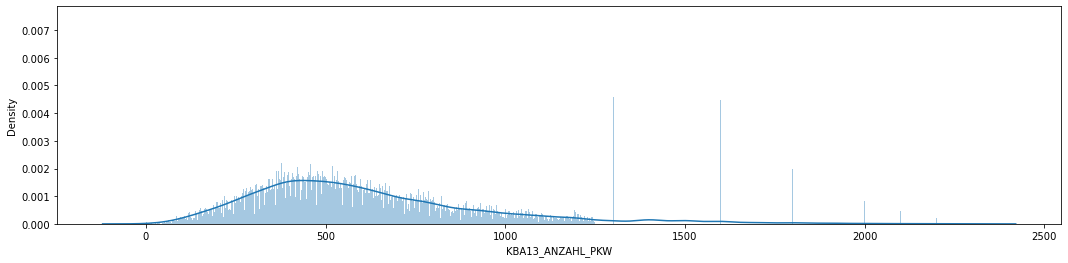

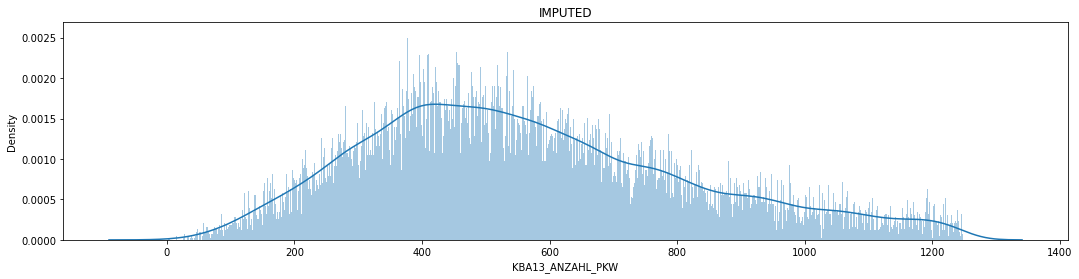

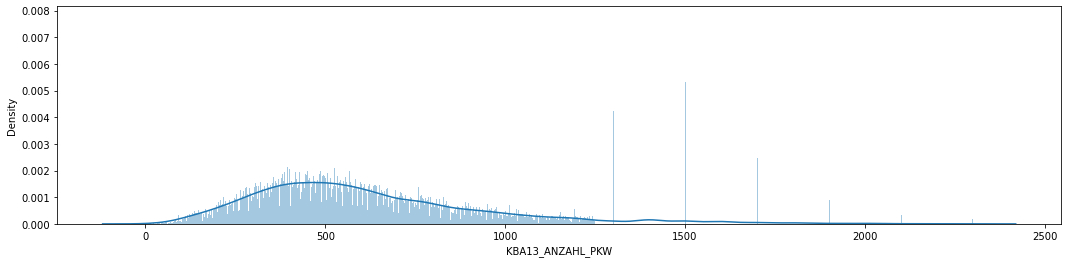

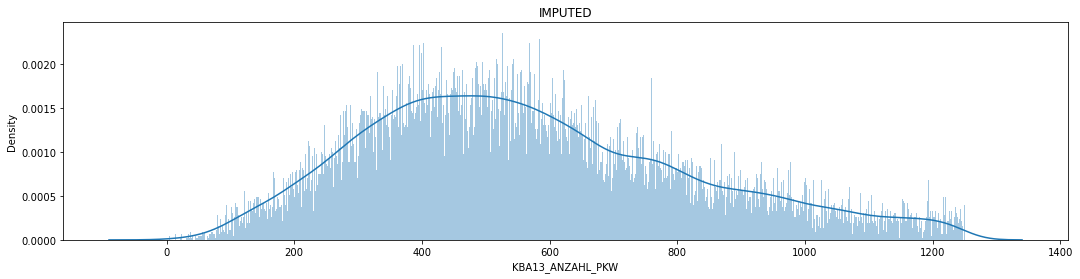

In [54]:
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(mailed['KBA13_ANZAHL_PKW'], bins=1230)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
mailed.loc[(mailed['KBA13_ANZAHL_PKW'] > 1250 ), 'KBA13_ANZAHL_PKW'] = np.nan
data_exploration.impute_feature(mailed['KBA13_ANZAHL_PKW'])

f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(mailed['KBA13_ANZAHL_PKW'], bins=1250).set_title('IMPUTED')
_ = plt.show()


f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(totest['KBA13_ANZAHL_PKW'], bins=1230)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
totest.loc[(totest['KBA13_ANZAHL_PKW'] > 1250 ), 'KBA13_ANZAHL_PKW'] = np.nan
data_exploration.impute_feature(totest['KBA13_ANZAHL_PKW'])

f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(totest['KBA13_ANZAHL_PKW'], bins=1250).set_title('IMPUTED')
_ = plt.show()

<br/><br/>
## Model Selection

Supervised learning algorithms search through a hypothesis space to find a good predictor for a particular problem. We will first go through a cursory exploration of several simple models, such as Logistic Regression, as well as Ensemble techniques that generate multiple hypotheses using the same base learner like Random Forest, Adaptive Boosting, Gradient Boosting and variants like XGBoost. Boosting refers to the general idea of producing accurate predictions by combining rough and inaccurate rules-of-thumb. It is a sequential process that in some cases tends to over-fit the training data. We'll keep an eye on this during the hyperparameter tuning section with the aim of tuning our boosters in areas where no overfitting is known to occur.

Our mailout train dataset is highly imbalanced with the RESPONSE label consisting overwhelmingly of zeros, i.e., non-customers. This points us in the direction of `ROC AUC` as a performance metric for this classification problem. ROC (Receiver Operator Characteristic) is a probability curve, and AUC (Area Under the Curve) tells how much the model is capable of distinguishing between classes. The higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. This score is commonly used for comparing classification models for imbalanced problems. And for our purposes, given the nature of the problem (marketing), as well as the imbalanced quality of the labels, it will be our mtric of choice. 

The code cells below explore several classifiers to get a taste of how well they perform. The best performing model will then be tuned to arrive at an optimal classification. We'll be visualizing the ROC curves and measuring the ROC AUC for each model to decide how to proceed.

In [55]:
# Split Mailout Train dataset into Train and Test subsets
from sklearn.model_selection import train_test_split
mailout_X = mailed.drop('RESPONSE', axis=1)
mailout_y = mailed['RESPONSE']
X_train, X_test, y_train, y_test = train_test_split(mailout_X, mailout_y, stratify=mailout_y, test_size=0.2, random_state=RANDOM_STATE)

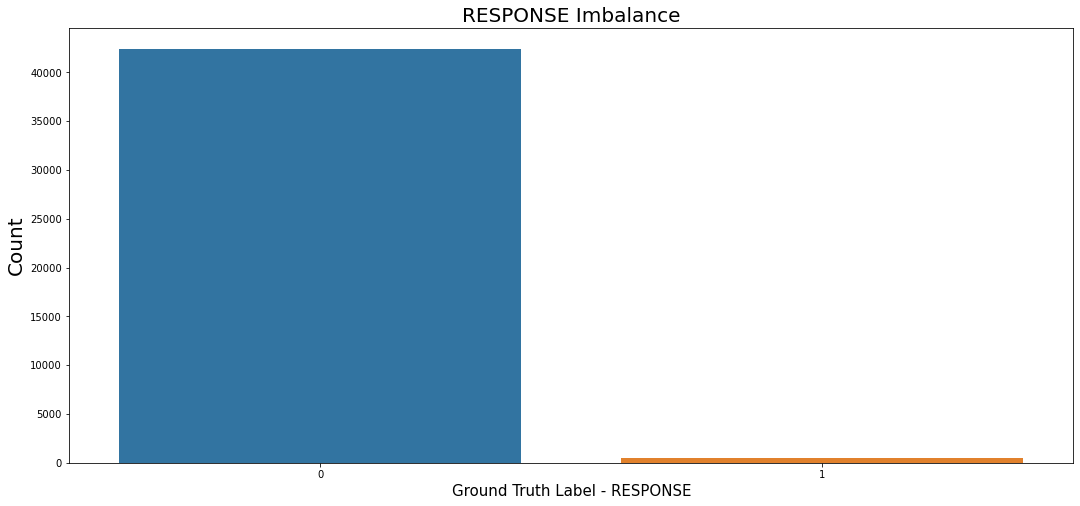

In [56]:
# Observe the imbalanced nature of the response label
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
_ = sns.countplot("RESPONSE", data=mailed)
_ = plt.title('RESPONSE Imbalance', fontsize=20)
_ = plt.xlabel("Ground Truth Label - RESPONSE", fontsize=15)
_ = plt.ylabel("Count", fontsize=20)
_ = plt.show()

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
#conda install -c conda-forge xgboost
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score

<br/>**Logistic Regression:** This general classifier assumes that the outcome variable is binary, that the relationship between the **logit(p) = log ( p / (1-p) )** of the outcome and each continuous independent variable is linear, that there are no highly influential outliers that could distort the model accuracy, that there is no multicollinearity, that the observations are independent, and that the sample size is sufficiently large. Some of these assumptions are met, e.g., the binary nature of the `RESPONSE`. And some are not, e.g., multicollinearity, at least not without some processing such as principal component analysis. 

In [58]:
logistic_reg = LogisticRegression(random_state=RANDOM_STATE)
_ = logistic_reg.fit(X_train, y_train)
lr_prediction = logistic_reg.predict_proba(X_test)[:,1]
lr_roc_auc = round(100*roc_auc_score(y_test, lr_prediction),2)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_prediction)

<br/>**Random Forest :** Builds multiple decision trees and merges them together to get a more accurate and stable prediction. Random forest adds additional randomness to the model, while growing the trees. Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features. This results in a wide diversity that generally results in a better model. Therefore, in random forest, only a random subset of the features is taken into consideration by the algorithm for splitting a node.

In [59]:
rand_forest = RandomForestClassifier(random_state=RANDOM_STATE)
_ = rand_forest.fit(X_train, y_train)
rf_prediction = rand_forest.predict_proba(X_test)[:,1]
rf_roc_auc = round(100*roc_auc_score(y_test, rf_prediction),2)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prediction)

<br/>**AdaBoost :** The basic concept behind Adaptive boosting is to set the weights of classifiers and training the data sample in each iteration such that it ensures the accurate predictions of unusual observations. Adaboost combines multiple “weak classifiers” into a single “strong classifier”. AdaBoost works by putting more weight on difficult to classify instances and less on those already handled well.

In [60]:
ada_boost = AdaBoostClassifier(random_state=RANDOM_STATE)
_ = ada_boost.fit(X_train, y_train)
ad_prediction = ada_boost.predict_proba(X_test)[:,1]
ad_roc_auc = round(100*roc_auc_score(y_test, ad_prediction),2)
ad_fpr, ad_tpr, _ = roc_curve(y_test, ad_prediction)

<br/>**Gradient Boost :** A generalization of the Adaptive Boosting concept that casts boosting as a numerical optimization problem where the objective is to minimize the loss of the model by adding weak learners using a gradient descent like procedure. The loss function used depends on the type of problem being solved. It must be differentiable, but many standard loss functions are supported. For example, regression may use a squared error and classification may use logarithmic loss. A benefit of the gradient boosting framework is that a new boosting algorithm does not have to be derived for each loss function that may want to be used, instead, it is a generic enough framework that any differentiable loss function can be used.

In [61]:
gradient_boost = GradientBoostingClassifier(random_state=RANDOM_STATE)
_ = gradient_boost.fit(X_train, y_train)
gb_prediction = gradient_boost.predict_proba(X_test)[:,1]
gb_roc_auc = round(100*roc_auc_score(y_test, gb_prediction),2)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_prediction)

<br/>**Extreme Gradient Boost :** XGBoost (Extreme Gradient Boosting) belongs to the family of boosting algorithms and uses the gradient boosting (GBM) framework at its core. It is an optimized distributed gradient boosting library that is comparatively faster than other ensemble classifiers. The core algorithm is parallelizable, so it can harness the power of multi-core computers. It is also parallelizable onto GPU’s and across networks of computers making it feasible to train on very large datasets as well.

In [62]:
XG_boost = xgb.XGBClassifier(random_state=RANDOM_STATE)
_ = XG_boost.fit(X_train, y_train)
xg_prediction = XG_boost.predict_proba(X_test)[:,1]
xg_roc_auc = round(100*roc_auc_score(y_test, xg_prediction),2)
xg_fpr, xg_tpr, _ = roc_curve(y_test, xg_prediction)

[18:54:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


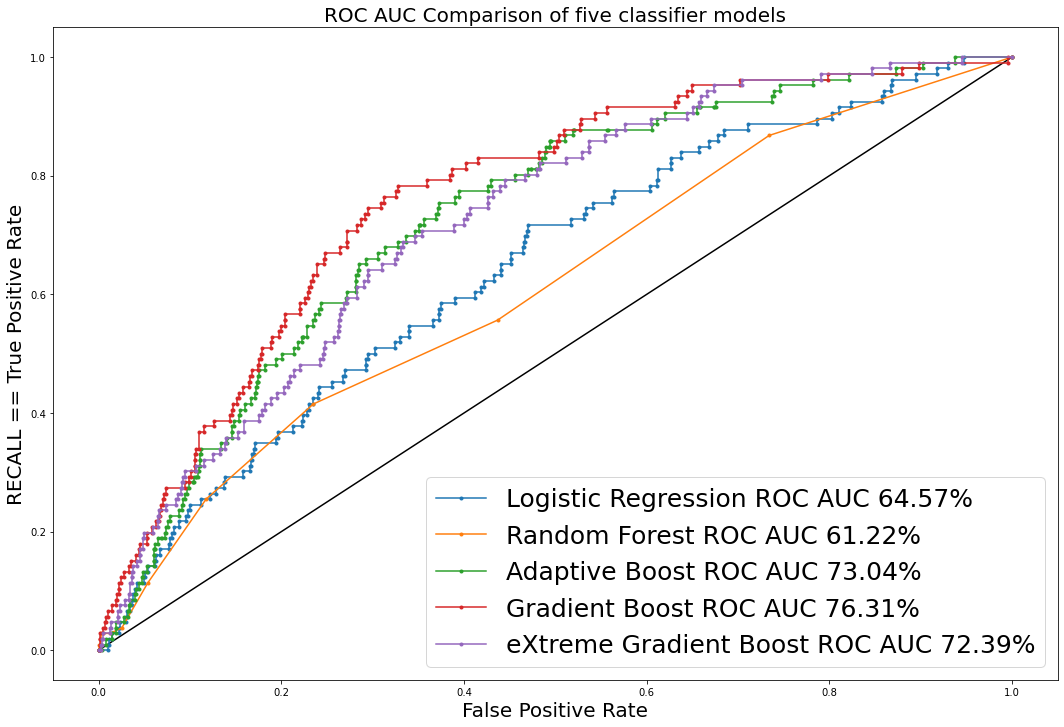

In [63]:
# Visually compare the models' ROC curves and show ROC AUC scores
f = plt.figure(figsize=(FIG_WIDTH, 3*FIG_HEIGHT/2))
_ = plt.title("ROC AUC Comparison of five classifier models", fontsize=20)
_ = plt.plot([0,1], [0,1], color='black', linestyle='-')
_ = plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression ROC AUC {}%'.\
             format( round(100*roc_auc_score(y_test, lr_prediction),2)))
_ = plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest ROC AUC {}%'.\
             format( round(100*roc_auc_score(y_test, rf_prediction),2)))
_ = plt.plot(ad_fpr, ad_tpr, marker='.', label='Adaptive Boost ROC AUC {}%'.\
             format( round(100*roc_auc_score(y_test, ad_prediction),2)))
_ = plt.plot(gb_fpr, gb_tpr, marker='.', label='Gradient Boost ROC AUC {}%'.\
             format( round(100*roc_auc_score(y_test, gb_prediction),2)))
_ = plt.plot(xg_fpr, xg_tpr, marker='.', label='eXtreme Gradient Boost ROC AUC {}%'.\
             format( round(100*roc_auc_score(y_test, xg_prediction),2)))
_ = plt.xlabel('False Positive Rate', fontsize=20)
_ = plt.ylabel('RECALL == True Positive Rate', fontsize=20)
_ = plt.legend(prop={'size': 25}, loc=4)
print("")
_ = plt.show()

<br/><br/>
## Hyperparameter Tuning

**GradientBoostingClassifier** performed exceedingly well compared to the others, so we'll perform hyperparameter tuning on it. The overall parameters of this ensemble model can be divided into 3 categories: Tree-Specific Parameters, Boosting Parameters, and other miscellaneous parameters for overall functioning. We'll focus on a few of the most impactful tree-specific, and boosting parameters. Most GBM tuning strategies focus on the number of trees (`n_estimators`), tree depth (`max_depth`), and the learning rate (`learning_rate`). We'll tune these three parameters and explore tuning four more. The full set of parameters to tune is listed below with a brief explanation as to how they impact model learning. We'll use cross validation in tuning and the `roc_auc` metric in scoring.

- **Boosting Parameters**
    - **learning_rate:** GBM works by starting with an initial estimate which is changed using the output of each tree. The `learning_rate` parameter controls the magnitude of this change in the estimates. Lower values are generally preferred as they make the model robust to the specific characteristics of the tree, thus allowing it to generalize well.
    - **n_estimators:** The number of sequential trees to be modeled. GBM is fairly robust at higher numbers of trees but it can still overfit. Hence, this parameter should be tuned using `cross validation` for a particular learning rate. Usually a higher number of trees improves the learning.
    - **subsample:** The fraction of observations to be selected for each tree. Values slightly less than 1 make the model robust by reducing the variance.

- **Tree-specific parameters**
    - **max_depth:** This indicates how deep the tree can be. The deeper the tree, the more splits it has. Higher depth will allow the model to learn relations very specific to a particular sample (overfitting).
    - **max_features:** The number of randomly selected features to consider while searching for a best split.
    - **min_samples_leaf:** Defines the minimum number of samples (observations) required to be at a terminal or leaf node. Generally lower values should be chosen for imbalanced problems such as this, because the regions in which the minority class (true customers) dominates, is small.
    - **min_samples_split:** Defines the minimum number of samples required to split an internal node. When we increase this parameter, the tree has to consider more samples at each node, preventing the model from learning relations which might be highly specific (overfitting) to the particular sample.

The code cell below, shows us the behaviour of the model as it learns with varying values for these parameters in isolation. The learning curve graphs allow us to observe regions where the gap between the train and test results (test=red) aren't too wide (overfitting) and also not crossing (underfitting). It is the values in these regions that we'll use to tune our baseline `GradientBoostClassifier`.


 learning_rate:  0.001 0.005 0.01 0.05 0.1 
 n_estimators:  25 50 75 100 125 
 max_depth:  3 5 7 9 11 
 max_features:  50 100 150 200 250 
 min_samples_leaf:  3 5 7 9 
 min_samples_split:  20 25 30 35 40 
 subsample:  0.75 0.8 0.85 0.9 0.95 

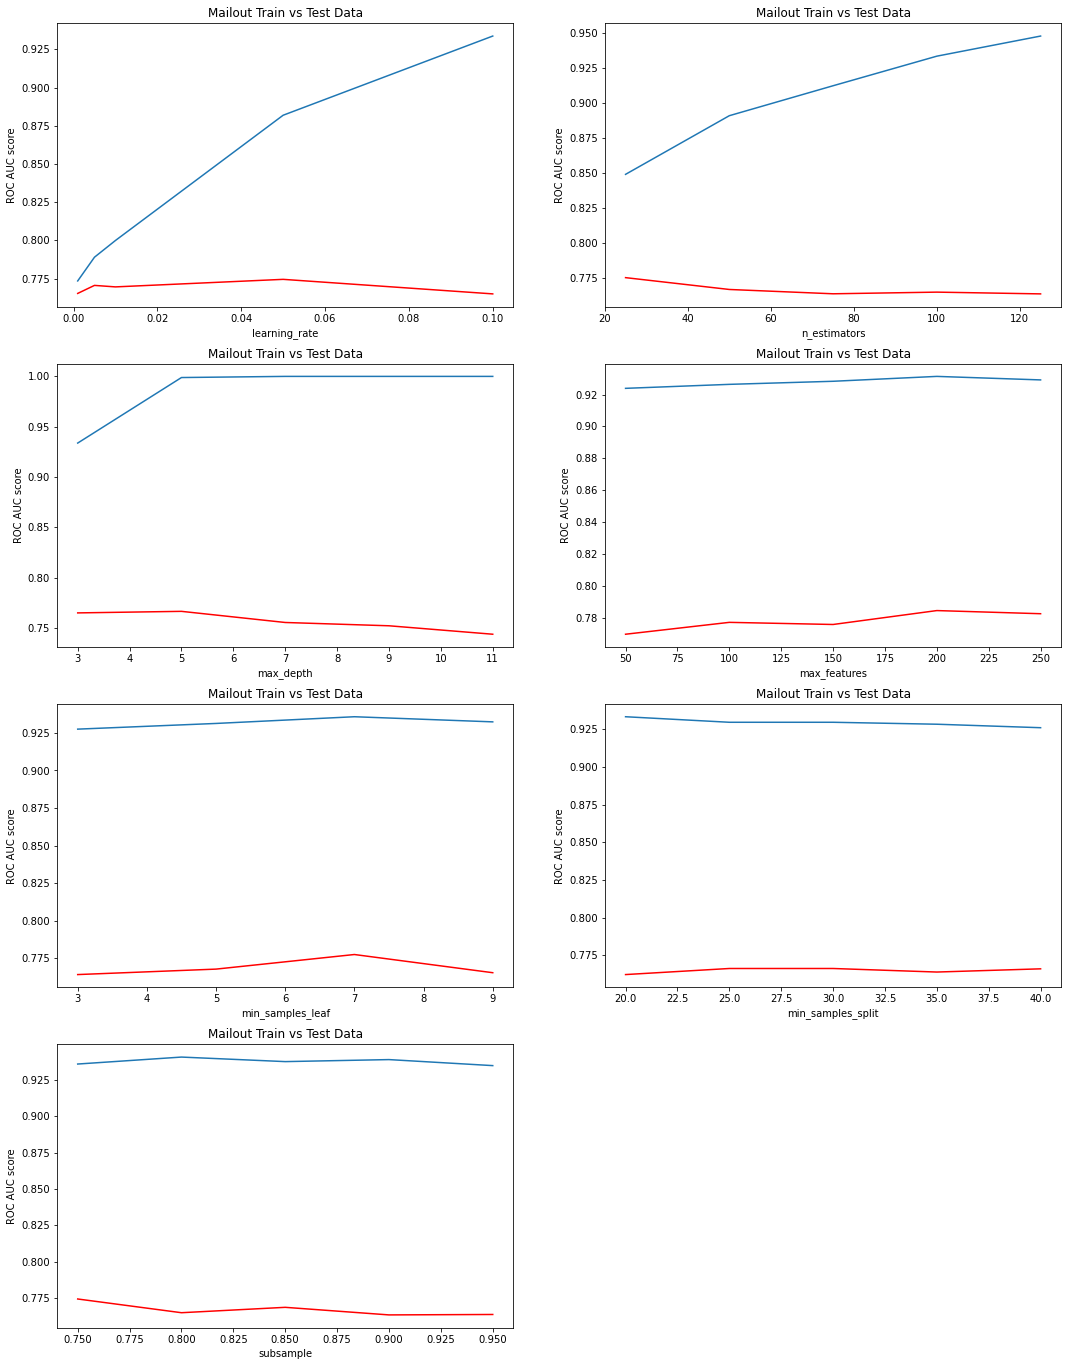

In [64]:
from sklearn.metrics import roc_curve, auc
# Observe behaviour of each parameter in isolation first, to see where the sensitive kinks are.
hyperparams = {
     "learning_rate" : [0.001, 0.005, 0.01, 0.05, 0.1],
     "n_estimators" : [25, 50, 75, 100, 125],
     "max_depth" : [3, 5, 7, 9, 11],
     "max_features" : [50, 100, 150, 200, 250],
     "min_samples_leaf" : [3, 5, 7, 9],
     "min_samples_split" : [20, 25, 30, 35, 40],
     "subsample" : [0.75, 0.8, 0.85, 0.9, 0.95]
}
lr_train_metrics = []
lr_test_metrics = []
ne_train_metrics = []
ne_test_metrics = []
md_train_metrics = []
md_test_metrics = []
mf_train_metrics = []
mf_test_metrics = []
msl_train_metrics = []
msl_test_metrics = []
mss_train_metrics = []
mss_test_metrics = []
ss_train_metrics = []
ss_test_metrics = []
for hyper, values in hyperparams.items():
    print("\n " + hyper + ": ", end=' ')
    for param in values:
        print(param, end=' ')
        if hyper == "learning_rate":
            modelo = GradientBoostingClassifier( learning_rate = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            lr_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            lr_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )
        elif hyper == "n_estimators":
            modelo = GradientBoostingClassifier( n_estimators = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            ne_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            ne_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )
        elif hyper == "max_depth":
            modelo = GradientBoostingClassifier( max_depth = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            md_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            md_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )
        elif hyper == "max_features":
            modelo = GradientBoostingClassifier( max_features = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            mf_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            mf_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )
        elif hyper == "min_samples_leaf":
            modelo = GradientBoostingClassifier( min_samples_leaf = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            msl_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            msl_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )
        elif hyper == "min_samples_split":
            modelo = GradientBoostingClassifier( min_samples_split = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            mss_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            mss_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )
        elif hyper == "subsample":
            modelo = GradientBoostingClassifier( subsample = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            ss_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            ss_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )

f = plt.figure(figsize=(FIG_WIDTH, 3*FIG_HEIGHT))
ax1 = f.add_subplot(421)
_ = ax1.set_title("Mailout Train vs Test Data")
_ = plt.plot(hyperparams["learning_rate"], lr_train_metrics)
_ = plt.plot(hyperparams["learning_rate"], lr_test_metrics, color='red')
_ = plt.ylabel('ROC AUC score')
_ = plt.xlabel('learning_rate')
ax2 = f.add_subplot(422)
_ = ax2.set_title("Mailout Train vs Test Data")
_ = plt.plot(hyperparams["n_estimators"], ne_train_metrics)
_ = plt.plot(hyperparams["n_estimators"], ne_test_metrics, color='red')
_ = plt.ylabel('ROC AUC score')
_ = plt.xlabel('n_estimators')
ax3 = f.add_subplot(423)
_ = ax3.set_title("Mailout Train vs Test Data")
_ = plt.plot(hyperparams["max_depth"], md_train_metrics)
_ = plt.plot(hyperparams["max_depth"], md_test_metrics, color='red')
_ = plt.ylabel('ROC AUC score')
_ = plt.xlabel('max_depth')
ax4 = f.add_subplot(424)
_ = ax4.set_title("Mailout Train vs Test Data")
_ = plt.plot(hyperparams["max_features"], mf_train_metrics)
_ = plt.plot(hyperparams["max_features"], mf_test_metrics, color='red')
_ = plt.ylabel('ROC AUC score')
_ = plt.xlabel('max_features')
ax5 = f.add_subplot(425)
_ = ax5.set_title("Mailout Train vs Test Data")
_ = plt.plot(hyperparams["min_samples_leaf"], msl_train_metrics)
_ = plt.plot(hyperparams["min_samples_leaf"], msl_test_metrics, color='red')
_ = plt.ylabel('ROC AUC score')
_ = plt.xlabel('min_samples_leaf')
ax6 = f.add_subplot(426)
_ = ax6.set_title("Mailout Train vs Test Data")
_ = plt.plot(hyperparams["min_samples_split"], mss_train_metrics)
_ = plt.plot(hyperparams["min_samples_split"], mss_test_metrics, color='red')
_ = plt.ylabel('ROC AUC score')
_ = plt.xlabel('min_samples_split')
ax7 = f.add_subplot(427)
_ = ax7.set_title("Mailout Train vs Test Data")
_ = plt.plot(hyperparams["subsample"], ss_train_metrics)
_ = plt.plot(hyperparams["subsample"], ss_test_metrics, color='red')
_ = plt.ylabel('ROC AUC score')
_ = plt.xlabel('subsample')
_ = plt.show()

In [65]:
# Establish a baseline model and its metric
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

base_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
_ = base_model.fit(X_train, y_train)
print("GB ROC AUC {}%".format( round(100*roc_auc_score(y_test, base_model.predict_proba(X_test)[:,1]),2)) )

GB ROC AUC 76.5%


In [70]:
# Tune the main four parameters.
tunables = {'learning_rate':[0.0005, 0.001, 0.005], 'n_estimators':[50, 60, 70],\
            'max_depth':[4, 5, 6], 'max_features':[150, 175, 200]}
tuning_model = GridSearchCV(estimator = GradientBoostingClassifier(random_state=RANDOM_STATE),\
                       param_grid = tunables, scoring='roc_auc', n_jobs=-1, cv=3, verbose=2)
tuning_model.fit(X_train,y_train)
tuning_model.cv_results_
tuning_model.best_params_
print("GB ROC AUC {}%".format( round(100*tuning_model.best_score_, 2) ))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=403),
             n_jobs=-1,
             param_grid={'learning_rate': [0.0005, 0.001, 0.005],
                         'max_depth': [4, 5, 6],
                         'max_features': [150, 175, 200],
                         'n_estimators': [50, 60, 70]},
             scoring='roc_auc', verbose=2)

{'mean_fit_time': array([13.39386233, 16.40023685, 19.07147098, 15.64434663, 18.17607665, 21.53781033, 17.81426676, 21.92127792, 25.79548407, 17.80050214, 20.68697087, 23.35343981, 19.34698455, 22.58975418, 26.28343995, 21.42777562, 25.90947135, 30.19948411, 20.02432434, 23.77922694, 27.62252975, 22.74257771, 27.60448194, 32.01043034, 25.99877516, 31.08112137, 36.44855181, 12.59052928, 15.11084867, 17.63848654,
        14.5834554 , 17.66104372, 20.59945766, 16.80494444, 19.93879557, 23.26279076, 16.06910229, 19.29196191, 22.48497645, 18.61139139, 22.36101286, 26.17939464, 21.37587738, 25.79683741, 30.02405365, 19.74955956, 23.56113776, 27.46926641, 22.92412615, 27.62783941, 32.17851345, 25.96582826, 30.86234713, 35.91620533, 12.51492325, 14.93585825, 17.69079892, 14.86685856, 17.73025942, 20.67898345,
        17.07681004, 20.46938475, 23.74673478, 16.29212602, 19.63491996, 22.85056448, 19.01399008, 22.70065602, 26.39258337, 21.39361342, 25.43076571, 29.87605993, 19.70501773, 23.5996408

{'learning_rate': 0.001,
 'max_depth': 5,
 'max_features': 175,
 'n_estimators': 60}

GB ROC AUC 76.27%


In [71]:
# Tune the remaining three parameters.
tunables = {'min_samples_leaf':[2, 4, 6], 'min_samples_split':[25, 30, 35],'subsample':[0.85, 0.9, 0.95]}
tuning_model = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.001, n_estimators=60,\
                                                                   max_depth=5, max_features=175,\
                                                                   random_state=RANDOM_STATE),\
                       param_grid = tunables, scoring='roc_auc', n_jobs=-1, cv=5, verbose=2)
tuning_model.fit(X_train,y_train)
tuning_model.cv_results_
tuning_model.best_params_
print("GB ROC AUC {}%".format( round(100*tuning_model.best_score_, 2) ))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.001,
                                                  max_depth=5, max_features=175,
                                                  n_estimators=60,
                                                  random_state=403),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [25, 30, 35],
                         'subsample': [0.85, 0.9, 0.95]},
             scoring='roc_auc', verbose=2)

{'mean_fit_time': array([23.98247724, 24.97702937, 25.67672839, 23.67139039, 25.05961857, 26.12963438, 23.84760633, 25.22194982, 26.19753904, 23.74980736, 24.88442469, 26.05068903, 23.63952842, 24.71899905, 25.88521929, 23.56376581, 24.74808621, 25.81835947, 23.36320643, 24.57131004, 25.7613718 , 23.43883619, 24.91320004, 26.15885158, 23.65883541, 24.58965096, 23.67080107]),
 'std_fit_time': array([0.07810588, 0.36463386, 0.09767024, 0.20725914, 0.03152648, 0.04844612, 0.15701227, 0.08664219, 0.08851288, 0.07665628, 0.10676532, 0.10295454, 0.12211945, 0.04688675, 0.09214344, 0.08758451, 0.09514662, 0.03356644, 0.11050327, 0.05528487, 0.06020514, 0.09759373, 0.15553917, 0.07659764, 0.08585886, 0.57163782, 0.68041267]),
 'mean_score_time': array([0.09257231, 0.06151514, 0.05380378, 0.059198  , 0.05364323, 0.05981288, 0.05797791, 0.05976233, 0.05104537, 0.04446888, 0.05025907, 0.06462164, 0.05356793, 0.05417519, 0.05951343, 0.05334473, 0.05674038, 0.0506896 , 0.0450809 , 0.0458602 , 0.044

{'min_samples_leaf': 2, 'min_samples_split': 30, 'subsample': 0.9}

GB ROC AUC 76.15%


GBM ROC AUC 78.55%
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8487
           1       0.00      0.00      0.00       106

    accuracy                           0.99      8593
   macro avg       0.49      0.50      0.50      8593
weighted avg       0.98      0.99      0.98      8593



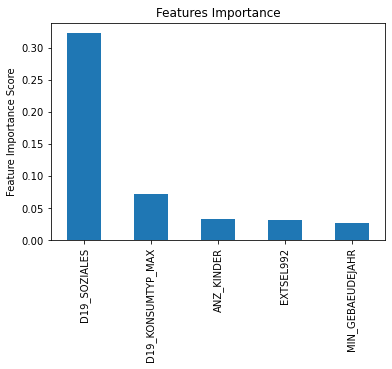

In [72]:
# Examine the most important features of the final tuned model.
final_model = GradientBoostingClassifier(learning_rate=0.001, n_estimators=60,\
                                         max_depth=5, max_features=175,\
                                         min_samples_leaf=2, min_samples_split=30, subsample=0.9,\
                                         random_state=RANDOM_STATE)
_ = final_model.fit(X_train, y_train)
feat_imp = pd.Series(final_model.feature_importances_, list(X_train)).sort_values(ascending=False).head()
_ = feat_imp.plot(kind='bar', title='Features Importance')
_ = plt.ylabel('Feature Importance Score')
print("GBM ROC AUC {}%".format( round(100*roc_auc_score(y_test, final_model.predict_proba(X_test)[:,1]),2)) )
print(classification_report(y_test, final_model.predict(X_test)))

The plot displays the importance of the top 5 features. Further features are available by passing an argument to the `.head(X)` method above, but subsequent ones are only marginally relevant and monotonously decreasing in importance. The EXCEL spreadsheet that decrypts the names of these features is silent with respect to **D19_SOZIALES**, and **D19_KONSUMTYP_MAX**. **KBA05_KW1** represents the share of cars with less than 59 KW engine power; **ANZ_HH_TITEL** counts the number of academic title holders in the building, and **ALTERSKATEGORIE_FEIN** represents some sort of age classification, but the exact meaning is also missing from the spreadsheet. It is hard to attach an educated hypothesis as to why these particular features emerged in importance given our prior conclusions from the data visualizations and segmentation exercises. 

In [73]:
# Prepare prediction on Test Mailout data for Kaggle scoring
preds_gb_totest = final_model.predict_proba(totest)[:,1]
kaggle_submit = pd.DataFrame(index=tt_LNR, data=preds_gb_totest)
kaggle_submit.rename(columns={0: "RESPONSE"}, inplace=True)
kaggle_submit.to_csv("HCG-Capstone_GBM_final_hypertuned.csv")

<img src="images/kaggle.png" width=1200 height=50 />

## PCA Before Classification
It is tempting to consider the effect of a dimensionality reduction step on the mailout data before supervised learning through the classification models. Although some information will be lost (variance vs dimensionality tradeoff), the greedy nature with which PCA projects the data onto high variance space suggests that it also gets rid of data noise in the form of superfluous features. To this end, we'll now repeat the analysis of the mailout data by first scaling and reducing the dimensionality through Principal Component Analysis as we did in the unsupervised learning part of the project.

In [74]:
# Standardize, and keep numpy array as well as dataframe.
scaler = StandardScaler()
scaler = scaler.fit(mailout_X)
scaled_mo_X = scaler.transform(mailout_X)
mo_X = DataFrame(scaled_mo_X, columns = mailout_X.columns)

scaler = StandardScaler()
scaler = scaler.fit(totest)
scaled_tt = scaler.transform(totest)
tt = DataFrame(scaled_tt, columns = totest.columns)

In [75]:
# Apply PCA to the Training Mailout data.
N_COMPONENTS=356 # Features - 1
ipca_explore = IncrementalPCA(n_components=N_COMPONENTS, batch_size=N_COMPONENTS)

_ = ipca_explore.fit_transform(scaled_mo_X)

_ = interact(show_pca, coeffs=fixed(ipca_explore),
             given_PCA=widgets.IntSlider(min=0, max=N_COMPONENTS-1, step=1, value=10),
             Features=widgets.IntSlider(min=5, max=50, step=1, value=10))

interactive(children=(IntSlider(value=10, description='given_PCA', max=355), IntSlider(value=10, description='…

In [76]:
# Re-apply PCA, selecting for number of components to retain.
# The Mailout data retains 90% of variance with approximately 210 components.
REDUCED_DIM = 210
ipca = IncrementalPCA(n_components=REDUCED_DIM, batch_size=REDUCED_DIM)

_ = ipca.fit(scaled_mo_X)
mo_X_PCA = ipca.transform(scaled_mo_X)

# List the PCA components
print("\n\nPCA Components {}".format(DataFrame(ipca.components_).shape))
PCA_components = DataFrame(ipca.components_, columns = mailout_X.columns.values)
PCA_components.index =  ['PCA_{}'.format(i) for i in range(len(ipca.components_))]
PCA_components.head()

# List the PCA transformed mailout dataset.
print("\n\nReduced Dimensionality Mailout Dataset {}".format(DataFrame(mo_X_PCA).shape))
mo_X_PCA_df = DataFrame(mo_X_PCA)
mo_X_PCA_df.head()



PCA Components (210, 357)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAE



Reduced Dimensionality Mailout Dataset (42962, 210)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209
0,-6.874958,-4.938652,2.598779,2.699704,-1.386122,0.357355,0.949750,-2.087585,-2.210667,2.081754,-2.199942,0.945632,0.104349,-1.198838,0.184318,0.207246,-0.840386,1.920501,0.749884,0.862809,1.511539,-1.320737,0.502661,0.754635,1.604353,1.278969,0.449307,0.619397,0.311674,2.112616,1.322806,1.885359,2.421043,-0.441795,-2.384048,-0.403044,-1.750206,0.336776,-1.637298,-1.367080,-0.141769,0.932877,-1.244153,-0.909048,1.878272,1.435130,-1.128937,0.041107,-0.756682,-2.713065,0.148896,-0.484106,0.037596,-0.830049,-1.639493,0.124383,-0.641285,0.063908,0.090187,0.457277,0.617376,0.771242,-0.247984,-0.645427,-0.635295,0.089955,-1.203659,0.074191,1.185428,1.015960,0.631285,0.905295,-1.517807,-0.826231,-0.306412,-0.497986,0.389750,-0.053874,0.454319,-0.364203,-0.231063,0.270000,0.528089,0.040632,0.001274,-0.815101,-0.678993,-0.043585,-0.317568,-0.762949,1.088696,0.078582,0.509296,-1.021102,-1.167087,1.483444,0.549624,-1.453450,0.336841,-0.188360,-0.718521,0.395064,-0.884494,0.587424,-0.671099,0.760932,-0.986059,1.105861,0.367592,-0.348995,0.347931,1.476074,0.505199,0.120278,0.297088,1.220042,-0.942949,0.510579,-0.888077,0.251583,-1.222405,0.657582,-1.571605,0.844110,-0.348982,1.390496,0.822267,0.997117,0.614475,-1.155511,-0.265201,-1.330754,-0.603993,0.240037,0.266136,-0.239845,-0.199206,-0.291498,-0.742058,0.192560,-0.340828,0.238414,-0.067307,-1.602602,1.480481,0.133700,0.284796,-0.095208,-0.045407,-0.282582,-0.243521,0.252397,-0.475261,0.438703,-0.652332,0.665403,-0.238468,1.208396,0.657589,-0.334771,0.720156,1.122823,-0.486022,0.108976,0.755961,-0.083163,-0.338466,0.242492,-0.817211,-0.897496,-0.316111,1.164528,0.529015,-0.460548,0.636354,-0.149071,-0.654089,0.443881,0.595935,0.448373,-1.002068,-0.091544,1.028644,1.259844,-1.082369,1.459471,-0.811634,0.852412,0.018189,-0.315348,0.709543,-0.447331,0.384417,-0.567215,0.203558,0.261646,-0.034045,0.211271,-0.206041,-1.501055,-0.512252,0.607089,0.282876,-1.596592,0.615146,-0.381642,0.759704,0.369379,0.240716,-0.070413
1,8.162363,0.979088,-1.249698,-2.581322,0.172752,1.521121,2.629429,-1.878562,-2.529379,1.956941,3.466826,2.940253,-0.059878,-1.417388,2.605157,2.178483,3.874856,0.065168,4.074555,-0.911667,-1.880768,-2.044446,-1.551140,3.876830,-0.086618,-3.431380,1.900466,0.668814,-1.148513,-0.192041,-0.848501,1.608332,0.678379,-0.993360,1.447655,0.405624,-0.980446,0.071876,-1.687044,1.198326,1.956185,1.572684,2.054512,3.402670,1.129238,0.607570,0.044010,0.001161,2.527474,0.441401,-2.153878,-0.845744,-0.152291,-1.169314,1.150050,1.302224,1.719898,1.980004,0.531275,-1.657370,1.137126,0.714924,1.701099,-0.725566,-0.409895,2.196583,-1.004892,0.020552,-0.918997,1.391860,0.261898,-0.962409,-0.509250,1.287892,0.333700,-0.081106,0.581567,-0.819371,-0.081441,-1.583289,0.538424,-0.464239,0.686233,-0.496707,0.041689,-0.779758,-1.941665,-0.526410,1.758092,-3.334089,0.423756,0.650360,-0.936157,2.988038,-0.551489,-0.546193,-0.179731,-1.171578,1.442357,-0.708704,-0.987780,-0.883337,-0.368364,1.224006,-1.655123,-0.935830,0.287262,-0.251927,-0.673512,-0.980638,0.712282,-1.237973,-1.690536,-0.534245,-1.011179,1.405398,1.028292,-0.058295,1.728518,0.291203,0.100274,-1.598174,-1.326504,-1.422577,-1.666189,0.691131,-1.065792,-0.421220,2.113720,-1.263124,1.047441,0.160203,-1.575103,-0.208617,-0.50

In [77]:
tt_PCA = ipca.transform(scaled_tt)

In [78]:
PCA_X_train, PCA_X_test, PCA_y_train, PCA_y_test = train_test_split(mo_X_PCA, mailout_y, stratify=mailout_y, test_size=0.2, random_state=RANDOM_STATE)

In [79]:
PCA_gradient_boost = GradientBoostingClassifier(random_state=RANDOM_STATE)
_ = PCA_gradient_boost.fit(PCA_X_train, PCA_y_train)
prediction = PCA_gradient_boost.predict_proba(PCA_X_test)[:,1]
print("Gradient Boosting Classifier AUC-ROC {}%".format( round(100*roc_auc_score(PCA_y_test, prediction),2)) )

Gradient Boosting Classifier AUC-ROC 60.05%


This result is rather disappointing, but not at all surprising. 

<br/><br/>
## Conclusions:

In this project we examined unsupervised and supervised ML techniques to identify potential customers for a targeted advertising campaign. There were a number of challenges concerning the data: First, there was a significant number of barren rows with more than 50% blank entries. More concerning, however, was the fact that the percentage of missing data was strangely structured as a ladder. Without a clear understanding of this phenomenon we are left to wonder whether any analysis makes sense for purposes beyond the purely academic.
Another unexpected characteristic of the datasets was the exorbitant amount of highly correlated and perhaps not so relevant features. Features such as "the share of cars with less than 59 KW engine power”, and "the share of car owners between 46 and 60 within the Zip Code" abound. Perhaps it is wise to guide a marketing campaign based on such information about individuals; we must assume so for this project. Also, the EXCEL spreadsheets detailing the meaning behind the column names left a large portion of the columns unexplained; this was disappointing.

After proceeding with the data preprocessing steps, namely, removing rows with missing data, dropping some columns, encoding non-numerical features, imputing missing values in columns, handling outliers and normalizing, several visualizations were produced to inspect and compare the features' histograms of both the general population and customer datasets. What transpired was a first glance at the information we were looking for, i.e., the characterization of customers by demographic data. During this Data Exploration and Preprocessing step, we developed a maverick approach to imputation, taking advantage of the categorical nature of the features. Details of the technique, along with the code used to implement it, are to be found in the files included in the [GitHub Repository](https://github.com/bubekaro/MLE-Capstone) for this project. The unsupervised learning part of the project achieved a dimensionality reduction of 50% of the columns by sacrificing only 10% of the information, and subsequent segmentation by K-Means clustering using 10 clusters. This segmentation revealed similar conclusions about the customers. But now the degree to which features were overrepresented or underrepresented in the customer dataset could be measured.

The last part of the project consisted of selecting a classifier and tuning some of its parameters using a metric appropriate for the highly imbalanced mailout campaign train and test datasets. Using ROC AUC, the Gradient Boosting Classifier was selected and a number of its boosting and tree-specific parameters were tuned. A score of 79.6% was attained in the [Kaggle Competition](https://www.kaggle.com/c/udacity-arvato-identify-customers/submissions).
As a final step, a last ditch effort was made to improve this score by considering the effect of a dimensionality reduction step on the mailout data before classification. The motivation was a belief that although some information would be lost, the PCA procedure would get rid of data noise in the form of superfluous features. This was a wasted effort that made matters worse. Be it as it may, the idea had didactic value, if only to learn the consequences of stepping out of the bounds of ML orthodoxy. The project was fun; a lot was learned not only with regards to ML techniques, but also about the tools of the trade as applied to a real-life problem. I would recommend this course, and this project to anyone genuinely curious about Machine Learning.

As far as improvement, there were a number of ideas that emerged as after-thoughts. With hindsight they appear promising as possible ways to up the score a bit. First, rather than obsess about the ladder structure of the missing data, and instead of discarding any missing rows, one could attempt to split the datasets into as many data frames as there are rungs, one with rows missing more than 70% of the entries, another with those missing more than 60%, and so on, as dictated by the ladder shown in Figure 1. Then, a simple comparison of the statistics across subsets of data would immediately reveal if the conjecture that the data was sourced with mixed origins was right or wrong. This knowledge would then guide the project to proceed with several separate unsupervised as well as supervised ML techniques, or one large one as we did. But at least this way we would have the certainty that the data could be analyzed without splitting it. Second, there were a number of features, such as CAMEO_DEUINTL_2015, with bins showing inner structure, i.e., features containing features. It is probably best to split these features to end up with a higher number of columns, each one possessing truly independent information. 
Third, the columns CUSTOMER_GROUP, ONLINE_PURCHASE, and PRODUCT_GROUP in the customer dataset were entirely ignored in our analysis. Here too, it is sensible to consider performing three separate analyses split along these columns. All these suggestions for improvement would mean multiple separate analyses which in reality would be extremely time consuming, but thorough. In the end, it would probably be another trade-off between information and pragmatism.

<br/><br/>
## References:
- Jonathan Kropko, Ben Goodrich, Andrew Gelman & Jennifer Hill, (2013). Multiple Imputation for Continuous and Categorical Data:Comparing Joint and Conditional Approaches, page 2., http://www.stat.columbia.edu/~gelman/research/published/MI_manuscript_RR.pdf

- Samantha Miranda, (2020). Investigation of Multiple Imputation Methods for Categorical Variables., https://dc.etsu.edu/cgi/viewcontent.cgi?article=5204&context=etd

- Ian R White, Rhian Daniel, and Patrick Royston, (2010). Avoiding bias due to perfect prediction in multiple imputation of incomplete categorical variables. Computational Statistics & Data Analysis., https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3990447/

- Kenneth Leung, (2021). Assumptions of Logistic Regression, Clearly Explained. https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290

- Niklas Donges, (2021). A Complete Guide to the Random Forest Algorithm. https://builtin.com/data-science/random-forest-algorithm

- Avinash Naviani, (2018). AdaBoost Classifier in Python. https://www.datacamp.com/community/tutorials/adaboost-classifier-python- 

- Akash Desarda, (2019). Understanding AdaBoost. https://towardsdatascience.com/understanding-adaboost-2f94f22d5bfe

- Jason Brownlee, (2016). A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning. https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

- Manish Pathak, (2019). Using XGBoost in Python. https://www.datacamp.com/community/tutorials/xgboost-in-python

- Aarshay Jain, (2016). Complete Machine Learning Guide to Parameter Tuning in Gradient Boosting (GBM) in Python. https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

